## ⚙️ Import Libraries

In [1]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 2


## ⏳ Load the Data (no outlier)

In [2]:
from sklearn.model_selection import train_test_split
import numpy as np
data = np.load("/kaggle/input/normal/cleaned_data.npz")

X_train = data["training_set_filtered"]

y_train = data["masks_filtered"]

X_test = data["test_set"]
print(y_train[0].shape)
print(f"Test X shape: {X_test.shape}")

# Perform train-validation split (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")

(64, 128)
Test X shape: (10022, 64, 128)
Train set: (2004, 64, 128), (2004, 64, 128)
Validation set: (501, 64, 128), (501, 64, 128)


### Outliers removed

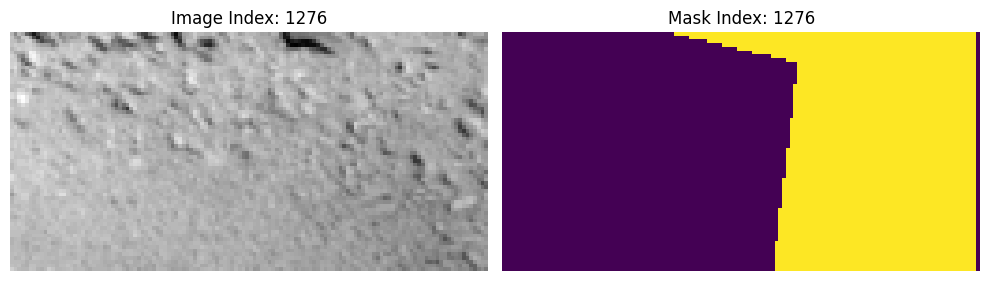

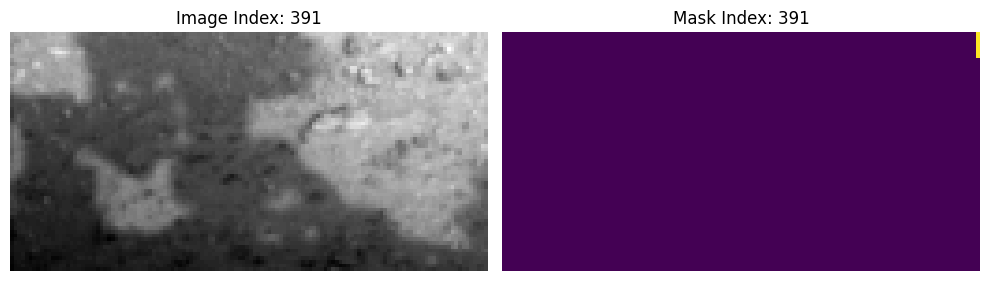

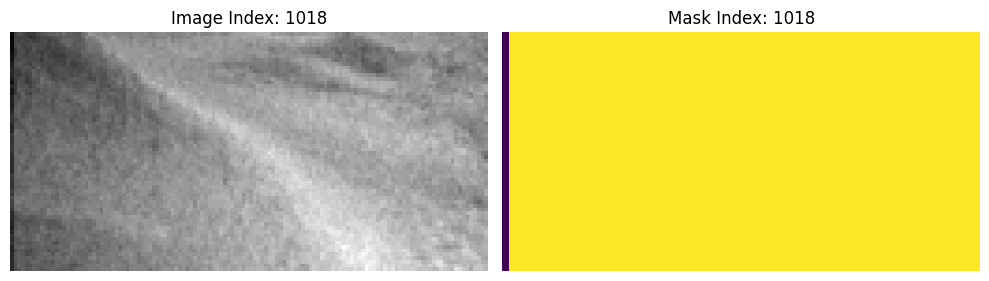

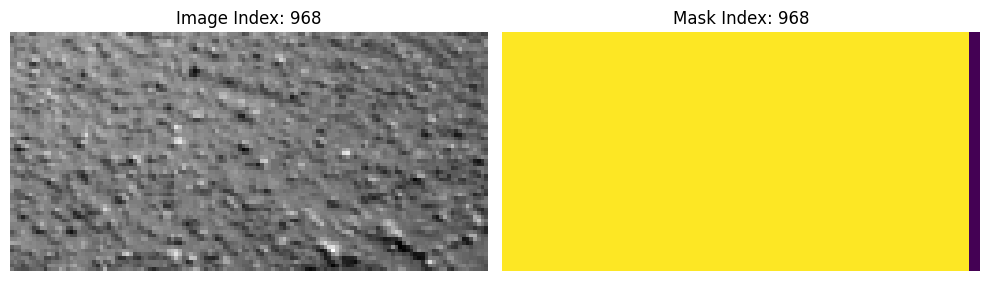

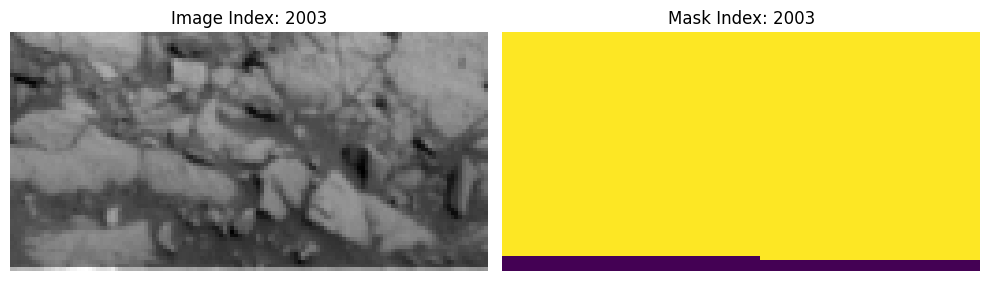

In [3]:
import random

# Visualize random image-mask pairs
for _ in range(5):
    idx = random.randint(0, len(X_train) - 1)
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Display input image
    ax[0].imshow(X_train[idx], cmap="gray")
    ax[0].set_title(f"Image Index: {idx}")
    ax[0].axis("off")

    # Display corresponding mask
    ax[1].imshow(y_train[idx], cmap="viridis")
    ax[1].set_title(f"Mask Index: {idx}")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()

## LETS DO SOME AUGMENTATION!!

## invert image and noise

/tmp/ipykernel_23/1632159539.py:66: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(len(images), 6, i * 6 + 3)
/tmp/ipykernel_23/1632159539.py:88: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


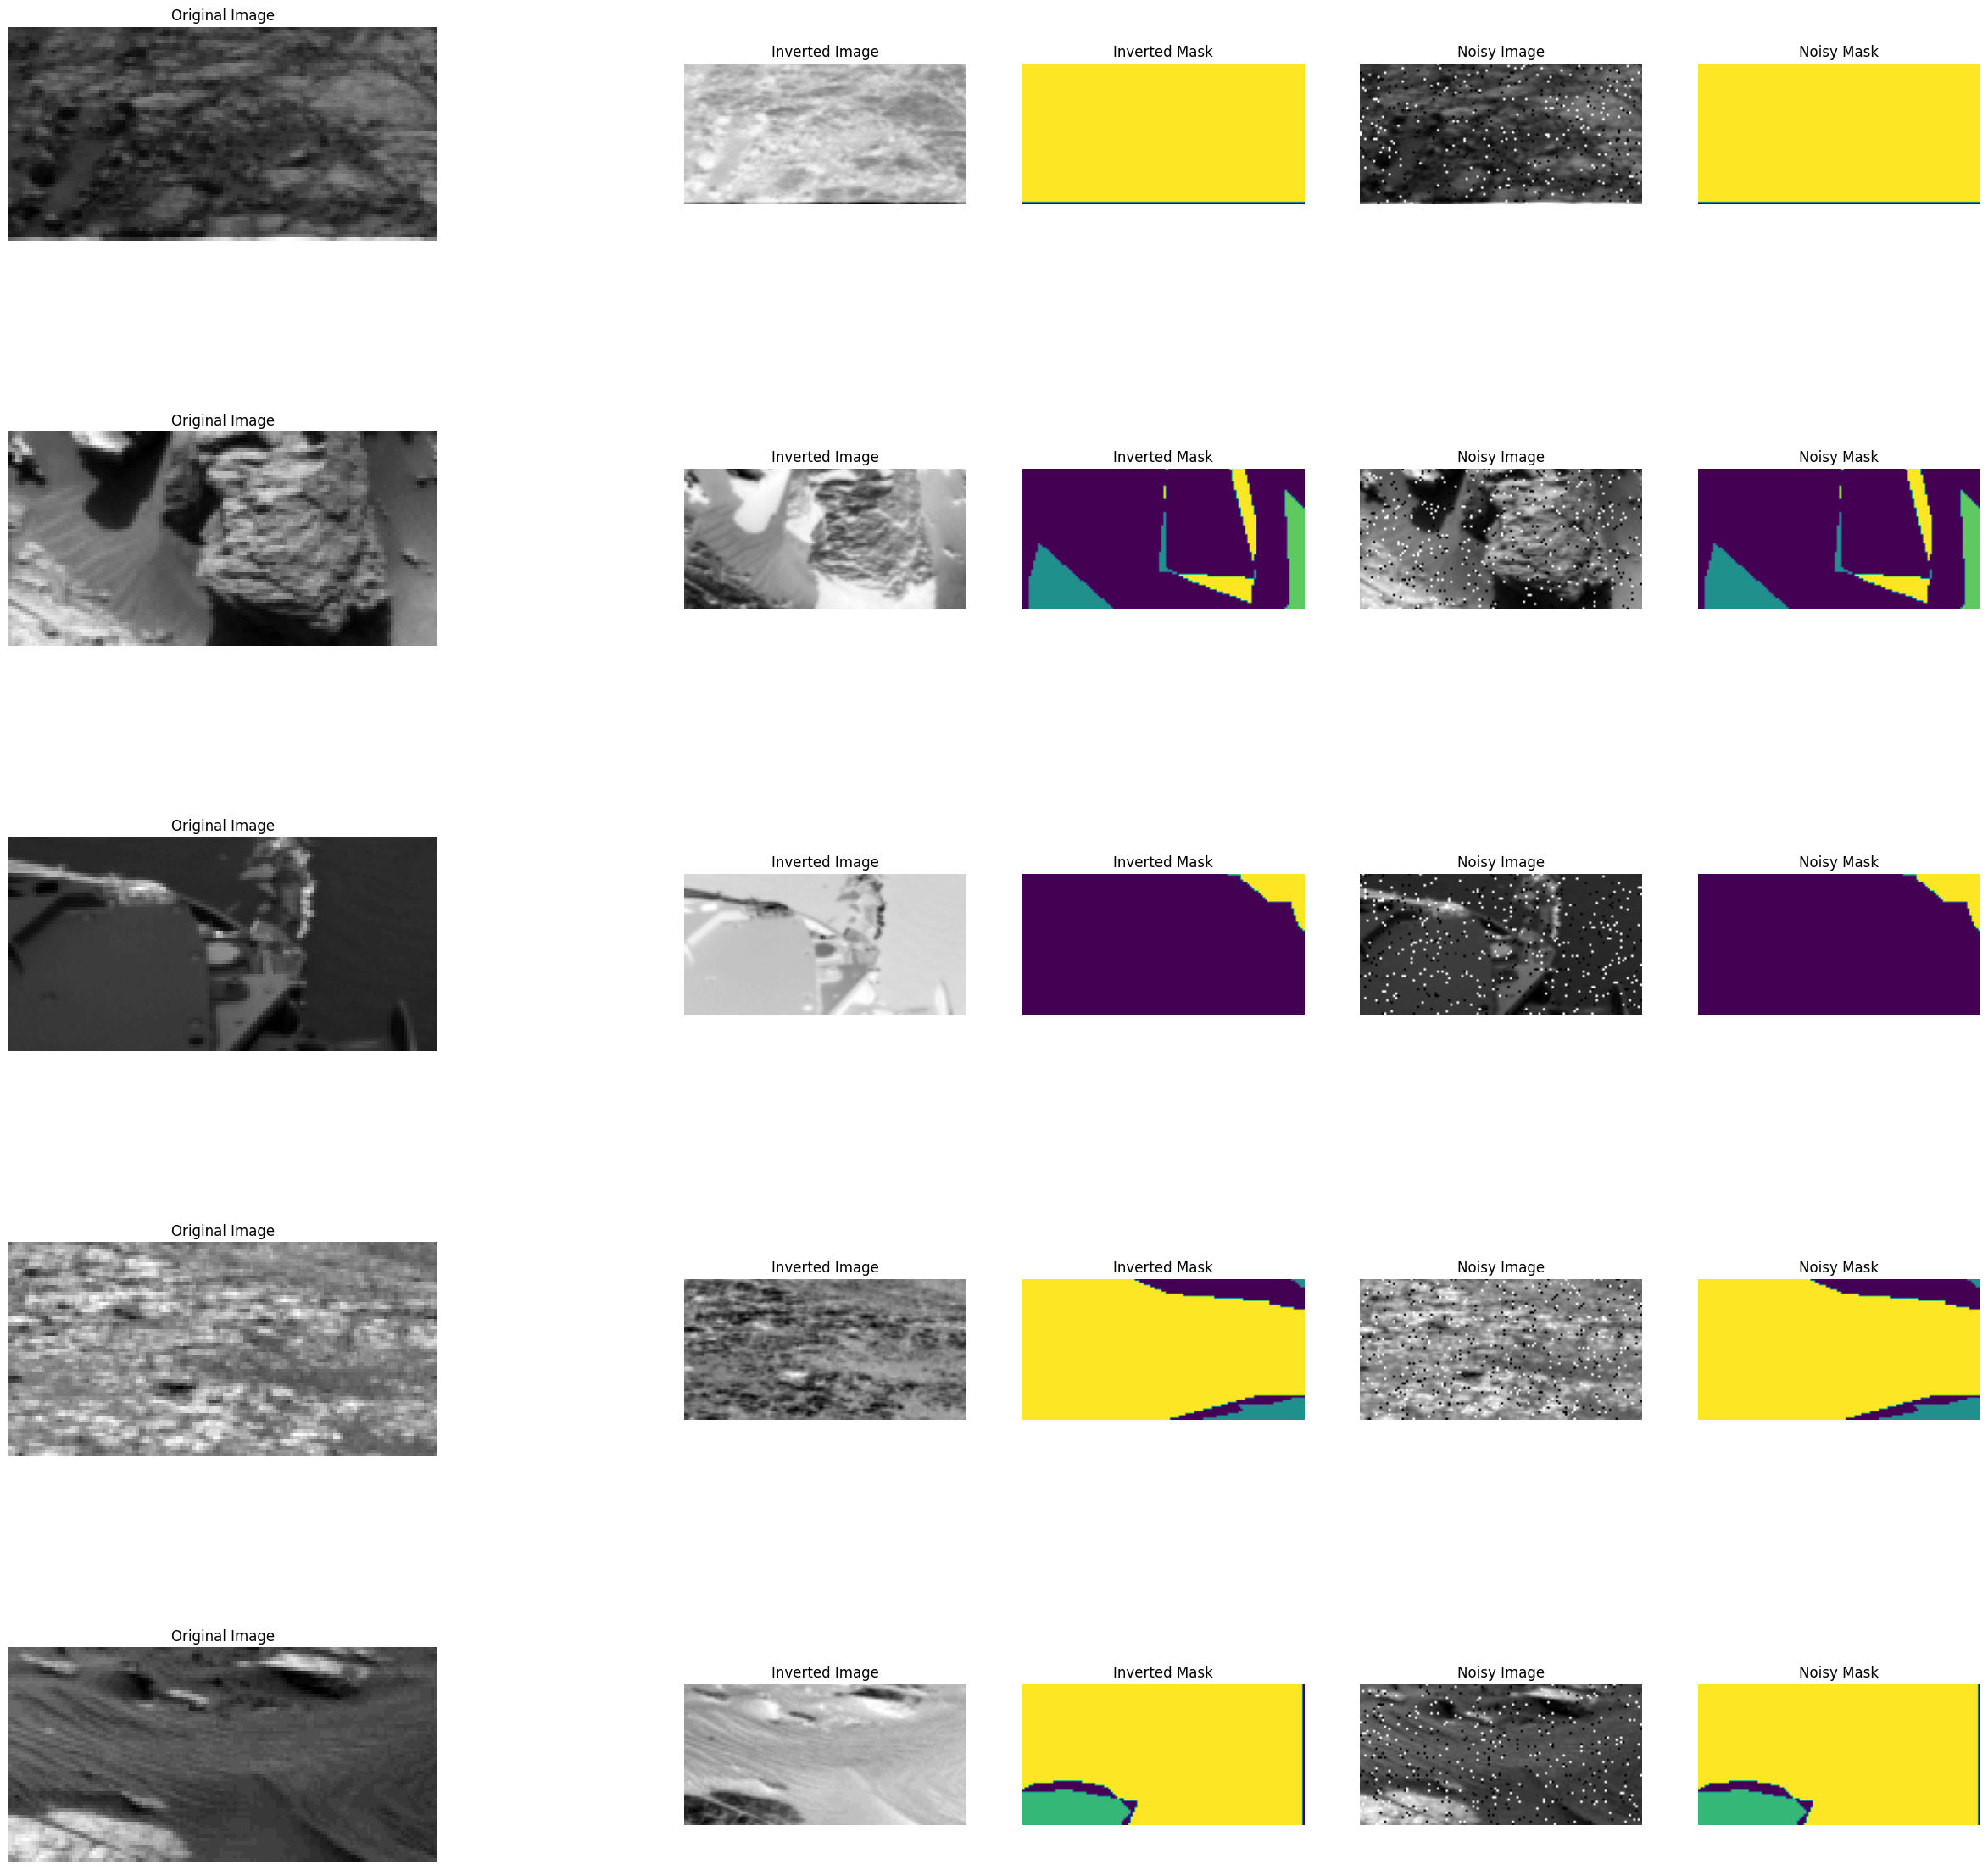

In [4]:


import numpy as np
from skimage.util import random_noise

# Define augmentation functions with mask handling
def invert_image(image, mask):
    return 255 - image, mask  # Mask remains unchanged

def add_salt_and_pepper_noise(image, mask, prob=0.03):
    """
    Add salt-and-pepper noise to an image while maintaining its original value range.

    Args:
        image (np.ndarray): Input image.
        mask (np.ndarray): Corresponding mask (unchanged).
        prob (float): Probability of noise per pixel.

    Returns:
        noisy_image (np.ndarray): Image with noise applied.
        mask (np.ndarray): Unchanged mask.
    """
    # Save the original range
    original_min = image.min()
    original_max = image.max()

    # Normalize the image to [0, 1]
    normalized_image = (image - original_min) / (original_max - original_min)

    # Generate random noise map
    random_map = np.random.random(image.shape)
    noisy_image = normalized_image.copy()
    noisy_image[random_map < prob] = 0  # Pepper
    noisy_image[random_map > (1 - prob)] = 1  # Salt

    # Rescale back to the original range
    noisy_image = noisy_image * (original_max - original_min) + original_min
    noisy_image = noisy_image.astype(image.dtype)  # Ensure the original data type is preserved

    return noisy_image, mask

"""def rotate_image(image, mask, angle):
    rotated_image = rotate(image, angle, reshape=False, mode='constant', cval=0)
    rotated_mask = rotate(mask, angle, reshape=False, mode='constant', order=0)
    return rotated_image, rotated_mask"""
"""
def adjust_brightness(image, mask, factor=1.2):
    brightened_image = np.clip(image * factor, 0, 255).astype(np.uint8)
    return brightened_image, mask  # Mask remains unchanged"""

# Visualize augmentations with masks
def visualize_all_augmentations(images, masks):
    plt.figure(figsize=(30, 30))
    for i, (image, mask) in enumerate(zip(images, masks)):
        # Original image and mask
        plt.subplot(len(images), 4, i * 4 + 1)
        plt.imshow(image, cmap="gray")
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(len(images), 4, i * 4 + 2)
        plt.imshow(mask, cmap="viridis")
        plt.title("Original Mask")
        plt.axis("off")

        # Inversion
        inverted_image, inverted_mask = invert_image(image, mask)
        plt.subplot(len(images), 6, i * 6 + 3)
        plt.imshow(inverted_image, cmap="gray")
        plt.title("Inverted Image")
        plt.axis("off")

        plt.subplot(len(images), 6, i * 6 + 4)
        plt.imshow(inverted_mask, cmap="viridis")
        plt.title("Inverted Mask")
        plt.axis("off")

        # Noise
        noisy_image, noisy_mask = add_salt_and_pepper_noise(image, mask)
        plt.subplot(len(images), 6, i * 6 + 5)
        plt.imshow(noisy_image, cmap="gray")
        plt.title("Noisy Image")
        plt.axis("off")

        plt.subplot(len(images), 6, i * 6 + 6)
        plt.imshow(noisy_mask, cmap="viridis")
        plt.title("Noisy Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# Randomly select 5 samples from the dataset
random_indices = np.random.choice(len(X_train), size=5, replace=False)
sample_images = X_train[random_indices]
sample_masks = y_train[random_indices]

# Visualize augmentations
visualize_all_augmentations(sample_images, sample_masks)


### rotation

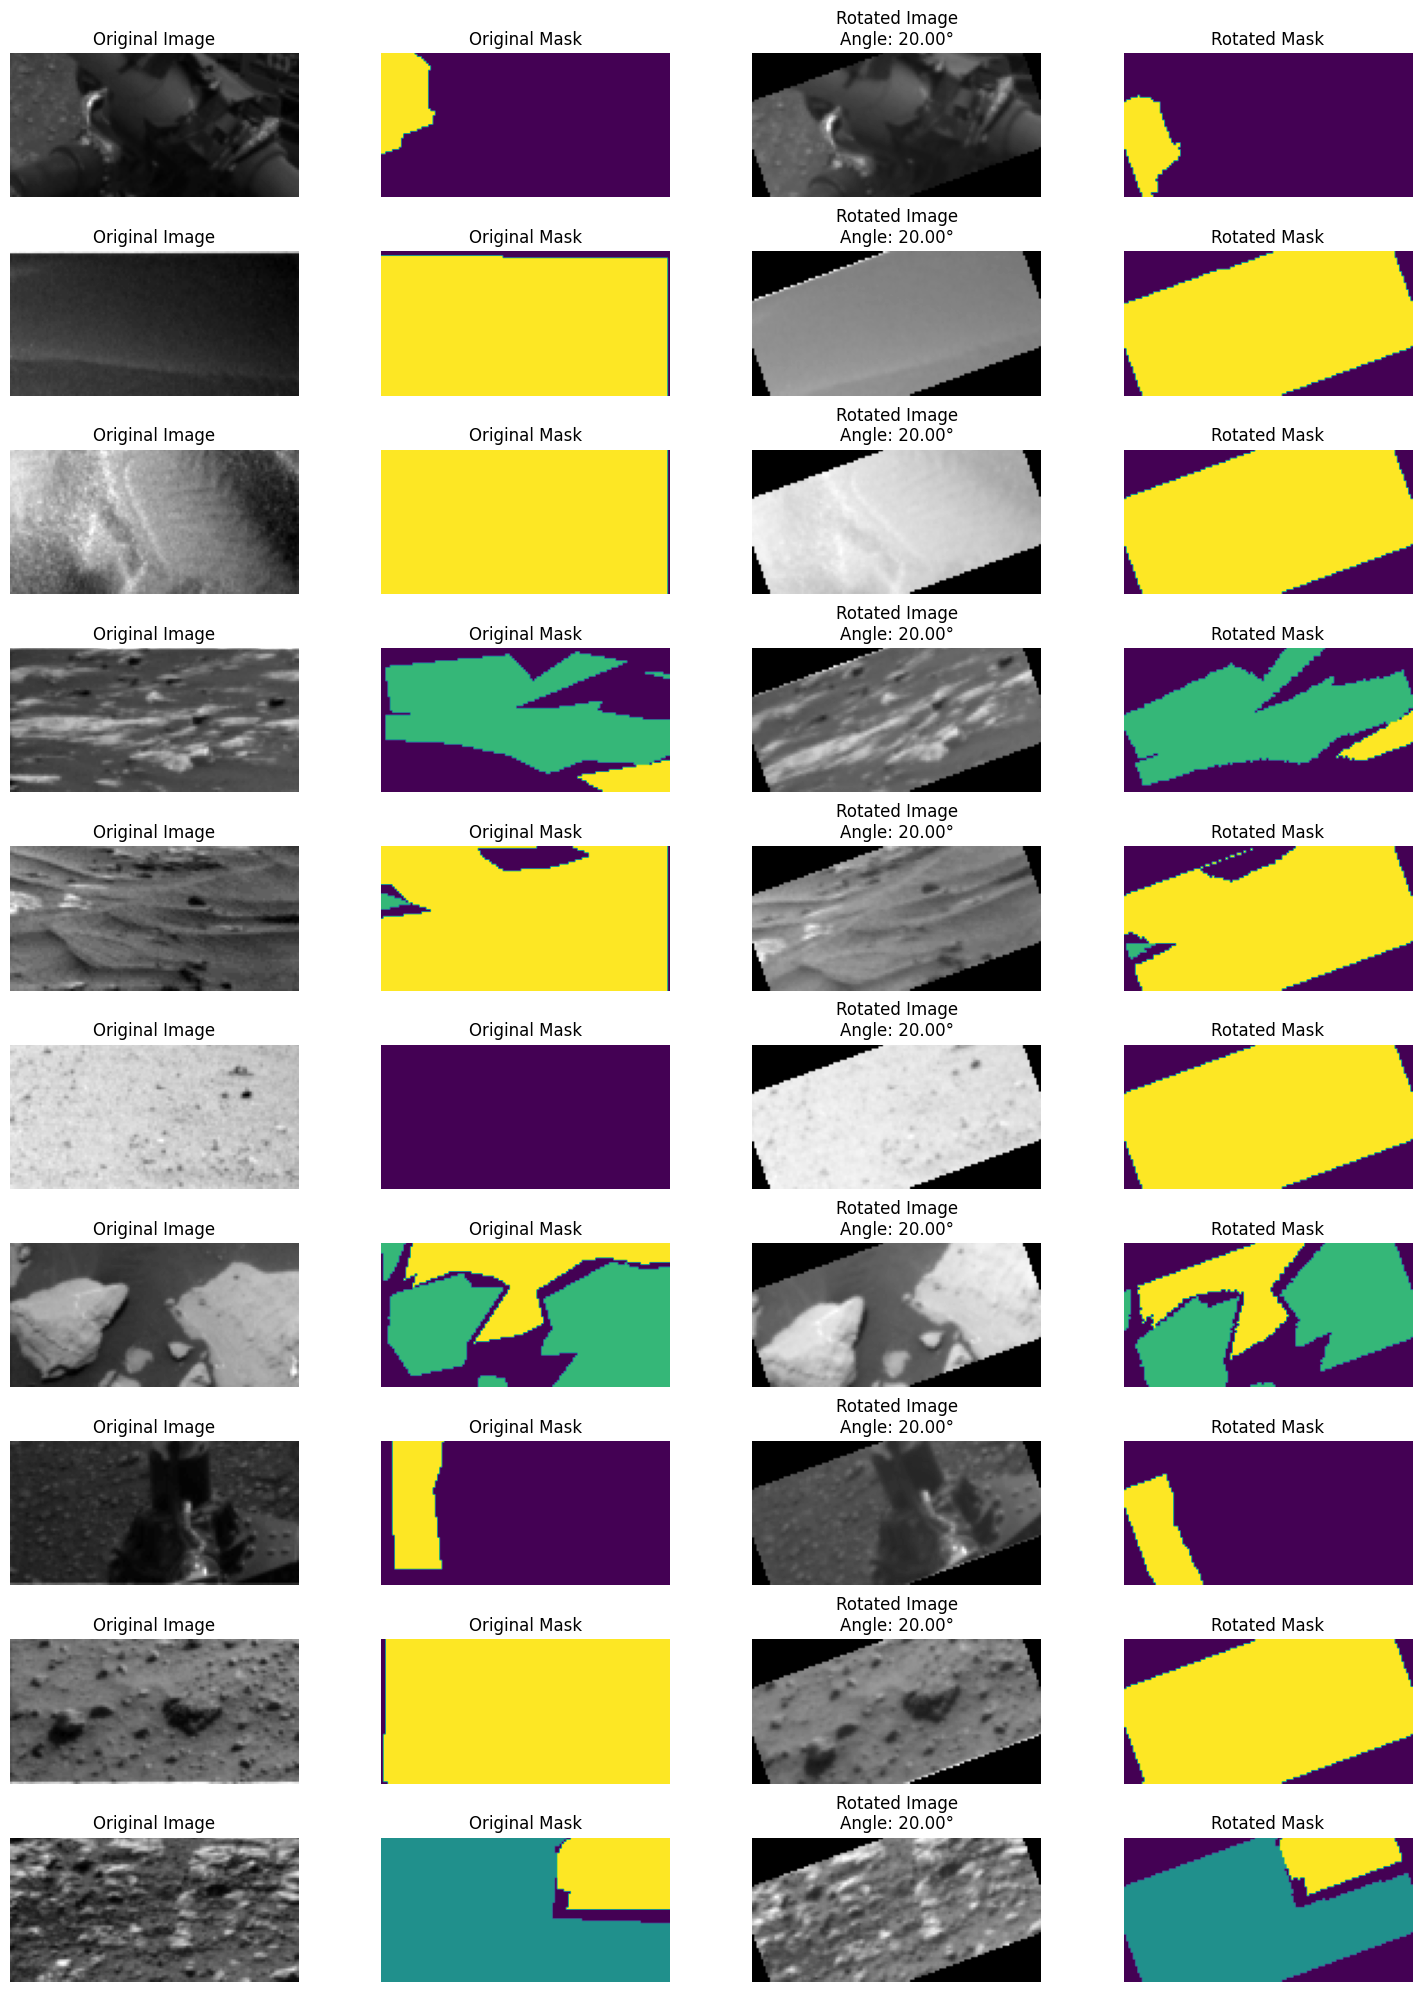

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

# Define the rotation function using scipy
def rotate_image_and_mask(image, mask, angle):
    """
    Rotate a grayscale image and its corresponding mask by a given angle.
    """
    # Rotate the grayscale image (bilinear interpolation)
    rotated_image = rotate(image, angle, reshape=False, mode="constant", order=1)

    # Rotate the mask (nearest-neighbor interpolation)
    rotated_mask = rotate(mask, angle, reshape=False, mode="constant", order=0)

    return rotated_image, rotated_mask

# Randomly select 10 images
random_indices = np.random.choice(len(X_train), size=10, replace=False)
selected_images = X_train[random_indices]
selected_masks = y_train[random_indices]

# Apply random rotation and visualize
plt.figure(figsize=(15, 20))
for i, (image, mask) in enumerate(zip(selected_images, selected_masks)):
    # Generate a random angle for rotation
    angle = np.random.uniform(20, 20)  # Random angle between -30° and 30°

    # Rotate the image and mask
    rotated_image, rotated_mask = rotate_image_and_mask(image, mask, angle)

    # Plot original and rotated images/masks
    plt.subplot(10, 4, i * 4 + 1)
    plt.imshow(image, cmap="gray")
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(10, 4, i * 4 + 2)
    plt.imshow(mask, cmap="viridis")
    plt.title("Original Mask")
    plt.axis("off")

    plt.subplot(10, 4, i * 4 + 3)
    plt.imshow(rotated_image, cmap="gray")
    plt.title(f"Rotated Image\nAngle: {angle:.2f}°")
    plt.axis("off")

    plt.subplot(10, 4, i * 4 + 4)
    plt.imshow(rotated_mask, cmap="viridis")
    plt.title("Rotated Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
# Function to split and resize an image and its mask
def split_and_resize(image, mask, target_size):
    """
    Splits an image and mask into four quadrants and resizes them to the target size.

    Args:
        image (ndarray): Input image.
        mask (ndarray): Corresponding mask.
        target_size (tuple): Desired size (height, width) for the output quadrants.

    Returns:
        list: List of tuples (quadrant_image, quadrant_mask).
    """
    h, w = image.shape
    half_h, half_w = h // 2, w // 2

    quadrants = [
        (resize(image[:half_h, :half_w], target_size, mode="constant"),
         resize(mask[:half_h, :half_w], target_size, mode="constant", order=0)),
        (resize(image[:half_h, half_w:], target_size, mode="constant"),
         resize(mask[:half_h, half_w:], target_size, mode="constant", order=0)),
        (resize(image[half_h:, :half_w], target_size, mode="constant"),
         resize(mask[half_h:, :half_w], target_size, mode="constant", order=0)),
        (resize(image[half_h:, half_w:], target_size, mode="constant"),
         resize(mask[half_h:, half_w:], target_size, mode="constant", order=0)),
    ]
    return quadrants

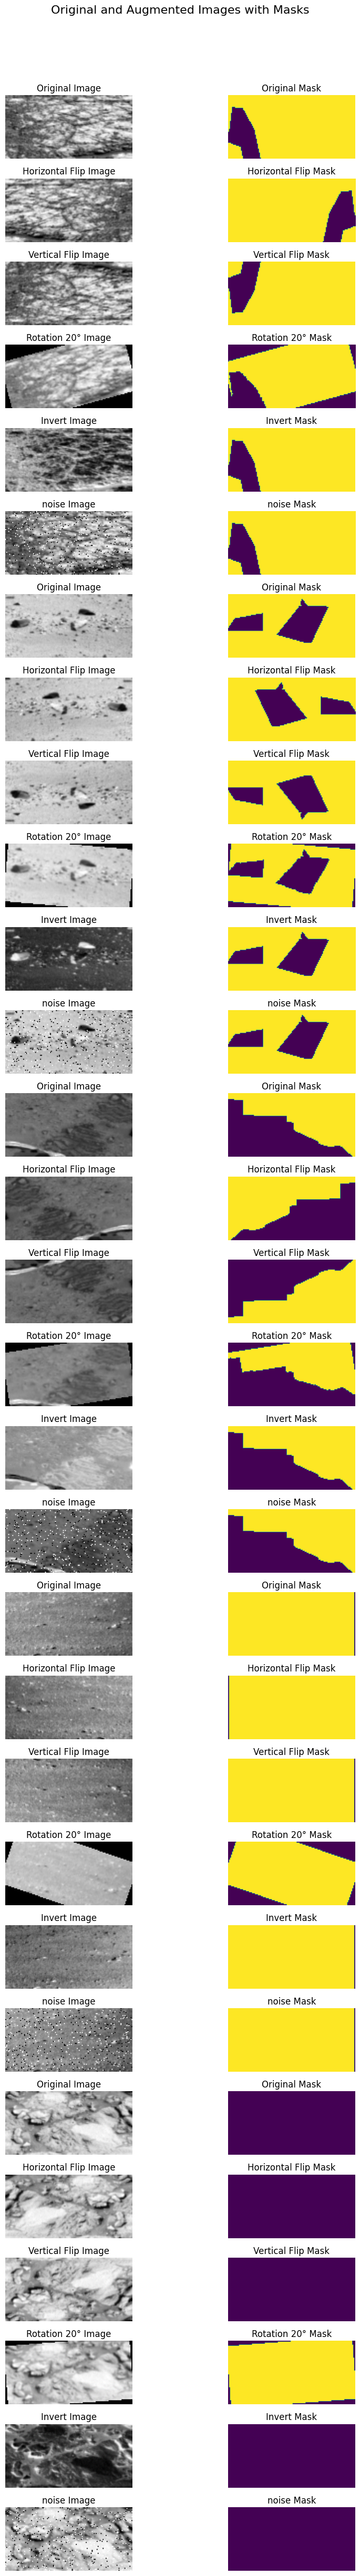

In [7]:
# Helper functions for applying augmentations
def augment_image_and_mask(image, mask, augment_type):
    if augment_type == "Horizontal Flip":
        return np.fliplr(image), np.fliplr(mask)
    elif augment_type == "Vertical Flip":
        return np.flipud(image), np.flipud(mask)
    elif augment_type == "Rotation 20°":
        angle = np.random.uniform(-20, 20)
        # Rotate the grayscale image (bilinear interpolation)
        rotated_image = rotate(image, angle, reshape=False, mode="constant", order=1)

        # Rotate the mask (nearest-neighbor interpolation)
        rotated_mask = rotate(mask, angle, reshape=False, mode="constant", order=0)

        return rotated_image, rotated_mask
    elif augment_type=="Invert":
        inverted_image, inverted_mask = invert_image(image, mask)
        return inverted_image,inverted_mask
    elif augment_type=="noise":
        noisy_image, noisy_mask = add_salt_and_pepper_noise(image, mask)
        return noisy_image,noisy_mask
        
    """elif augment_type == "Zoom (0.8-1.2)":
        zoom_factor = random.uniform(0.8, 1.2)
        zoom_image = np.clip(image * zoom_factor, 0, 255)
        return zoom_image, mask
    elif augment_type == "Shift (Width and Height)":
        shift_x, shift_y = random.uniform(-0.1, 0.1), random.uniform(-0.1, 0.1)
        return shift(image, [shift_x * image.shape[0], shift_y * image.shape[1]]), shift(mask, [shift_x * mask.shape[0], shift_y * mask.shape[1]], order=0)"""
    return image, mask

# Define augmentations
data_augmentations = {
    "Horizontal Flip": "Horizontal Flip",
    "Vertical Flip": "Vertical Flip",
    "Rotation 20°": "Rotation 20°",
    "Invert":"Invert",
    "noise":"noise"
    #"Zoom (0.8-1.2)": "Zoom (0.8-1.2)",
    #"Shift (Width and Height)": "Shift (Width and Height)",
}

# Visualize 5 random images and masks with augmentations
random_indices = np.random.choice(len(X_train), size=5, replace=False)
# Adjusting to display original image/mask with augmentations below each
fig, axes = plt.subplots(len(random_indices) * (1 + len(data_augmentations)), 2, figsize=(10, 50))
fig.suptitle("Original and Augmented Images with Masks", fontsize=16)

for idx, random_idx in enumerate(random_indices):
    original_image = X_train[random_idx]
    original_mask = y_train[random_idx]

    # Plot original image and mask
    row = idx * (1 + len(data_augmentations))  # Calculate starting row for each original image
    axes[row, 0].imshow(original_image, cmap='gray')
    axes[row, 0].set_title("Original Image")
    axes[row, 0].axis('off')

    axes[row, 1].imshow(original_mask)
    axes[row, 1].set_title("Original Mask")
    axes[row, 1].axis('off')

    # Apply augmentations and plot augmented images and masks
    for aug_idx, (augmentation_name, augment_type) in enumerate(data_augmentations.items()):
        augmented_image, augmented_mask = augment_image_and_mask(original_image, original_mask, augment_type)

        axes[row + aug_idx + 1, 0].imshow(augmented_image , cmap='gray' )
        axes[row + aug_idx + 1, 0].set_title(f"{augmentation_name} Image")
        axes[row + aug_idx + 1, 0].axis('off')

        axes[row + aug_idx + 1, 1].imshow(augmented_mask)
        axes[row + aug_idx + 1, 1].set_title(f"{augmentation_name} Mask")
        axes[row + aug_idx + 1, 1].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [8]:
from skimage.transform import resize
import numpy as np

# Function to split image into four quadrants and resize
def split_and_resize(image, mask, target_size=(64, 128), rare_class=4):
    """
    Split an image and mask into quadrants, resize them, and filter based on the presence of a rare class.
    """
    h, w = image.shape
    half_h, half_w = h // 2, w // 2
    quadrants = [
        (image[:half_h, :half_w], mask[:half_h, :half_w]),
        (image[:half_h, half_w:], mask[:half_h, half_w:]),
        (image[half_h:, :half_w], mask[half_h:, :half_w]),
        (image[half_h:, half_w:], mask[half_h:, half_w:])
    ]

    # Resize with nearest neighbor interpolation for the mask
    resized_quadrants = [
        (resize(img, target_size, mode="constant"),
         resize(mk, target_size, mode="constant", order=0, preserve_range=True).astype(int))
        for img, mk in quadrants if rare_class in mk
    ]

    return resized_quadrants



In [10]:
# Oversampling with conditions
augmented_X = []
augmented_y = []

# Target size for consistency
target_size = (64, 128)

# Counters
processed_images = 0
class_4_only_count = 0

for i, (image, mask) in enumerate(zip(X_train, y_train)):
    if 4 in mask:  # Check if class 4 is in the mask
        class_4_pixels = np.sum(mask == 4)
        total_pixels = mask.size

        if class_4_pixels / total_pixels > 0.1:
            processed_images += 1

            # Apply all augmentations sequentially
            for _ in range(10):
                aug_image, aug_mask = augment_image_and_mask(
                    image, mask, ["Horizontal Flip", "Vertical Flip", "Noise", "Rotation 20°"]
                )
                if 4 in aug_mask:  # Add only if rare class is present
                    augmented_X.append(resize(aug_image, target_size, mode="constant"))
                    augmented_y.append(resize(aug_mask, target_size, mode="constant", order=0).round().astype(int))
                
                    class_4_only_count += 1

                    # Add split quadrants that contain the rare class
                    quadrants = split_and_resize(aug_image, aug_mask, target_size)
                    for quad_img, quad_mask in quadrants:
                        if 4 in quad_mask:  # Ensure quadrant contains class 4
                            augmented_X.append(quad_img)
                            augmented_y.append(quad_mask.round().astype(int))
                         
                            class_4_only_count += 1

        else:
            processed_images += 1
            for _ in range(3):
                aug_image, aug_mask = augment_image_and_mask(image, mask, ["Horizontal Flip", "Invert"])
                if 4 in aug_mask:  # Add only if rare class is present
                    augmented_X.append(resize(aug_image, target_size, mode="constant"))
                    augmented_y.append(resize(aug_mask, target_size, mode="constant", order=0).round().astype(int))
                 
                    class_4_only_count += 1

# Log results
print(f"Processed images with class 4: {processed_images}")
print(f"Generated images with only class 4: {class_4_only_count}")


Processed images with class 4: 56
Generated images with only class 4: 434


In [11]:
# Convert to numpy arrays
augmented_X = np.array(augmented_X)
augmented_y = np.array(augmented_y)

# Add original data
augmented_X = np.concatenate([X_train, augmented_X], axis=0)
augmented_y = np.concatenate([y_train, augmented_y], axis=0)

# Save augmented dataset
np.savez_compressed("augmented_dataset.npz", X=augmented_X, y=augmented_y)

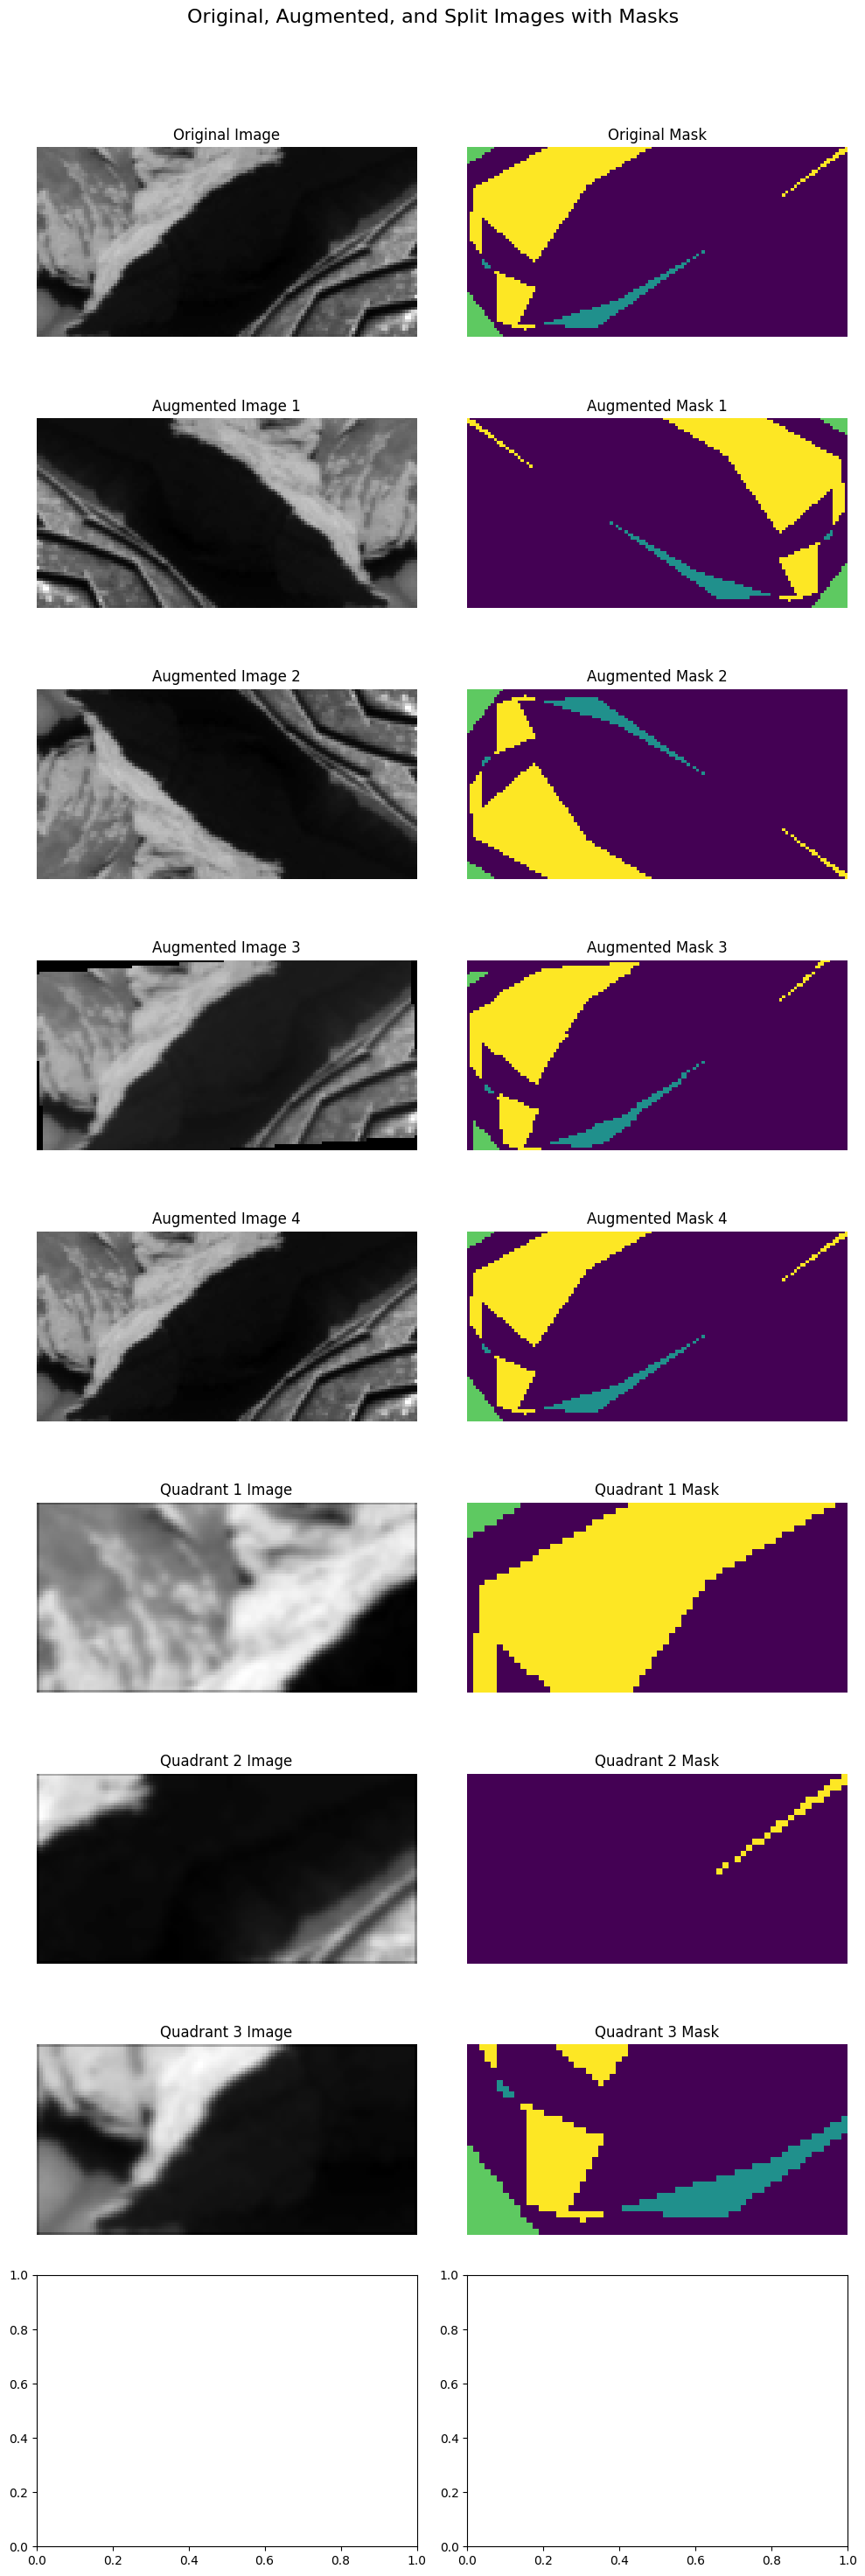

In [12]:

# Select a sample with class 4 occupying > 10% of pixels
target_size = (64, 128)
example_idx = next(i for i, mask in enumerate(y_train) if np.sum(mask == 4) / mask.size > 0.1)
example_image = X_train[example_idx]
example_mask = y_train[example_idx]

# Augment the image and mask
combined_aug_images, combined_aug_masks = [], []
augmentations = ["Horizontal Flip", "Vertical Flip", "Rotation 20°", "Noise"]

for aug_type in augmentations:
    aug_image, aug_mask = augment_image_and_mask(example_image, example_mask, aug_type)
    combined_aug_images.append(aug_image)
    combined_aug_masks.append(aug_mask)

# Split the selected image and mask
quadrants = split_and_resize(example_image, example_mask, target_size)

# Visualization
fig, axes = plt.subplots(len(combined_aug_images) + 5, 2, figsize=(10, 30))  # Adjust grid size
fig.suptitle("Original, Augmented, and Split Images with Masks", fontsize=16)

# Original image and mask
axes[0, 0].imshow(example_image, cmap="gray")
axes[0, 0].set_title("Original Image")
axes[0, 0].axis("off")

axes[0, 1].imshow(example_mask, cmap="viridis", vmin=0, vmax=4)
axes[0, 1].set_title("Original Mask")
axes[0, 1].axis("off")

# Augmented images and masks
for i, (aug_img, aug_mask) in enumerate(zip(combined_aug_images, combined_aug_masks)):
    axes[i + 1, 0].imshow(aug_img, cmap="gray")
    axes[i + 1, 0].set_title(f"Augmented Image {i+1}")
    axes[i + 1, 0].axis("off")

    axes[i + 1, 1].imshow(aug_mask, cmap="viridis", vmin=0, vmax=4)
    axes[i + 1, 1].set_title(f"Augmented Mask {i+1}")
    axes[i + 1, 1].axis("off")

# Split quadrants
for j, (quad_img, quad_mask) in enumerate(quadrants):
    row_idx = len(combined_aug_images) + j + 1
    axes[row_idx, 0].imshow(quad_img, cmap="gray")
    axes[row_idx, 0].set_title(f"Quadrant {j+1} Image")
    axes[row_idx, 0].axis("off")

    axes[row_idx, 1].imshow(quad_mask, cmap="viridis", vmin=0, vmax=4)
    axes[row_idx, 1].set_title(f"Quadrant {j+1} Mask")
    axes[row_idx, 1].axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [13]:
import os
import matplotlib.pyplot as plt

# Directory where augmented files are stored
output_dir = "augmented_data"
os.makedirs(output_dir, exist_ok=True)

# Re-save augmented datasets to the directory with structured filenames
for augmentation_name, augment_type in data_augmentations.items():
    augmented_images = []
    augmented_masks = []

    for image, mask in zip(X_train, y_train):
        aug_image, aug_mask = augment_image_and_mask(image, mask, augment_type)
        augmented_images.append(aug_image)
        augmented_masks.append(aug_mask)

    # Convert lists to numpy arrays
    augmented_images = np.array(augmented_images)
    augmented_masks = np.array(augmented_masks)

    # Save to npz file
    output_path = os.path.join(output_dir, f"{augmentation_name.replace(' ', '_').lower()}.npz")
    np.savez_compressed(output_path, augmented_images=augmented_images, augmented_masks=augmented_masks)


File: vertical_flip.npz
  Key: augmented_images, Shape: (2004, 64, 128)
  Key: augmented_masks, Shape: (2004, 64, 128)


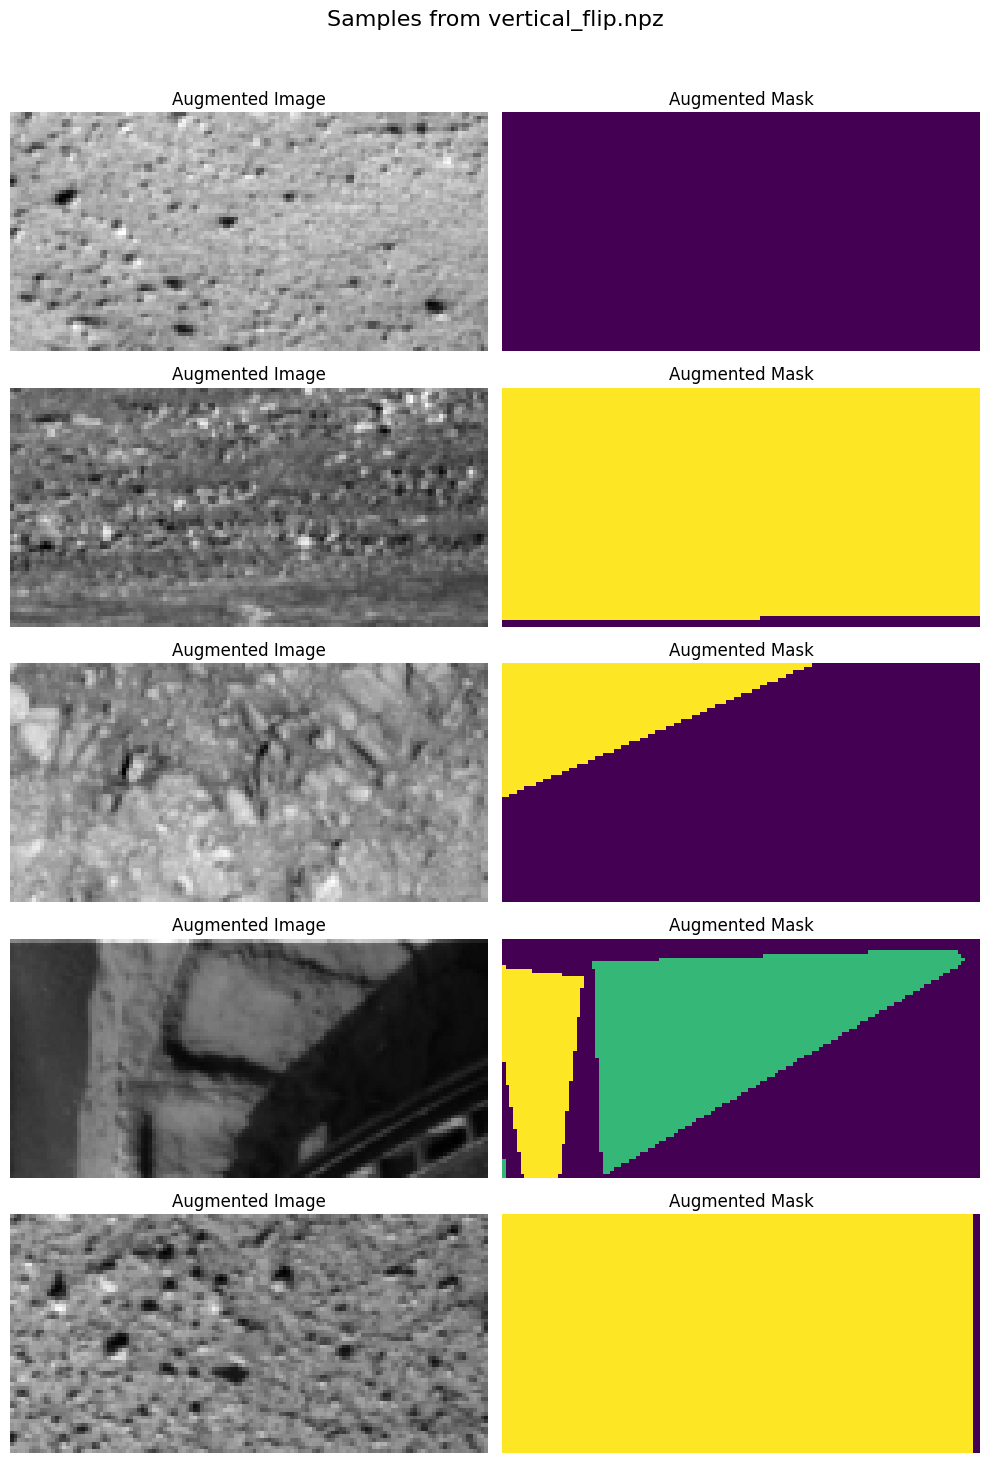

File: invert.npz
  Key: augmented_images, Shape: (2004, 64, 128)
  Key: augmented_masks, Shape: (2004, 64, 128)


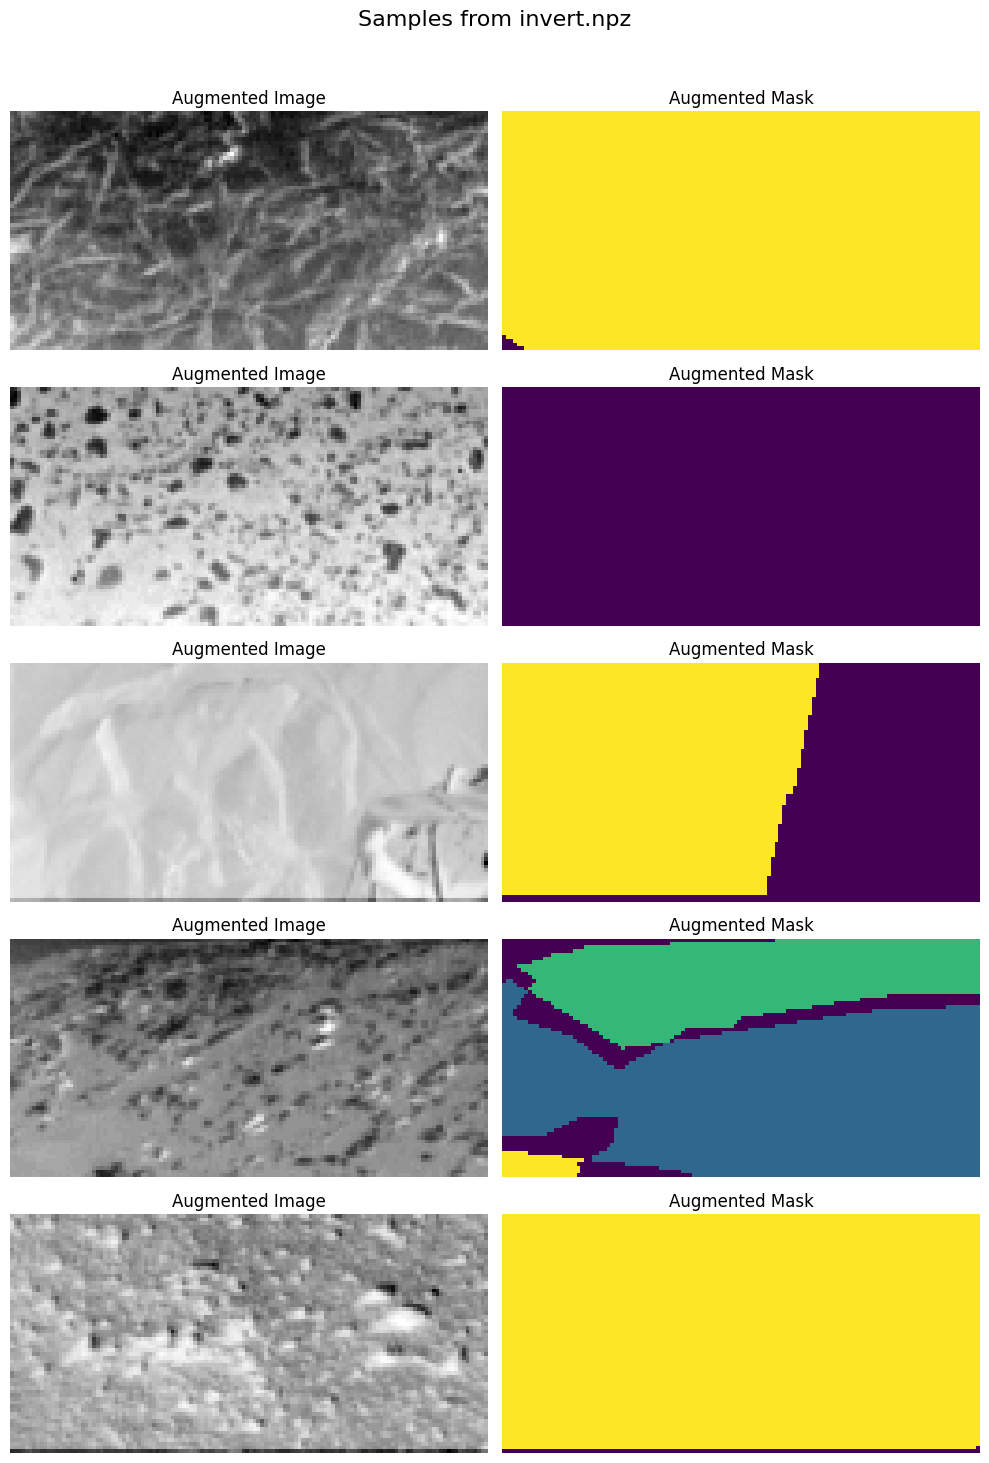

File: rotation_20°.npz
  Key: augmented_images, Shape: (2004, 64, 128)
  Key: augmented_masks, Shape: (2004, 64, 128)


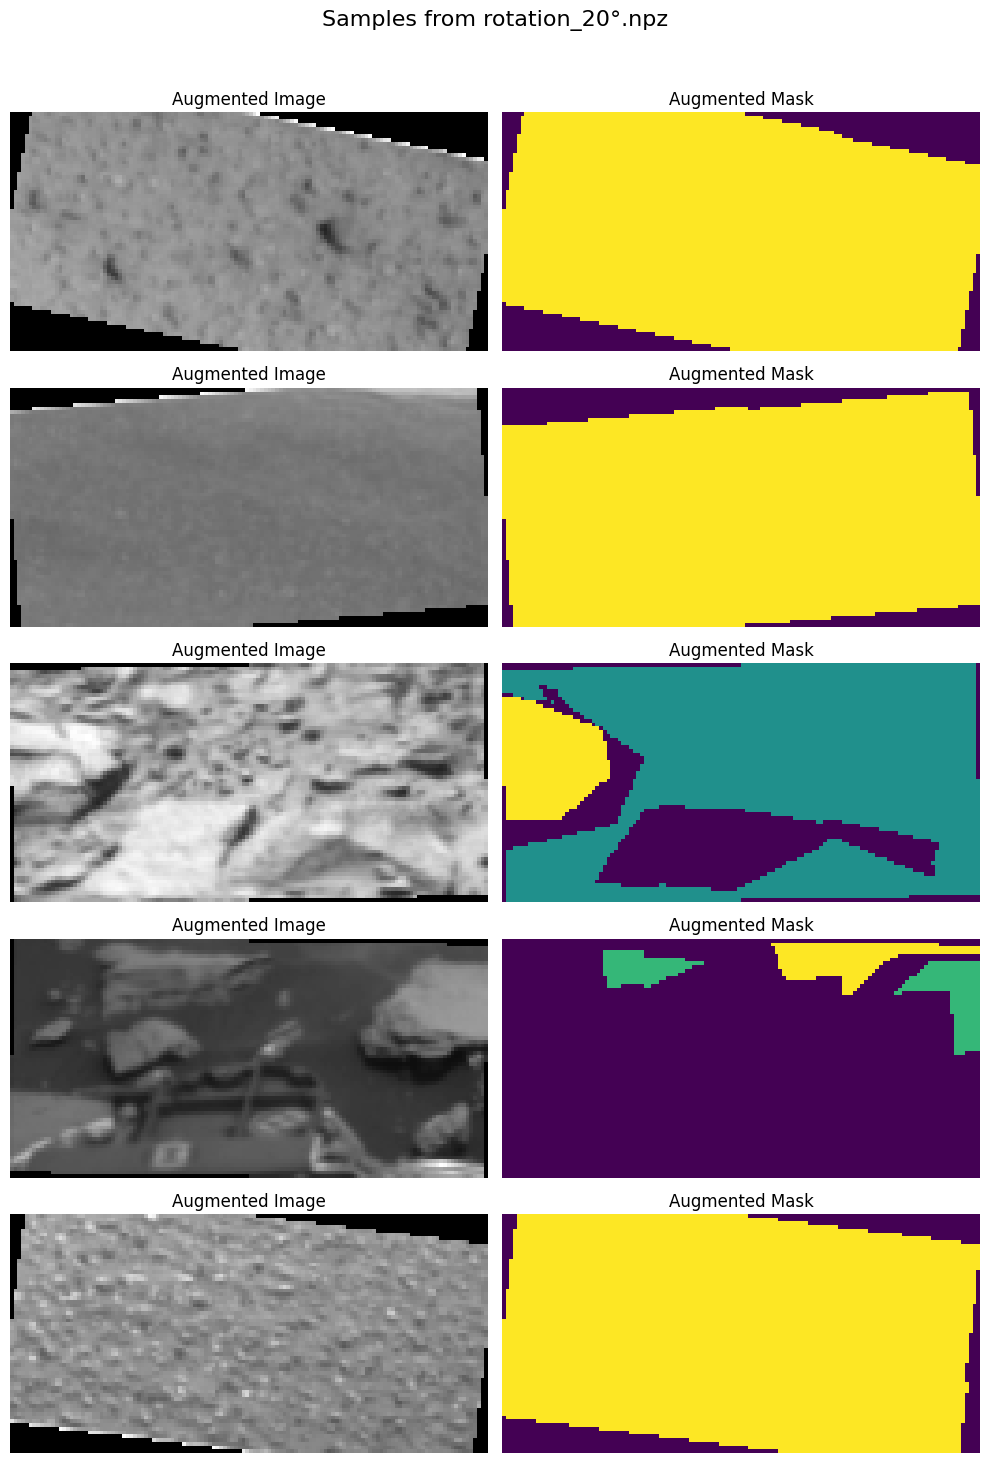

File: noise.npz
  Key: augmented_images, Shape: (2004, 64, 128)
  Key: augmented_masks, Shape: (2004, 64, 128)


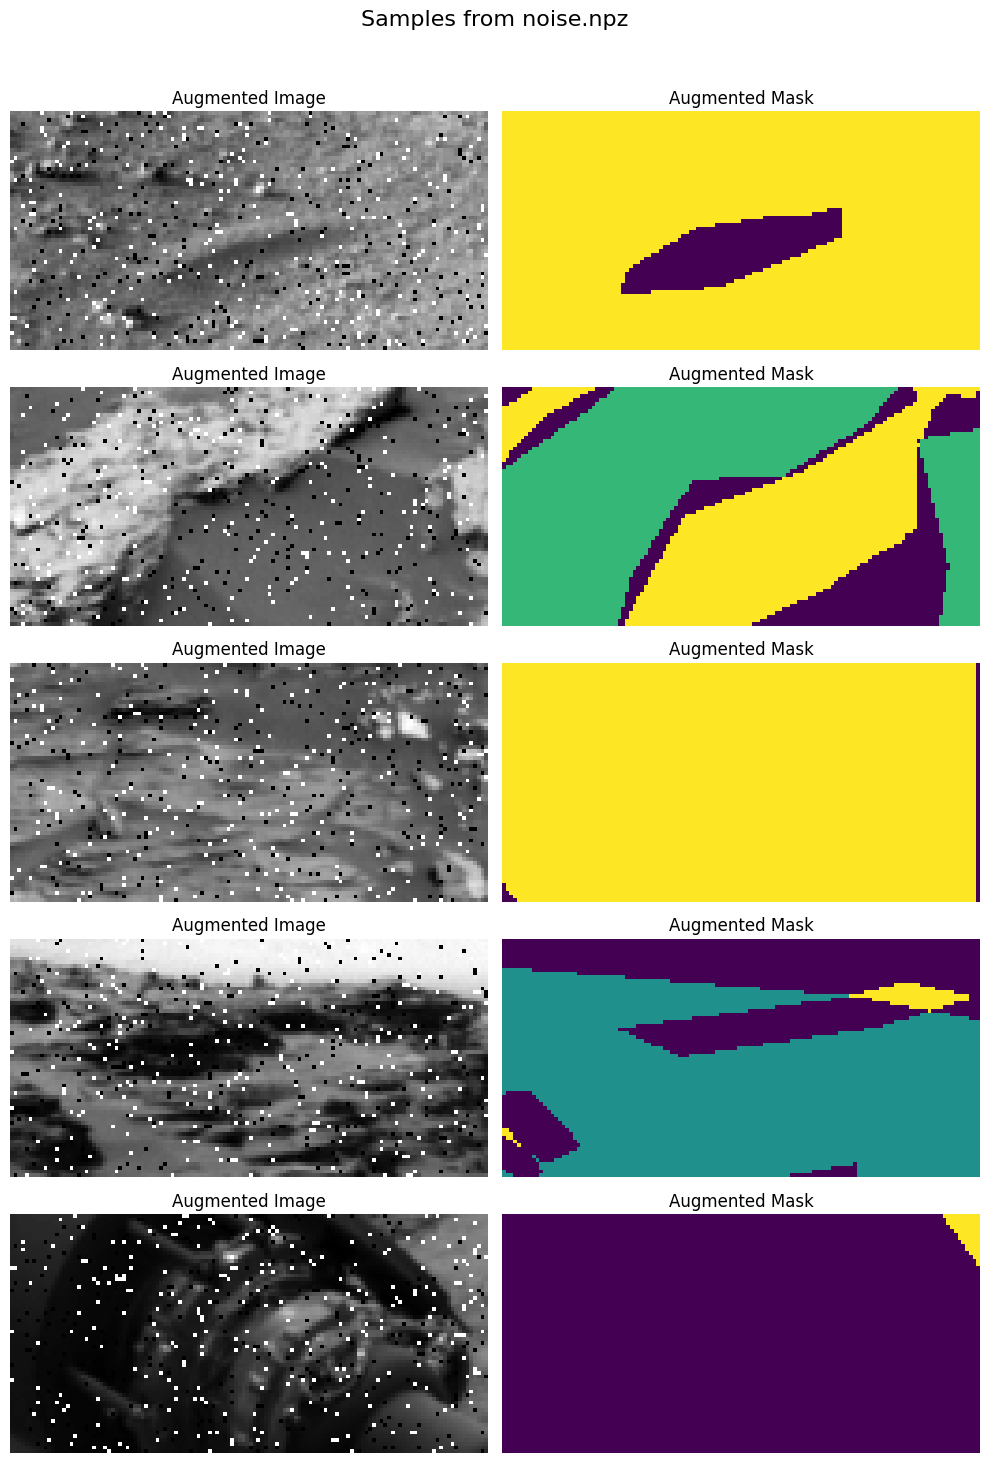

File: horizontal_flip.npz
  Key: augmented_images, Shape: (2004, 64, 128)
  Key: augmented_masks, Shape: (2004, 64, 128)


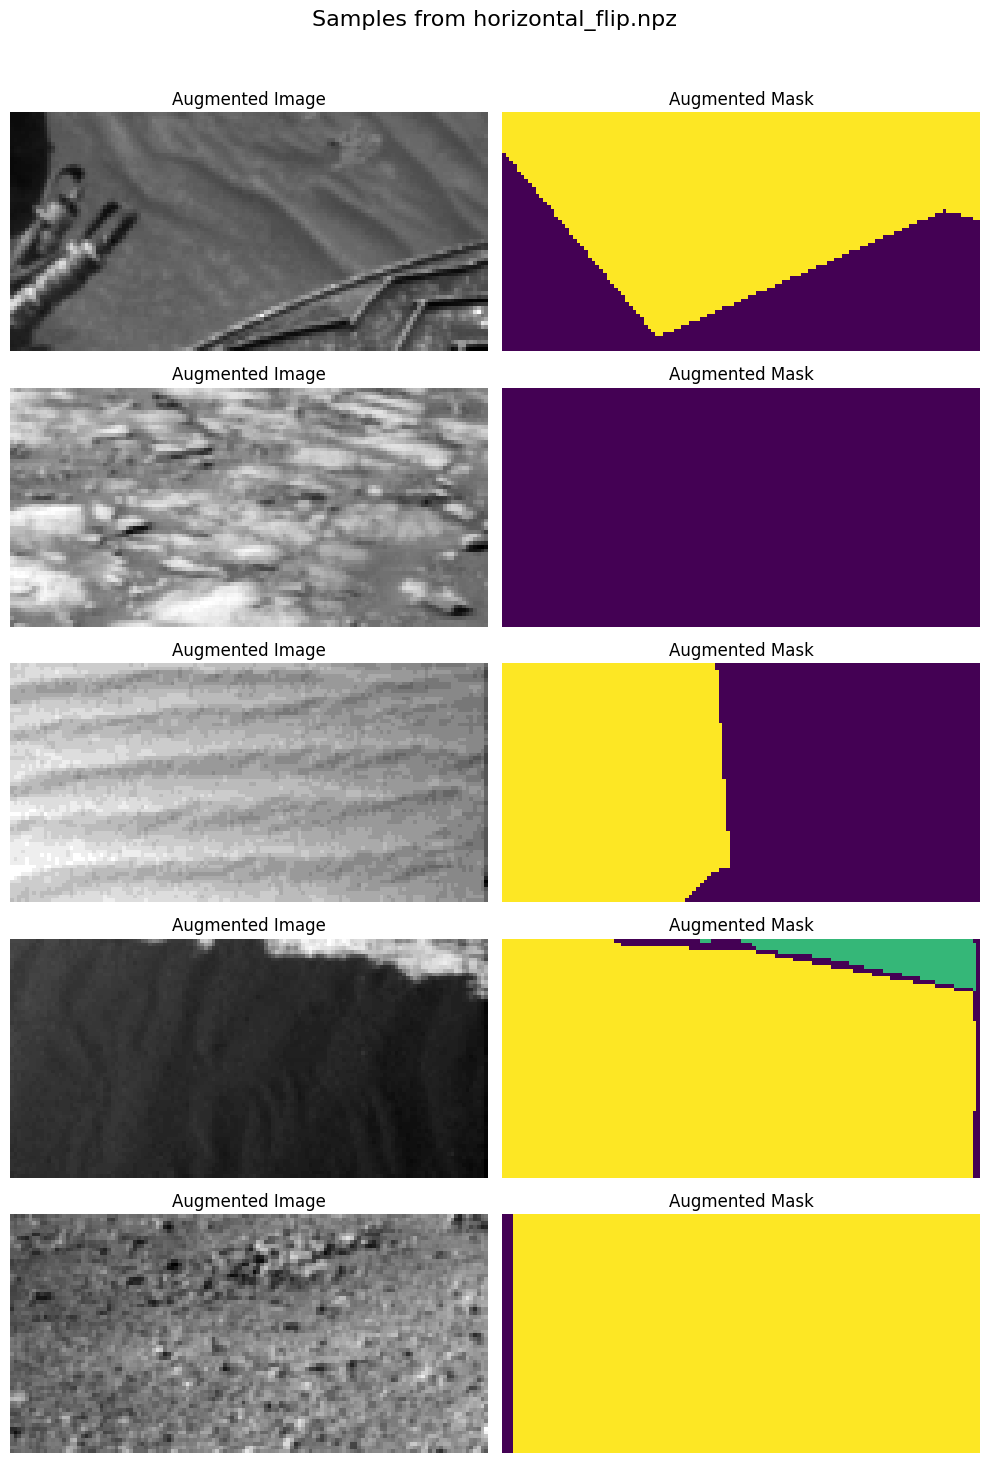

In [14]:
# Read the saved files and display details
output_dir="/kaggle/working/augmented_data"
for file_name in os.listdir(output_dir):
    if file_name.endswith(".npz"):
        file_path = os.path.join(output_dir, file_name)
        data = np.load(file_path)

        # Display keys and their shapes
        print(f"File: {file_name}")
        for key in data.keys():
            print(f"  Key: {key}, Shape: {data[key].shape}")

        # Plot 5 random images and masks
        fig, axes = plt.subplots(5, 2, figsize=(10, 15))
        fig.suptitle(f"Samples from {file_name}", fontsize=16)
        for i in range(5):
            random_idx = np.random.randint(data["augmented_images"].shape[0])
            axes[i, 0].imshow(data["augmented_images"][random_idx], cmap="gray")
            axes[i, 0].set_title("Augmented Image")
            axes[i, 0].axis("off")
            axes[i, 1].imshow(data["augmented_masks"][random_idx])
            axes[i, 1].set_title("Augmented Mask")
            axes[i, 1].axis("off")
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

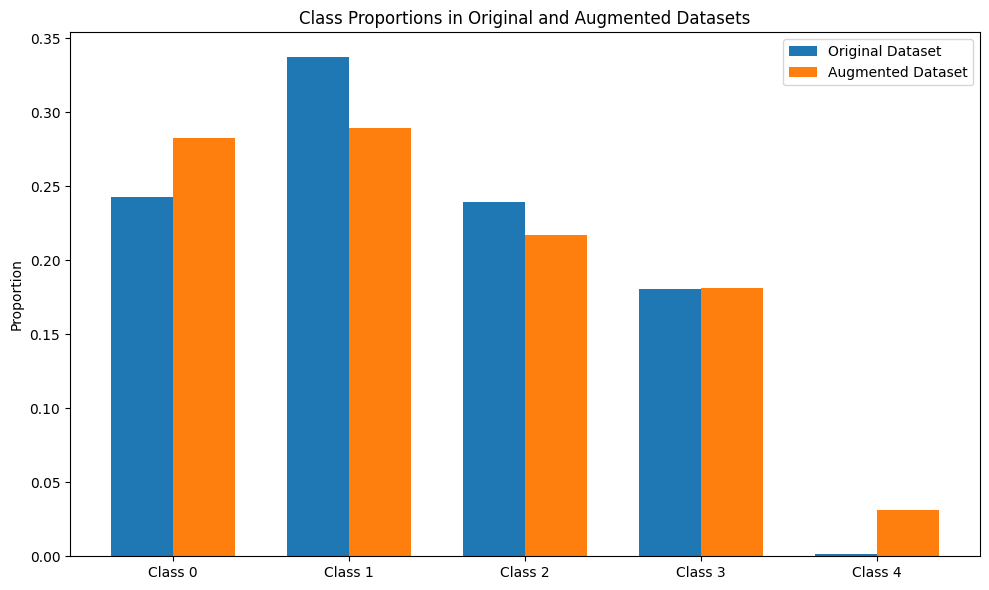

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate class proportions
def calculate_class_proportions(masks, num_classes):
    masks = [mask.astype(int) for mask in masks]  # Ensure masks are integers
    class_counts = np.zeros(num_classes, dtype=np.int64)
    total_pixels = 0

    for mask in masks:
        unique, counts = np.unique(mask, return_counts=True)
        class_counts[unique] += counts
        total_pixels += mask.size

    proportions = class_counts / total_pixels
    return proportions

# Assuming `y_train` and `augmented_y` are your original and augmented datasets
num_classes = 5  # Adjust based on your number of classes
y_train = [mask.astype(np.int32) for mask in y_train]  # Ensure original masks are integers
augmented_y = [mask.astype(np.int32) for mask in augmented_y]  # Ensure augmented masks are integers

original_proportions = calculate_class_proportions(y_train, num_classes)
augmented_proportions = calculate_class_proportions(augmented_y, num_classes)

# Plot the proportions as histograms
x_labels = [f"Class {i}" for i in range(num_classes)]
x_indices = np.arange(len(x_labels))

plt.figure(figsize=(10, 6))
bar_width = 0.35

# Plot original dataset proportions
plt.bar(x_indices - bar_width / 2, original_proportions, bar_width, label="Original Dataset")

# Plot augmented dataset proportions
plt.bar(x_indices + bar_width / 2, augmented_proportions, bar_width, label="Augmented Dataset")

plt.xticks(x_indices, x_labels)
plt.ylabel("Proportion")
plt.title("Class Proportions in Original and Augmented Datasets")
plt.legend()
plt.tight_layout()
plt.show()


## 🛠️ Train and Save the Model

In [16]:
# Load the rotation augmentation dataset
rotation_file_path = os.path.join("/kaggle/working/augmented_data/horizontal_flip.npz")
rotation_data = np.load(rotation_file_path)

# Extract augmented images and masks
augmented_images = rotation_data["augmented_images"]
augmented_masks = rotation_data["augmented_masks"]

# Merge with original X_train and y_train
X_train = np.concatenate([X_train, augmented_images], axis=0)
y_train = np.concatenate([y_train, augmented_masks], axis=0)

# Display the new shapes
print(f"New X_train shape: {X_train.shape}")
print(f"New y_train shape: {y_train.shape}")

New X_train shape: (4008, 64, 128)
New y_train shape: (4008, 64, 128)


In [17]:
# Load the rotation augmentation dataset
rotation_file_path = os.path.join("/kaggle/working/augmented_data/vertical_flip.npz")
rotation_data = np.load(rotation_file_path)

# Extract augmented images and masks
augmented_images = rotation_data["augmented_images"]
augmented_masks = rotation_data["augmented_masks"]

# Merge with original X_train and y_train
X_train = np.concatenate([X_train, augmented_images], axis=0)
y_train = np.concatenate([y_train, augmented_masks], axis=0)

# Display the new shapes
print(f"New X_train shape: {X_train.shape}")
print(f"New y_train shape: {y_train.shape}")

New X_train shape: (6012, 64, 128)
New y_train shape: (6012, 64, 128)


In [18]:
# Load the rotation augmentation dataset
rotation_file_path = os.path.join("/kaggle/working/augmented_data/rotation_20°.npz")
rotation_data = np.load(rotation_file_path)

# Extract augmented images and masks
augmented_images = rotation_data["augmented_images"]
augmented_masks = rotation_data["augmented_masks"]

# Merge with original X_train and y_train
X_train = np.concatenate([X_train, augmented_images], axis=0)
y_train = np.concatenate([y_train, augmented_masks], axis=0)

# Display the new shapes
print(f"New X_train shape: {X_train.shape}")
print(f"New y_train shape: {y_train.shape}")

New X_train shape: (8016, 64, 128)
New y_train shape: (8016, 64, 128)


In [19]:
# Load the rotation augmentation dataset
rotation_file_path = os.path.join("/kaggle/working/augmented_data/invert.npz")
rotation_data = np.load(rotation_file_path)

# Extract augmented images and masks
augmented_images = rotation_data["augmented_images"]
augmented_masks = rotation_data["augmented_masks"]

# Merge with original X_train and y_train
X_train = np.concatenate([X_train, augmented_images], axis=0)
y_train = np.concatenate([y_train, augmented_masks], axis=0)

# Display the new shapes
print(f"New X_train shape: {X_train.shape}")
print(f"New y_train shape: {y_train.shape}")

New X_train shape: (10020, 64, 128)
New y_train shape: (10020, 64, 128)


In [20]:
# Load the rotation augmentation dataset
rotation_file_path = os.path.join("/kaggle/working/augmented_data/noise.npz")
rotation_data = np.load(rotation_file_path)

# Extract augmented images and masks
augmented_images = rotation_data["augmented_images"]
augmented_masks = rotation_data["augmented_masks"]

# Merge with original X_train and y_train
X_train = np.concatenate([X_train, augmented_images], axis=0)
y_train = np.concatenate([y_train, augmented_masks], axis=0)

# Display the new shapes
print(f"New X_train shape: {X_train.shape}")
print(f"New y_train shape: {y_train.shape}")

New X_train shape: (12024, 64, 128)
New y_train shape: (12024, 64, 128)


total number of images 334 out of 12024 images: percentage 2.7777777777777777 %
Class Percentages in Rare Class Masks:
Class 0.0: 46.88%
Class 1.0: 15.87%
Class 2.0: 15.11%
Class 3.0: 17.52%
Class 4.0: 4.61%


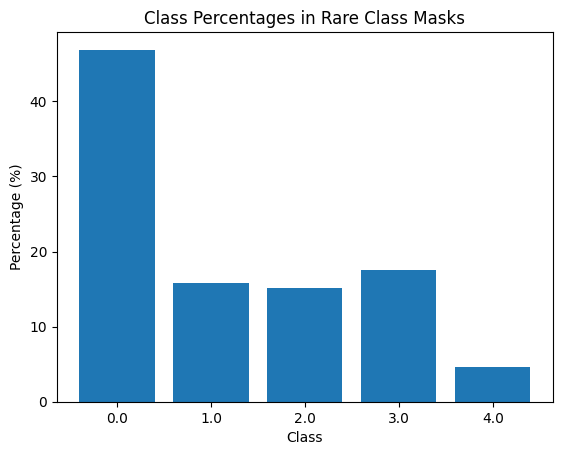

In [21]:
import numpy as np
import matplotlib.pyplot as plt



# Filter only the images with the rare class (class 4)
rare_class = 4
rare_class_indices = [i for i in range(len(y_train)) if rare_class in y_train[i]]
print("total number of images",len(rare_class_indices ),"out of",len(y_train),"images: percentage", 100*len(rare_class_indices )/len(y_train),"%")
# Extract images and masks containing the rare class
X_train_rare = X_train[rare_class_indices]
y_train_rare = y_train[rare_class_indices]

# Calculate the percentage of each class in the rare class masks
unique_classes, class_counts = np.unique(y_train_rare, return_counts=True)
total_pixels = np.sum(class_counts)
class_percentages = {cls: count / total_pixels * 100 for cls, count in zip(unique_classes, class_counts)}

# Print the percentages
print("Class Percentages in Rare Class Masks:")
for cls, pct in class_percentages.items():
    print(f"Class {cls}: {pct:.2f}%")

# Plot histogram of class percentages
plt.bar(class_percentages.keys(), class_percentages.values(), tick_label=list(class_percentages.keys()))
plt.xlabel("Class")
plt.ylabel("Percentage (%)")
plt.title("Class Percentages in Rare Class Masks")
plt.show()


In [22]:
# Load the rotation augmentation dataset
rotation_file_path = os.path.join("/kaggle/working/augmented_dataset.npz")
rotation_data = np.load(rotation_file_path)

# Extract augmented images and masks
augmented_images = rotation_data["X"]
augmented_masks = rotation_data["y"]

# Merge with original X_train and y_train
X_train = np.concatenate([X_train, augmented_images], axis=0)
y_train = np.concatenate([y_train, augmented_masks], axis=0)

# Display the new shapes
print(f"New X_train shape: {X_train.shape}")
print(f"New y_train shape: {y_train.shape}")

New X_train shape: (14462, 64, 128)
New y_train shape: (14462, 64, 128)


## Let's find out about rare class!


total number of images 824 out of 14462 images: percentage 5.697690499239386 %
Class Percentages in Rare Class Masks:
Class 0.0: 46.66%
Class 1.0: 11.15%
Class 2.0: 13.16%
Class 3.0: 18.01%
Class 4.0: 11.02%


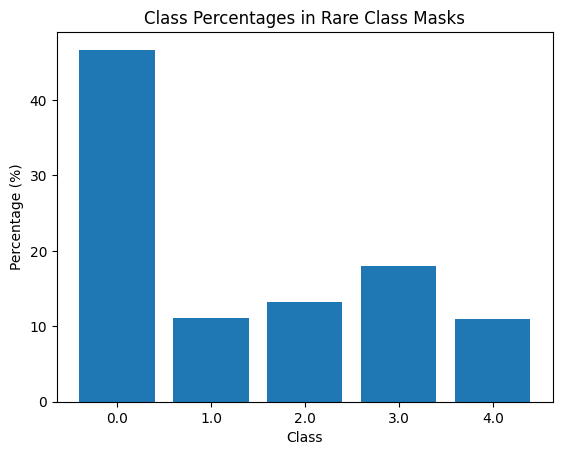

In [23]:
import numpy as np
import matplotlib.pyplot as plt



# Filter only the images with the rare class (class 4)
rare_class = 4
rare_class_indices = [i for i in range(len(y_train)) if rare_class in y_train[i]]
print("total number of images",len(rare_class_indices ),"out of",len(y_train),"images: percentage", 100*len(rare_class_indices )/len(y_train),"%")
# Extract images and masks containing the rare class
X_train_rare = X_train[rare_class_indices]
y_train_rare = y_train[rare_class_indices]

# Calculate the percentage of each class in the rare class masks
unique_classes, class_counts = np.unique(y_train_rare, return_counts=True)
total_pixels = np.sum(class_counts)
class_percentages = {cls: count / total_pixels * 100 for cls, count in zip(unique_classes, class_counts)}

# Print the percentages
print("Class Percentages in Rare Class Masks:")
for cls, pct in class_percentages.items():
    print(f"Class {cls}: {pct:.2f}%")

# Plot histogram of class percentages
plt.bar(class_percentages.keys(), class_percentages.values(), tick_label=list(class_percentages.keys()))
plt.xlabel("Class")
plt.ylabel("Percentage (%)")
plt.title("Class Percentages in Rare Class Masks")
plt.show()


Total images with rare class: 824
Minimum rare class percentage: 0.01%
Maximum rare class percentage: 90.04%
Average percentage in top 20% rare-class images: 37.14%


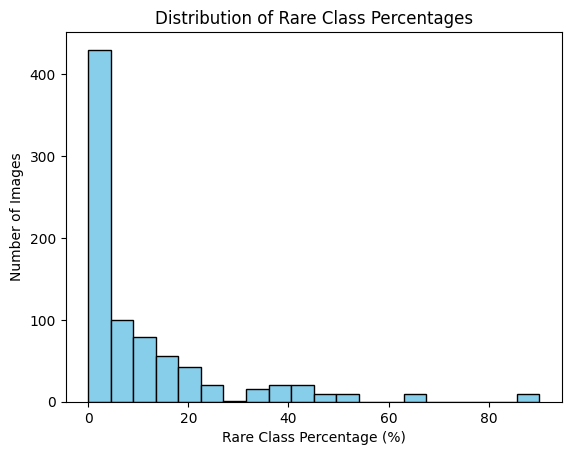

In [24]:
# Filter only the images with the rare class (class 4)
rare_class = 4
rare_class_indices = [i for i in range(len(y_train)) if rare_class in y_train[i]]

# Extract images and masks containing the rare class
X_train_rare = X_train[rare_class_indices]
y_train_rare = y_train[rare_class_indices]

# Calculate the percentage of the rare class in each mask
rare_class_percentages = [
    (np.sum(mask == rare_class) / mask.size) * 100 for mask in y_train_rare
]

# Identify images with the highest rare class percentages
sorted_indices = np.argsort(rare_class_percentages)[::-1]
top_20_percent_indices = sorted_indices[: len(sorted_indices) // 5]
top_20_percent_average = np.mean([rare_class_percentages[i] for i in top_20_percent_indices])

# Calculate min and max percentages
min_percentage = np.min(rare_class_percentages)
max_percentage = np.max(rare_class_percentages)

# Print results
print(f"Total images with rare class: {len(rare_class_indices)}")
print(f"Minimum rare class percentage: {min_percentage:.2f}%")
print(f"Maximum rare class percentage: {max_percentage:.2f}%")
print(f"Average percentage in top 20% rare-class images: {top_20_percent_average:.2f}%")

# Plot histogram of rare class percentages
plt.hist(rare_class_percentages, bins=20, color='skyblue', edgecolor='black')
plt.xlabel("Rare Class Percentage (%)")
plt.ylabel("Number of Images")
plt.title("Distribution of Rare Class Percentages")
plt.show()

Class Percentages in Rare Class Masks:
Class 0.0: 45.32%
Class 1.0: 2.83%
Class 2.0: 9.58%
Class 3.0: 32.46%
Class 4.0: 9.82%


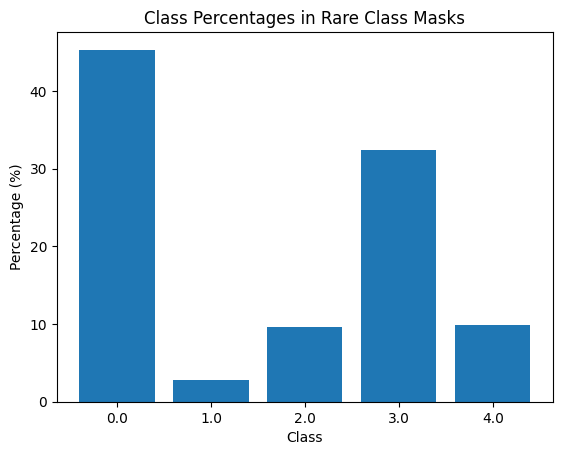

In [25]:
import numpy as np
import matplotlib.pyplot as plt


# Filter only the images with the rare class (class 4)
rare_class = 4
rare_class_indices = [i for i in range(len(y_val)) if rare_class in y_val[i]]

# Extract images and masks containing the rare class
X_val_rare = X_val[rare_class_indices]
y_val_rare = y_val[rare_class_indices]

# Calculate the percentage of each class in the rare class masks
unique_classes, class_counts = np.unique(y_val_rare, return_counts=True)
total_pixels = np.sum(class_counts)
class_percentages = {cls: count / total_pixels * 100 for cls, count in zip(unique_classes, class_counts)}

# Print the percentages
print("Class Percentages in Rare Class Masks:")
for cls, pct in class_percentages.items():
    print(f"Class {cls}: {pct:.2f}%")

# Plot histogram of class percentages
plt.bar(class_percentages.keys(), class_percentages.values(), tick_label=list(class_percentages.keys()))
plt.xlabel("Class")
plt.ylabel("Percentage (%)")
plt.title("Class Percentages in Rare Class Masks")
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
X_train_top_20_percent=X_train[top_20_percent_indices]
y_train_top_20_percent=y_train[top_20_percent_indices]
print(len(X_train_top_20_percent))
# Augmentation settings
data_gen_args = dict(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)
datagen = ImageDataGenerator(**data_gen_args)

# Augment rare class training images
X_train_aug = []
y_train_aug = []
for x, y in zip(X_train_top_20_percent, y_train_top_20_percent):
    x = np.expand_dims(x, axis=-1) if x.ndim == 2 else x
    for _ in range(5):  # Create 5 augmented samples per image
        augmented = next(datagen.flow(x[np.newaxis, ...], batch_size=1))
        X_train_aug.append(augmented[0])
        y_train_aug.append(y)

X_train_aug = np.array(X_train_aug)
y_train_aug = np.array(y_train_aug)

print(f"Augmented Training Set: {X_train_aug.shape}, {y_train_aug.shape}")


total number of images 7 out of 501 images: percentage 1.3972055888223553 %

Class Percentages in Rare Class Masks (Validation):
Class 0.0: 45.32%
Class 1.0: 2.83%
Class 2.0: 9.58%
Class 3.0: 32.46%
Class 4.0: 9.82%

Rare Class Statistics in Validation Images:
Mean Percentage: 9.82%
Min Percentage: 0.45%
Max Percentage: 26.61%


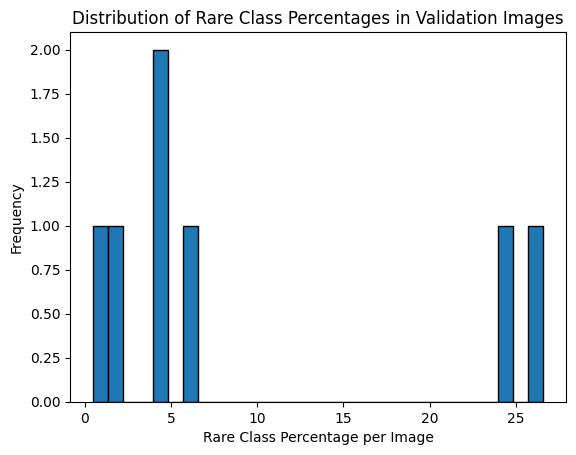

In [26]:
# Filter images with the rare class in the validation set
rare_class_value = 4  # Define the rare class value
rare_class_val_indices = [i for i in range(len(y_val)) if rare_class_value in y_val[i]]
print("total number of images",len(rare_class_val_indices ),"out of",len(y_val),"images: percentage", 100*len(rare_class_val_indices )/len(y_val),"%")
# Extract validation images and masks containing the rare class
X_val_rare = X_val[rare_class_val_indices]
y_val_rare = y_val[rare_class_val_indices]

# Calculate the percentage of each class in the rare class masks for validation
unique_classes_val, class_counts_val = np.unique(y_val_rare, return_counts=True)
total_pixels_val = np.sum(class_counts_val)
class_percentages_val = {cls: count / total_pixels_val * 100 for cls, count in zip(unique_classes_val, class_counts_val)}

# Print validation class percentages
print("\nClass Percentages in Rare Class Masks (Validation):")
for cls, pct in class_percentages_val.items():
    print(f"Class {cls}: {pct:.2f}%")

# Calculate rare class percentage per validation image
rare_class_percentages_per_image_val = [
    (np.sum(y == rare_class_value) / y.size) * 100 for y in y_val_rare
]

# Statistics on rare class percentages in validation images
mean_rare_class_val = np.mean(rare_class_percentages_per_image_val)
min_rare_class_val = np.min(rare_class_percentages_per_image_val)
max_rare_class_val = np.max(rare_class_percentages_per_image_val)

print(f"\nRare Class Statistics in Validation Images:")
print(f"Mean Percentage: {mean_rare_class_val:.2f}%")
print(f"Min Percentage: {min_rare_class_val:.2f}%")
print(f"Max Percentage: {max_rare_class_val:.2f}%")

# Sort validation images by rare class pixel count
sorted_indices_val = np.argsort(rare_class_percentages_per_image_val)[::-1]
X_val_top_20_percent = X_val_rare[sorted_indices_val[:2]]
y_val_top_20_percent = y_val_rare[sorted_indices_val[:2]]

# Plot histogram for validation rare class percentages
plt.hist(rare_class_percentages_per_image_val, bins=30, edgecolor="black")
plt.xlabel("Rare Class Percentage per Image")
plt.ylabel("Frequency")
plt.title("Distribution of Rare Class Percentages in Validation Images")
plt.show()

## Normalization


In [27]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [28]:
X_val = X_val[..., np.newaxis] / 255.0

In [29]:
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (14462, 64, 128, 1)
X_val shape: (501, 64, 128, 1)
y_train shape: (14462, 64, 128)


In [30]:
# Custom callback for visualization
class VisualizeSegmentationCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_train, y_train, num_images=2):
        super().__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.num_images = num_images
        self.selected_indices = []

        # Identify images containing at least 4 classes
        for i in range(len(y_train)):
            if len(np.unique(y_train[i])) >= 4:  # Check for at least 4 classes
                self.selected_indices.append(i)
            if len(self.selected_indices) == num_images:
                break

    def on_epoch_end(self, epoch, logs=None):
        # Plot predictions for the selected images
        fig, axes = plt.subplots(self.num_images, 3, figsize=(15, self.num_images * 5))

        for idx, i in enumerate(self.selected_indices):
            # Extract image and ground truth
            X_sample = self.X_train[i:i + 1]  # Add batch dimension
            y_sample = self.y_train[i]

            # Predict on the image
            predicted_mask = self.model.predict(X_sample)
            predicted_mask = np.argmax(predicted_mask, axis=-1)[0]  # Convert to class labels

            # Visualize the input, ground truth, and predicted mask
            axes[idx, 0].imshow(X_sample[0].squeeze(), cmap="gray")
            axes[idx, 0].set_title("Input Image")
            axes[idx, 0].axis("off")

            axes[idx, 1].imshow(y_sample, cmap="viridis",vmin=0,vmax=4)
            axes[idx, 1].set_title("Ground Truth Mask")
            axes[idx, 1].axis("off")

            axes[idx, 2].imshow(predicted_mask, cmap="viridis",vmin=0,vmax=4)
            axes[idx, 2].set_title(f"Predicted Mask (Epoch {epoch + 1})")
            axes[idx, 2].axis("off")

        plt.tight_layout()
        plt.show()

## Adding advanced tecnics

In [31]:
# Ensure the input shape for both images and masks is correct
X_train = np.squeeze(X_train)  # Remove any singleton dimensions
y_train = np.squeeze(y_train)  # Remove any singleton dimensions

# Check if the channel dimension exists, otherwise add it
if X_train.ndim == 3:  # If missing the channel dimension, add it
    X_train = X_train[..., np.newaxis]

if y_train.ndim == 3:  # Ensure y_train has the correct shape
    y_train = y_train[..., np.newaxis]

print(f"Shape of X_train after reshaping: {X_train.shape}")
print(f"Shape of y_train after reshaping: {y_train.shape}")

Shape of X_train after reshaping: (14462, 64, 128, 1)
Shape of y_train after reshaping: (14462, 64, 128, 1)


In [32]:
# Ensure the input shape for both images and masks is correct
X_val = np.squeeze(X_val)  # Remove any singleton dimensions
y_val= np.squeeze(y_val)  # Remove any singleton dimensions

# Check if the channel dimension exists, otherwise add it
if X_val.ndim == 3:  # If missing the channel dimension, add it
    X_val = X_val[..., np.newaxis]

if y_val.ndim == 3:  # Ensure y_train has the correct shape
    y_val = y_val[..., np.newaxis]

print(f"Shape of X_train after reshaping: {X_val.shape}")
print(f"Shape of y_train after reshaping: {y_val.shape}")

Shape of X_train after reshaping: (501, 64, 128, 1)
Shape of y_train after reshaping: (501, 64, 128, 1)


In [33]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Ensure the input shape for both images and masks is correct
X_train = np.squeeze(X_train)  # Remove singleton dimensions
if X_train.ndim == 3:  # If missing the channel dimension, add it
    X_train = X_train[..., np.newaxis]

y_train = np.squeeze(y_train)  # Ensure that y_train has the correct shape

print(f"Shape of X_train after reshaping: {X_train.shape}")
print(f"Shape of y_train after reshaping: {y_train.shape}")

# Convert y_train to integers for class count
y_train_int = y_train.astype(np.int32)

# Calculate class weights based on pixel proportions
class_pixel_counts = np.bincount(y_train_int.flatten(), minlength=num_classes)  # Count pixels for each class
total_pixels = np.sum(class_pixel_counts)  # Total number of pixels
class_weights = total_pixels / (class_pixel_counts + 1e-6)  # Inverse frequency
class_weights /= np.sum(class_weights)  # Normalize to sum to 1

print(f"Class pixel counts: {class_pixel_counts}")
print(f"Calculated class weights: {class_weights}")

# Updated EarlyStopping with min_delta to ignore minimal improvements
early_stopping = EarlyStopping(
    monitor="val_loss",  # Monitor loss instead of validation loss
    patience=30,
    restore_best_weights=True,
    min_delta=1e-4  # Minimum change to qualify as an improvement
)


model_checkpoint = ModelCheckpoint(
    filepath="best_model.keras",
    monitor="val_loss",  # Monitor loss instead of validation loss
    save_best_only=True,
    mode="min",
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",  # Monitor loss instead of validation loss
    factor=0.5,
    patience=5,
    verbose=1,
    mode="min",
    min_lr=1e-6
)

# Visualization Callback for Two Images with At Least 4 Classes
visualize_callback = VisualizeSegmentationCallback(X_val, y_val, num_images=2)




Shape of X_train after reshaping: (14462, 64, 128, 1)
Shape of y_train after reshaping: (14462, 64, 128)
Class pixel counts: [30721682 38430351 27502248 21074756   743667]
Calculated class weights: [0.02188888 0.01749823 0.02445121 0.03190847 0.9042532 ]


In [34]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

In [35]:
from tensorflow.keras.callbacks import Callback
class SaveBestMeanIoU(Callback):
    def __init__(self, filepath, monitor="val_mean_io_u", mode="max", verbose=1):
        super(SaveBestMeanIoU, self).__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.mode = mode
        self.verbose = verbose
        self.best = -float("inf") if mode == "max" else float("inf")

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        # Debug: Print available keys in logs
        print(f"Available log keys: {logs.keys()}")
        
        # Use the correct log key
        current = logs.get(self.monitor)
        if current is None:
            if self.verbose > 0:
                print(f"Warning: Monitor '{self.monitor}' is not available in logs.")
            return

        if (self.mode == "max" and current > self.best) or (self.mode == "min" and current < self.best):
            self.best = current
            if self.verbose > 0:
                print(f"Epoch {epoch + 1}: {self.monitor} improved to {current:.4f}, saving model.")
            self.model.save(self.filepath)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 128,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 128,   │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 64, 128,   │        128 │ conv2d[0][0]      │
│ (LayerNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 64, 128,   │          0 │ layer_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 128,   │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 128,   │        128 │ conv2d_1[0][0]    │
│ (LayerNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, 128,   │          0 │ layer_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 128,   │        128 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 128,   │          0 │ activation_1[0][… │
│                     │ 64)               │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 64,    │          0 │ add[0][0]         │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 32, 64,    │        256 │ conv2d_3[0][0]    │
│ (LayerNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32, 64,    │          0 │ layer_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 64,    │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 32, 64,    │        256 │ conv2d_4[0][0]    │
│ (LayerNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 32, 64,    │          0 │ layer_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 64,    │      8,320 │ max_pooling2d[0]

 Total params: 7,359,941 (28.08 MB)

 Trainable params: 7,359,941 (28.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000


I0000 00:00:1733865001.305529     102 service.cc:145] XLA service 0x7ea9a80018b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733865001.305580     102 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733865001.305586     102 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1733865024.135470     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.3577 - loss: 0.8697 - mean_iou: 0.1438Available log keys: dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou'])
Epoch 1: val_mean_iou improved to 0.2680, saving model.

Epoch 1: val_loss improved from inf to 0.81973, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


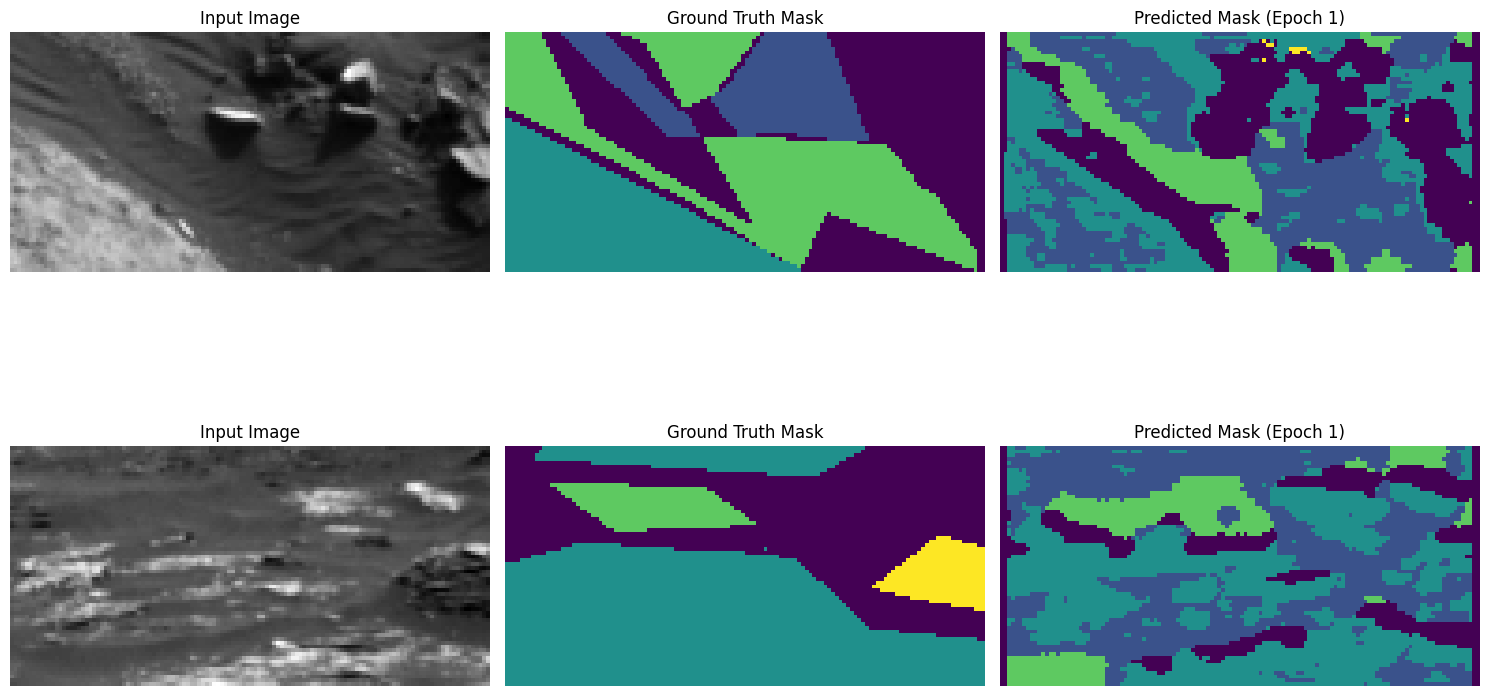

452/452 ━━━━━━━━━━━━━━━━━━━━ 160s 279ms/step - accuracy: 0.3578 - loss: 0.8696 - mean_iou: 0.1439 - val_accuracy: 0.5046 - val_loss: 0.8197 - val_mean_iou: 0.2680 - learning_rate: 0.0010
Epoch 2/1000
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.4987 - loss: 0.8218 - mean_iou: 0.2612Available log keys: dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou'])
Epoch 2: val_mean_iou improved to 0.3326, saving model.

Epoch 2: val_loss improved from 0.81973 to 0.79912, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


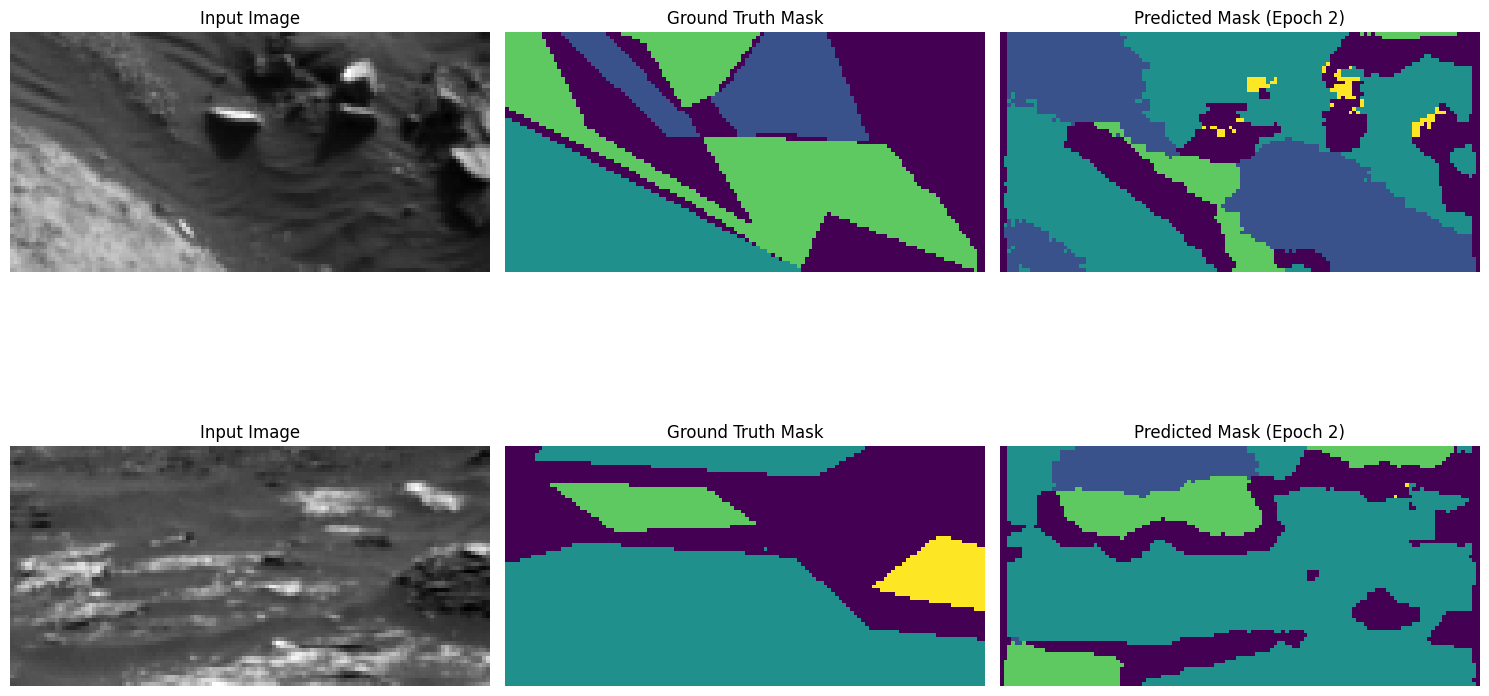

452/452 ━━━━━━━━━━━━━━━━━━━━ 94s 208ms/step - accuracy: 0.4987 - loss: 0.8218 - mean_iou: 0.2612 - val_accuracy: 0.5804 - val_loss: 0.7991 - val_mean_iou: 0.3326 - learning_rate: 0.0010
Epoch 3/1000
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.5920 - loss: 0.7942 - mean_iou: 0.3368Available log keys: dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou'])
Epoch 3: val_mean_iou improved to 0.3681, saving model.

Epoch 3: val_loss improved from 0.79912 to 0.78121, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


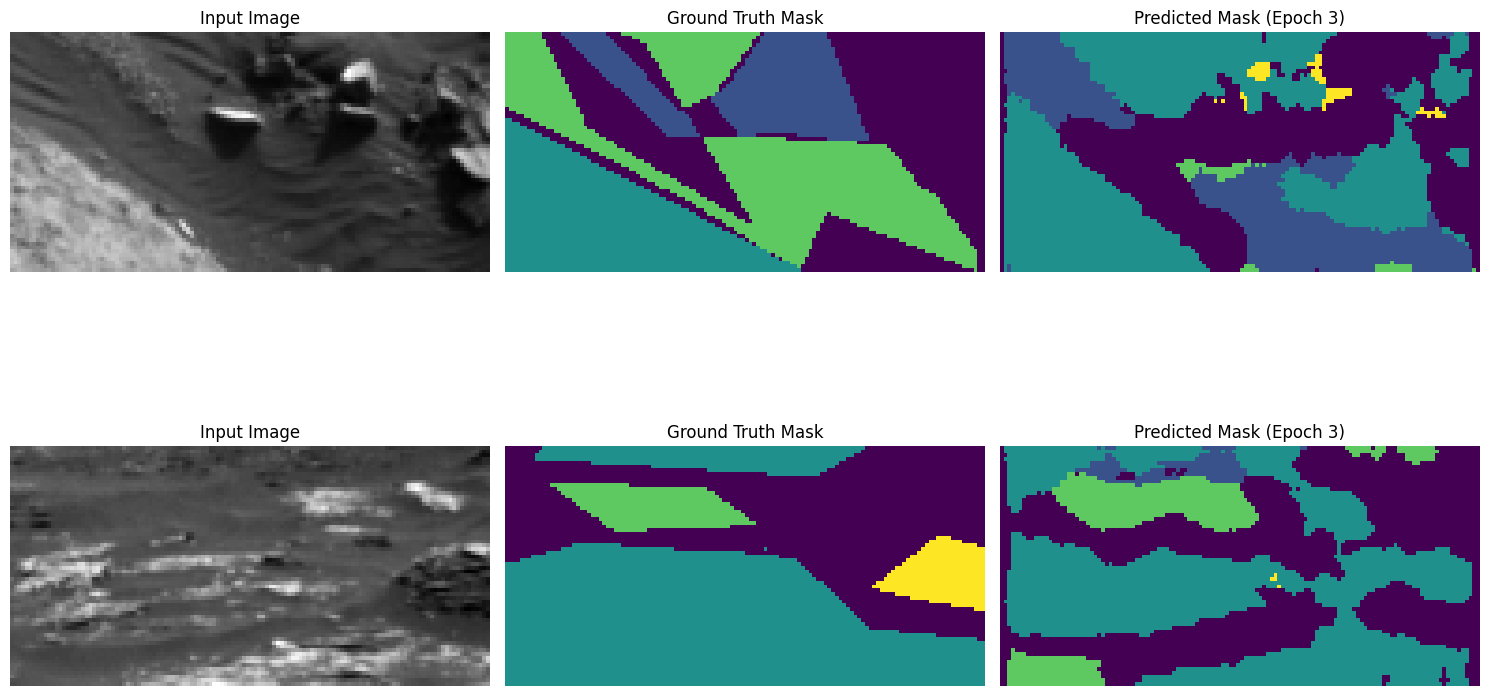

452/452 ━━━━━━━━━━━━━━━━━━━━ 94s 208ms/step - accuracy: 0.5921 - loss: 0.7942 - mean_iou: 0.3368 - val_accuracy: 0.6405 - val_loss: 0.7812 - val_mean_iou: 0.3681 - learning_rate: 0.0010
Epoch 4/1000
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.6325 - loss: 0.7812 - mean_iou: 0.3818Available log keys: dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou'])
Epoch 4: val_mean_iou improved to 0.4059, saving model.

Epoch 4: val_loss improved from 0.78121 to 0.77000, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


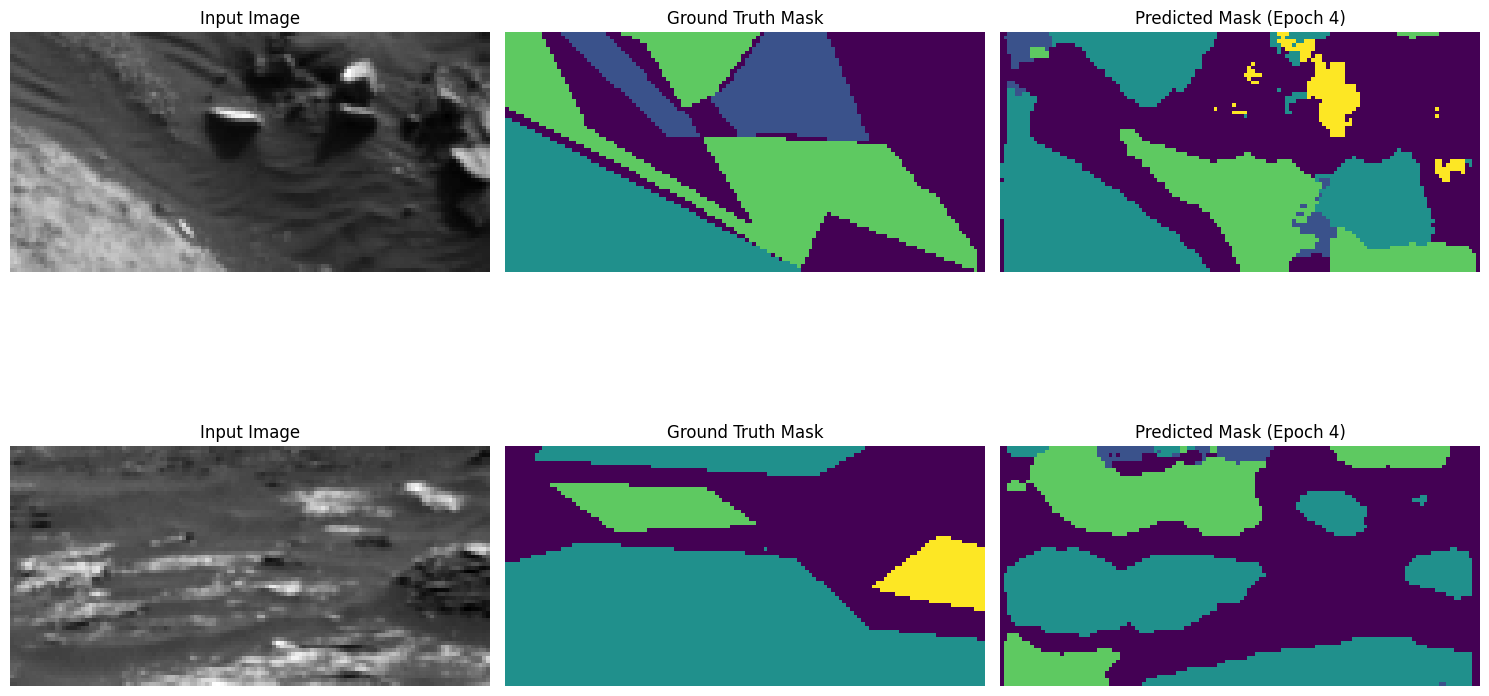

452/452 ━━━━━━━━━━━━━━━━━━━━ 94s 208ms/step - accuracy: 0.6325 - loss: 0.7812 - mean_iou: 0.3817 - val_accuracy: 0.6714 - val_loss: 0.7700 - val_mean_iou: 0.4059 - learning_rate: 0.0010
Epoch 5/1000
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.6575 - loss: 0.7711 - mean_iou: 0.4176Available log keys: dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou'])
Epoch 5: val_mean_iou improved to 0.4133, saving model.

Epoch 5: val_loss did not improve from 0.77000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


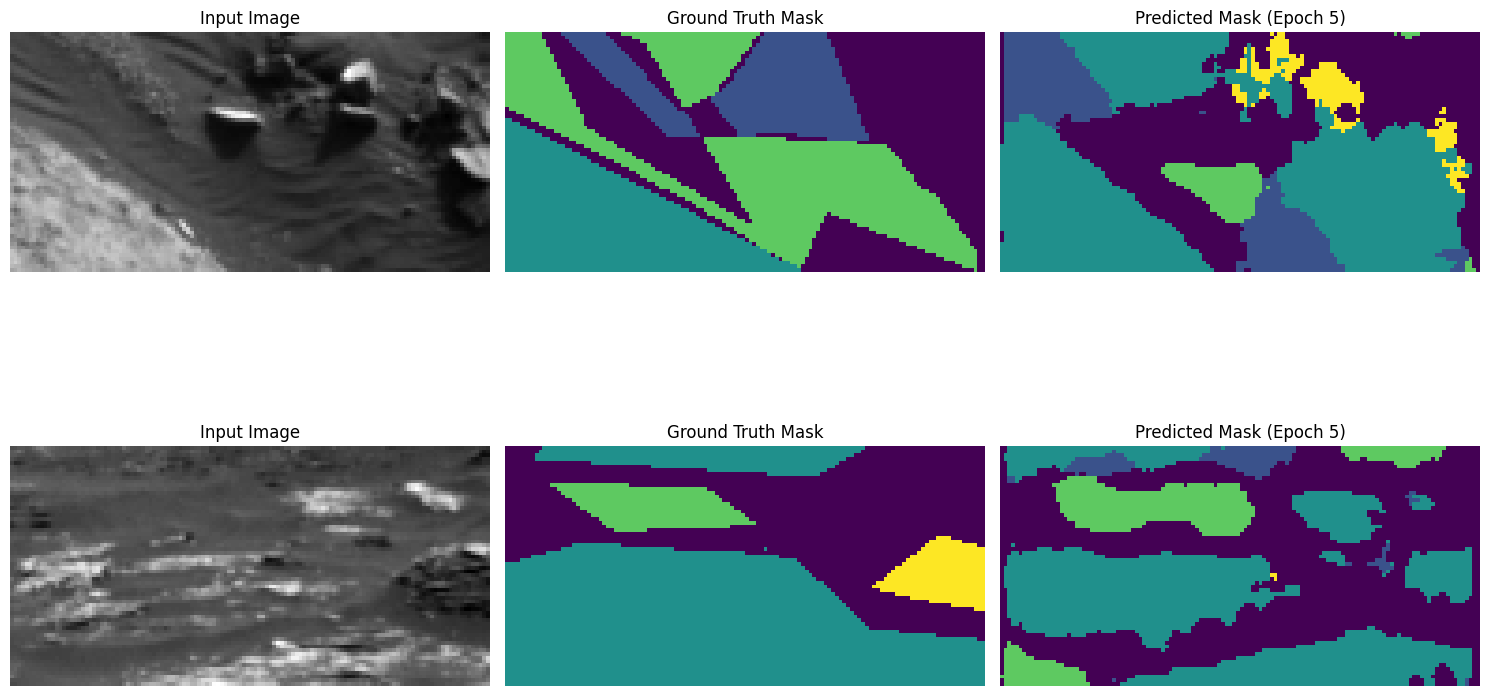

452/452 ━━━━━━━━━━━━━━━━━━━━ 93s 207ms/step - accuracy: 0.6575 - loss: 0.7711 - mean_iou: 0.4175 - val_accuracy: 0.6796 - val_loss: 0.7713 - val_mean_iou: 0.4133 - learning_rate: 0.0010
Epoch 6/1000
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.6730 - loss: 0.7653 - mean_iou: 0.4374Available log keys: dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou'])
Epoch 6: val_mean_iou improved to 0.4269, saving model.

Epoch 6: val_loss improved from 0.77000 to 0.76257, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


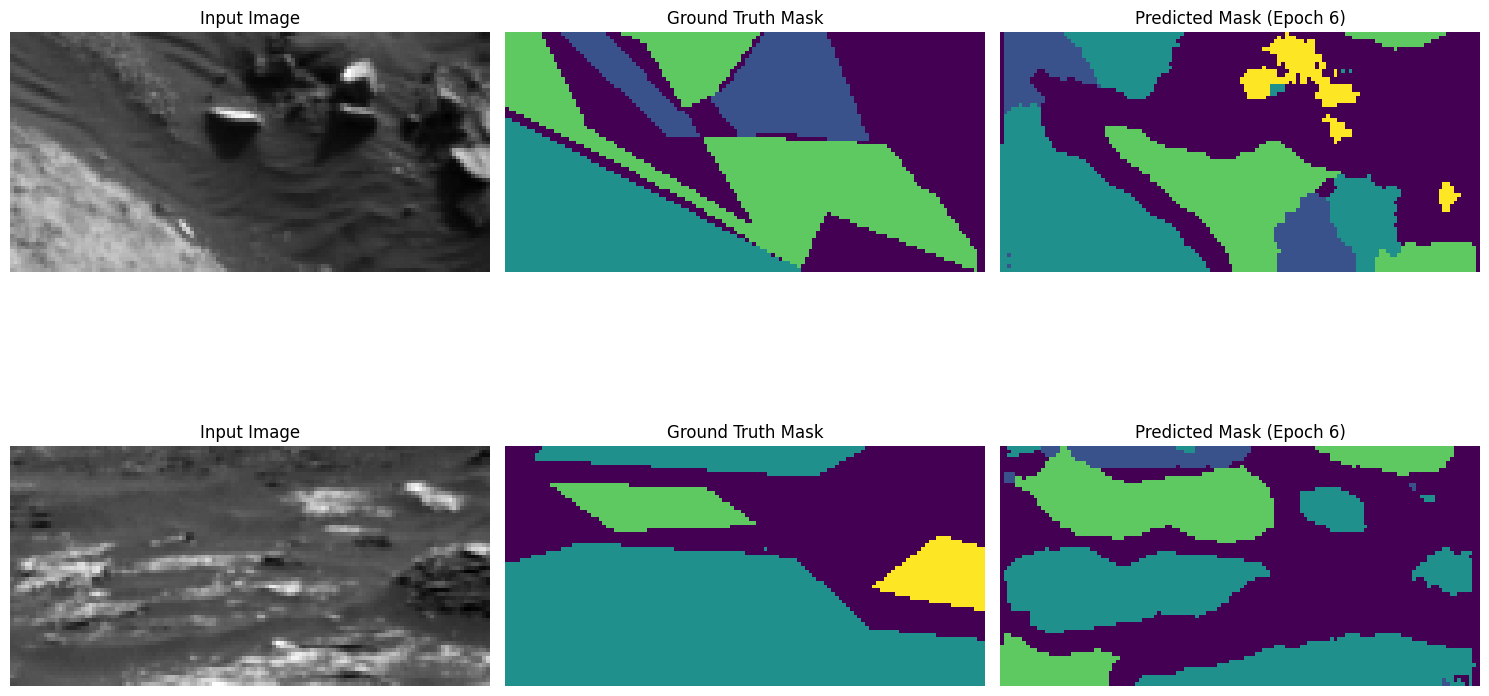

452/452 ━━━━━━━━━━━━━━━━━━━━ 94s 208ms/step - accuracy: 0.6731 - loss: 0.7653 - mean_iou: 0.4374 - val_accuracy: 0.6967 - val_loss: 0.7626 - val_mean_iou: 0.4269 - learning_rate: 0.0010
Epoch 7/1000
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.6888 - loss: 0.7592 - mean_iou: 0.4573Available log keys: dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou'])

Epoch 7: val_loss improved from 0.76257 to 0.76117, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


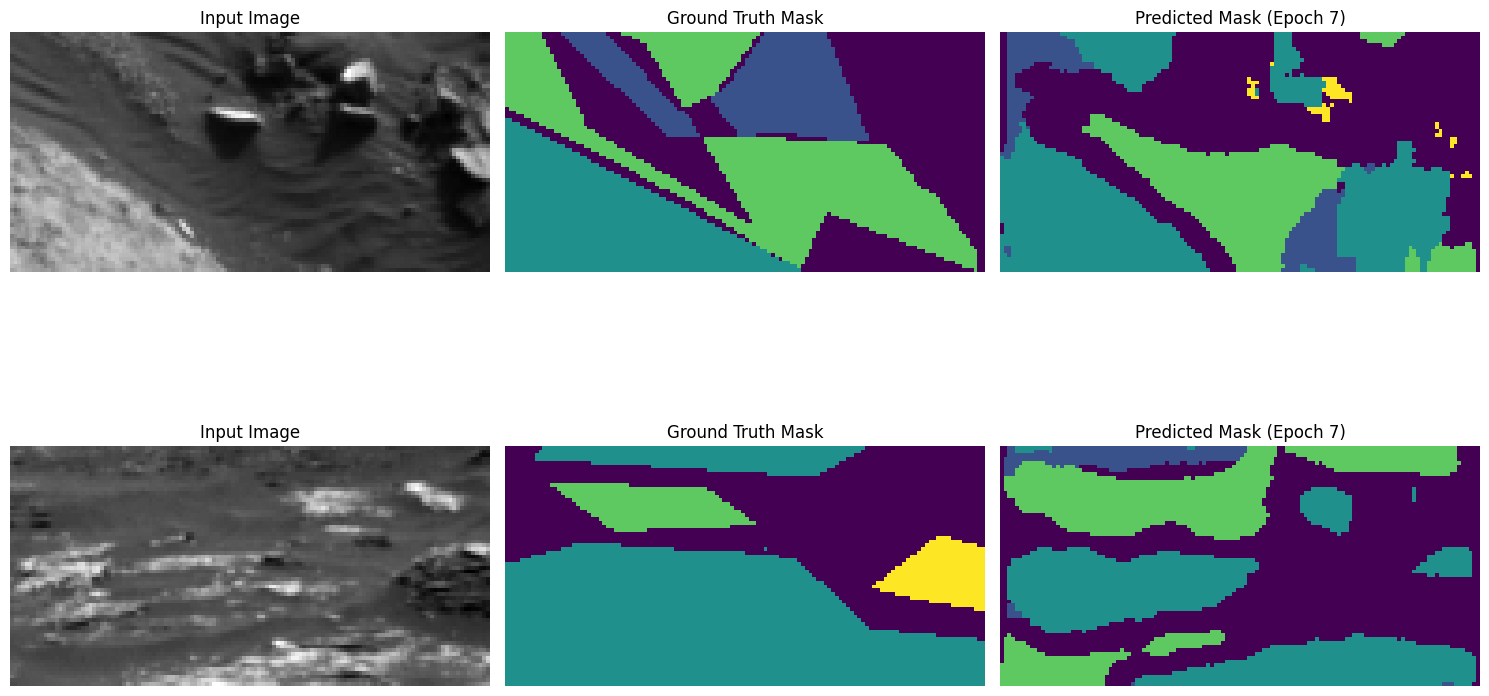

452/452 ━━━━━━━━━━━━━━━━━━━━ 94s 208ms/step - accuracy: 0.6888 - loss: 0.7592 - mean_iou: 0.4573 - val_accuracy: 0.7015 - val_loss: 0.7612 - val_mean_iou: 0.4224 - learning_rate: 0.0010
Epoch 8/1000
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.6933 - loss: 0.7560 - mean_iou: 0.4724Available log keys: dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou'])

Epoch 8: val_loss did not improve from 0.76117
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


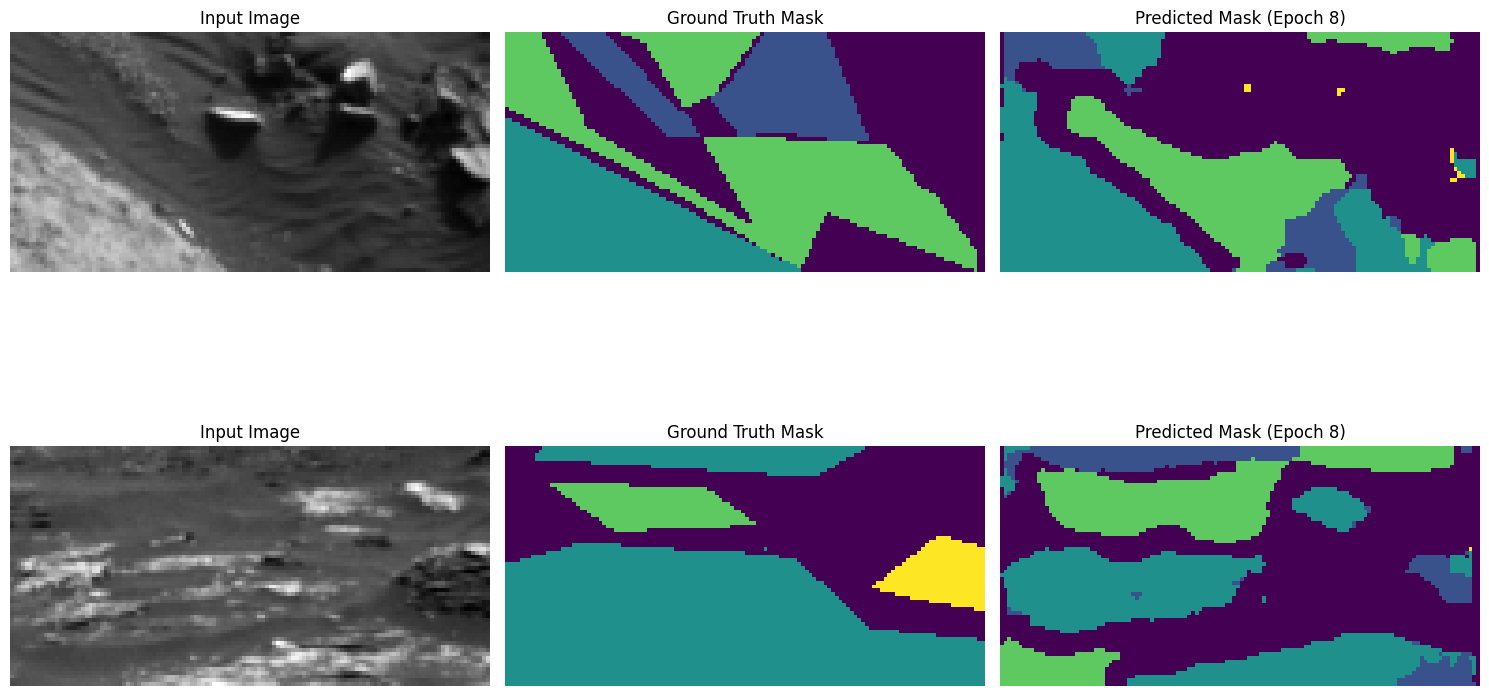

452/452 ━━━━━━━━━━━━━━━━━━━━ 93s 206ms/step - accuracy: 0.6934 - loss: 0.7560 - mean_iou: 0.4723 - val_accuracy: 0.7014 - val_loss: 0.7617 - val_mean_iou: 0.4228 - learning_rate: 0.0010
Epoch 9/1000
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.7086 - loss: 0.7495 - mean_iou: 0.4900Available log keys: dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou'])
Epoch 9: val_mean_iou improved to 0.4452, saving model.

Epoch 9: val_loss improved from 0.76117 to 0.75449, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


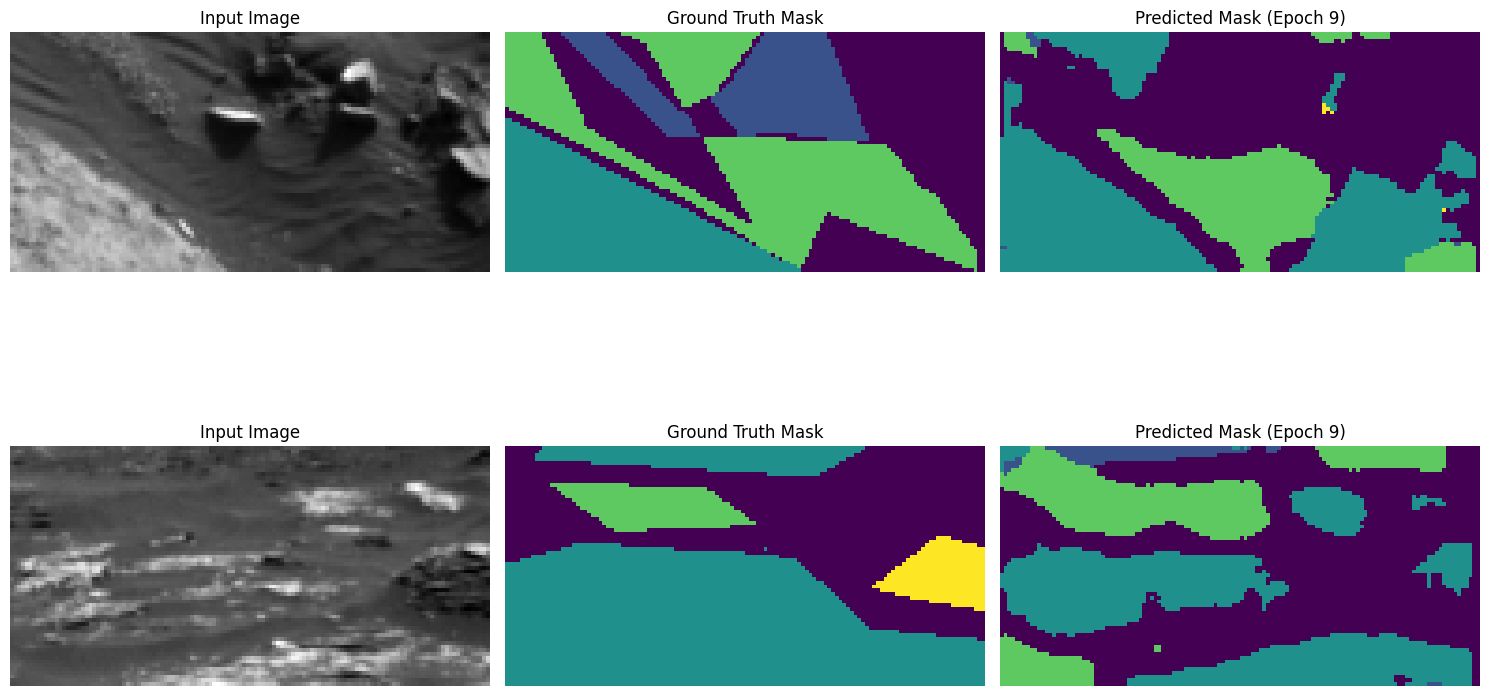

452/452 ━━━━━━━━━━━━━━━━━━━━ 94s 208ms/step - accuracy: 0.7086 - loss: 0.7495 - mean_iou: 0.4900 - val_accuracy: 0.7320 - val_loss: 0.7545 - val_mean_iou: 0.4452 - learning_rate: 0.0010
Epoch 10/1000
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.7183 - loss: 0.7452 - mean_iou: 0.5036Available log keys: dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou'])

Epoch 10: val_loss did not improve from 0.75449
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


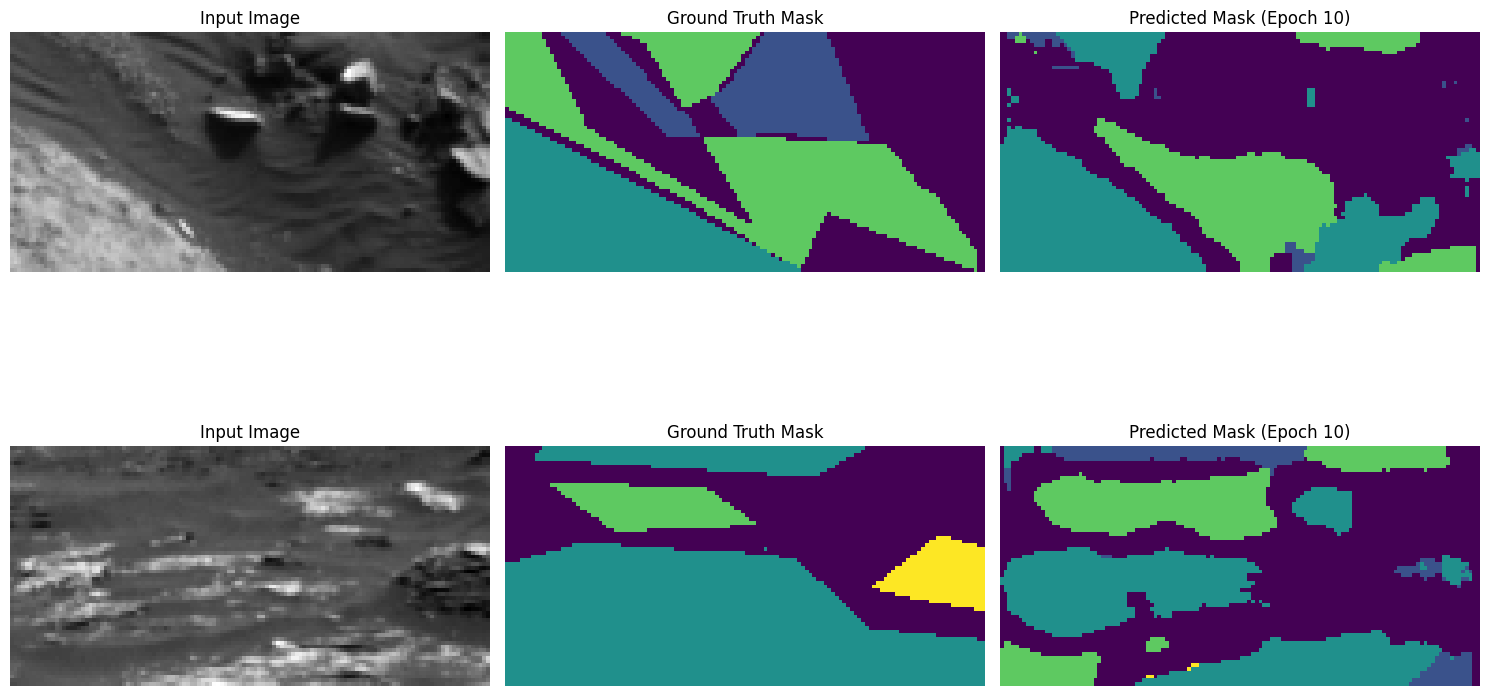

452/452 ━━━━━━━━━━━━━━━━━━━━ 93s 206ms/step - accuracy: 0.7183 - loss: 0.7452 - mean_iou: 0.5035 - val_accuracy: 0.7192 - val_loss: 0.7569 - val_mean_iou: 0.4301 - learning_rate: 0.0010
Epoch 11/1000
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.7246 - loss: 0.7408 - mean_iou: 0.5170Available log keys: dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou'])
Epoch 11: val_mean_iou improved to 0.4514, saving model.

Epoch 11: val_loss improved from 0.75449 to 0.75385, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


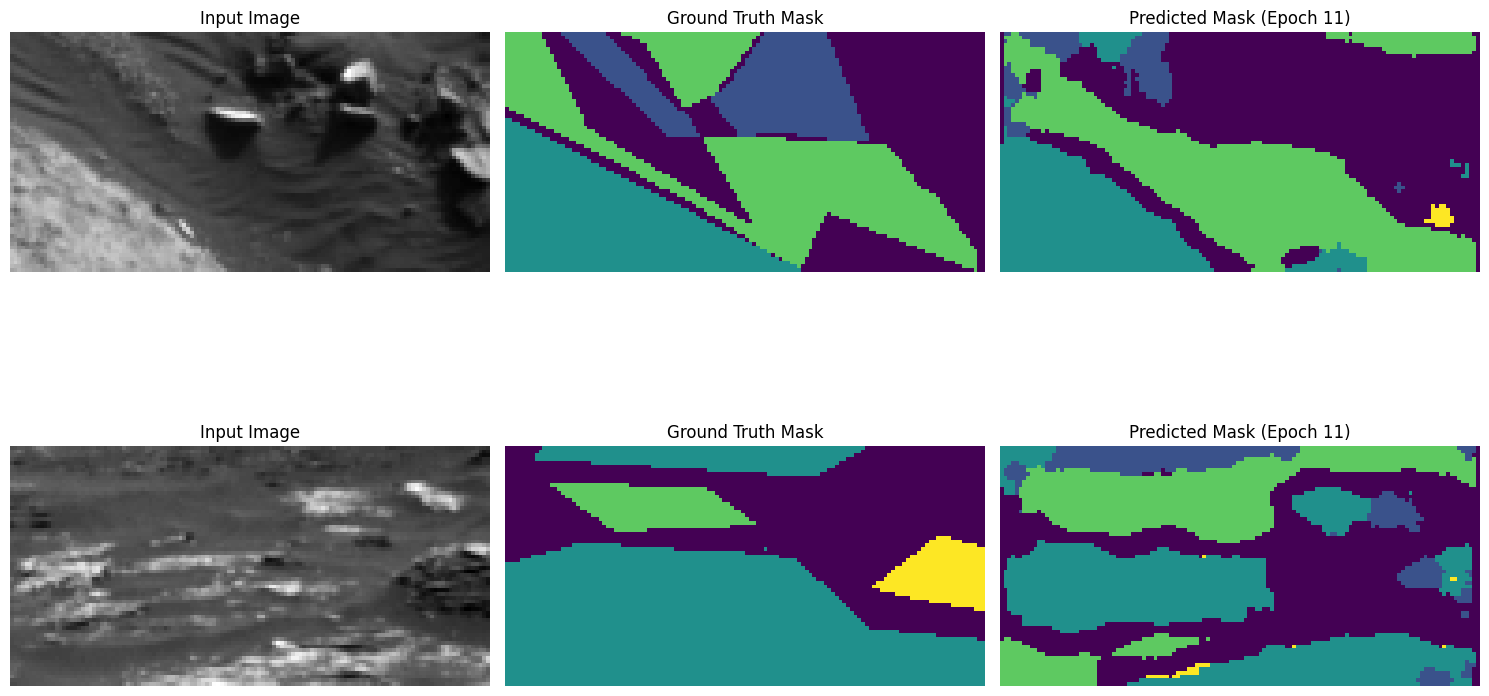

452/452 ━━━━━━━━━━━━━━━━━━━━ 94s 208ms/step - accuracy: 0.7246 - loss: 0.7408 - mean_iou: 0.5170 - val_accuracy: 0.7288 - val_loss: 0.7538 - val_mean_iou: 0.4514 - learning_rate: 0.0010
Epoch 12/1000
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.7321 - loss: 0.7365 - mean_iou: 0.5296Available log keys: dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou'])

Epoch 12: val_loss did not improve from 0.75385
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


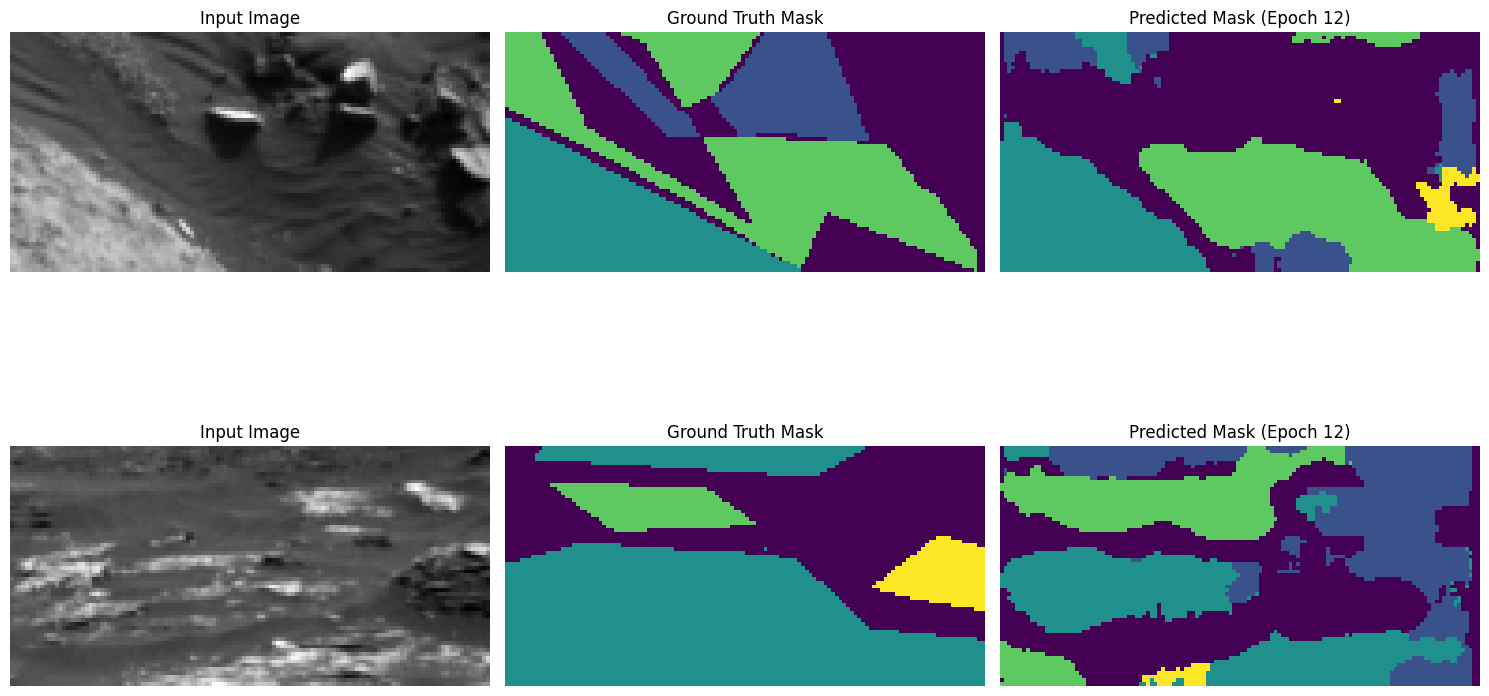

452/452 ━━━━━━━━━━━━━━━━━━━━ 93s 206ms/step - accuracy: 0.7321 - loss: 0.7365 - mean_iou: 0.5295 - val_accuracy: 0.7192 - val_loss: 0.7567 - val_mean_iou: 0.4423 - learning_rate: 0.0010
Epoch 13/1000
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.7394 - loss: 0.7326 - mean_iou: 0.5454Available log keys: dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou'])

Epoch 13: val_loss improved from 0.75385 to 0.75260, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


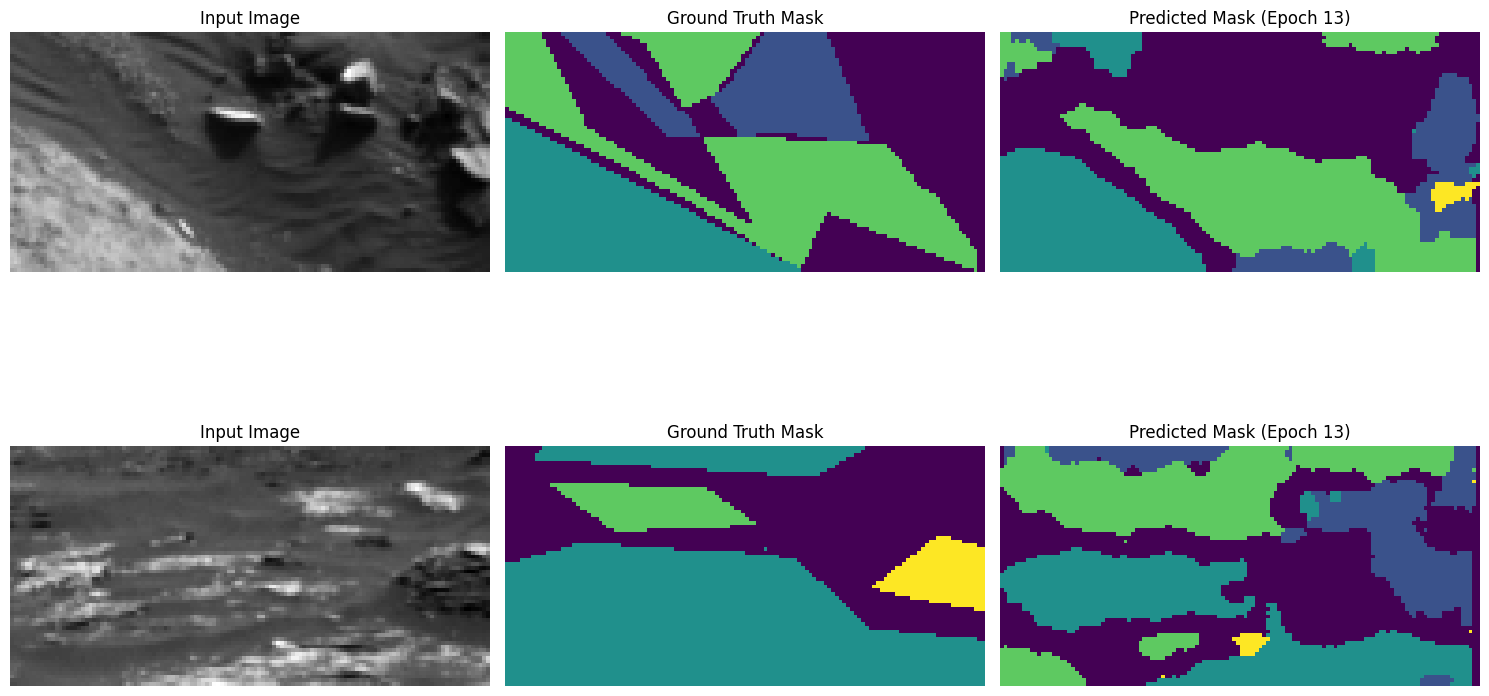

452/452 ━━━━━━━━━━━━━━━━━━━━ 94s 207ms/step - accuracy: 0.7395 - loss: 0.7326 - mean_iou: 0.5453 - val_accuracy: 0.7349 - val_loss: 0.7526 - val_mean_iou: 0.4494 - learning_rate: 0.0010
Epoch 14/1000
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.7490 - loss: 0.7274 - mean_iou: 0.5539Available log keys: dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou'])
Epoch 14: val_mean_iou improved to 0.4683, saving model.

Epoch 14: val_loss improved from 0.75260 to 0.74891, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


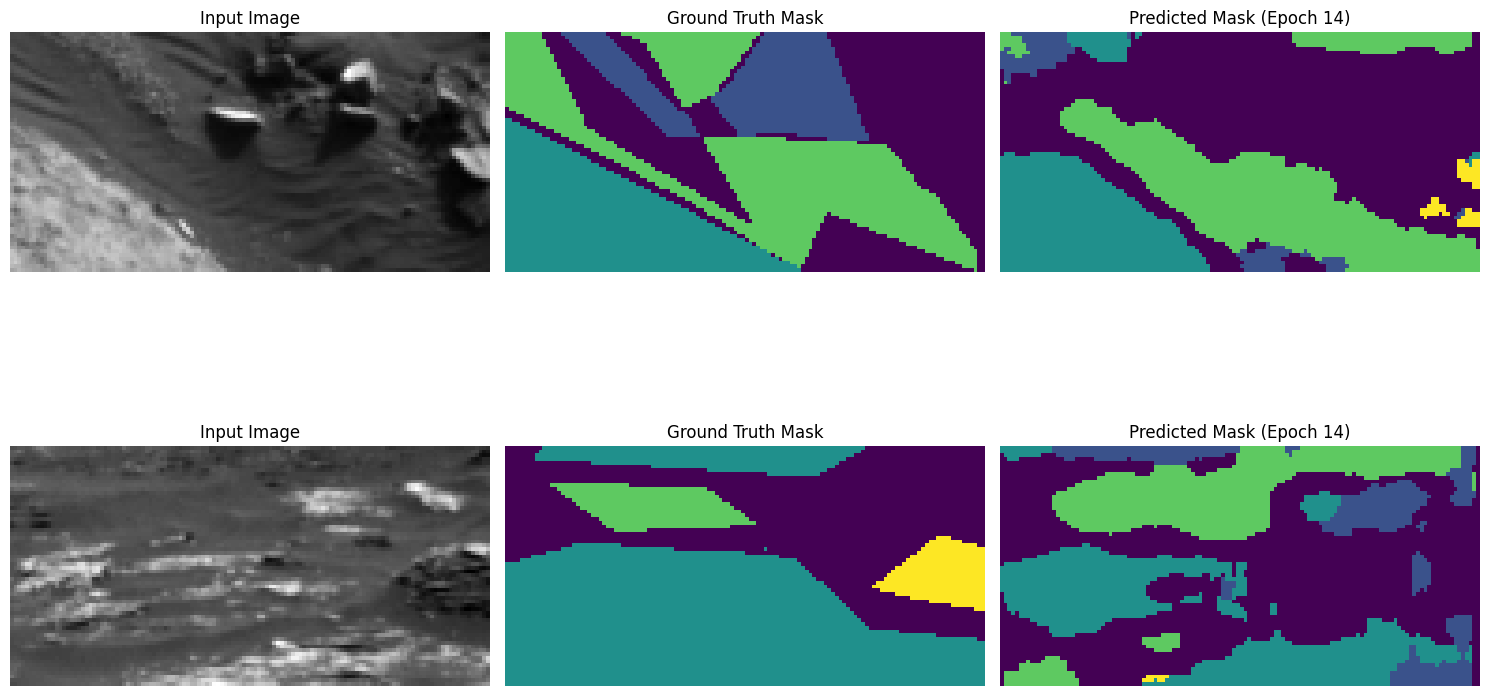

452/452 ━━━━━━━━━━━━━━━━━━━━ 94s 208ms/step - accuracy: 0.7491 - loss: 0.7274 - mean_iou: 0.5538 - val_accuracy: 0.7475 - val_loss: 0.7489 - val_mean_iou: 0.4683 - learning_rate: 0.0010
Epoch 15/1000
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.7597 - loss: 0.7216 - mean_iou: 0.5736Available log keys: dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou'])

Epoch 15: val_loss improved from 0.74891 to 0.74738, saving model to best_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


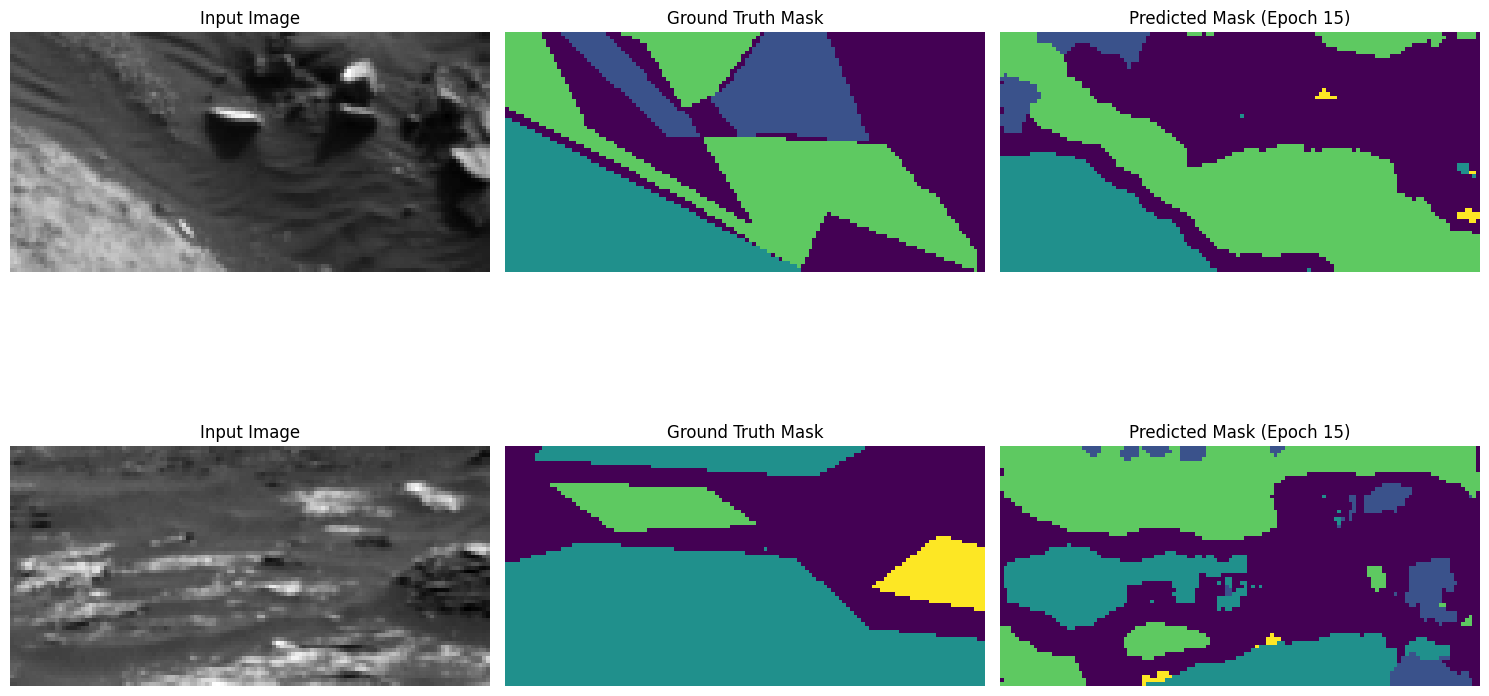

452/452 ━━━━━━━━━━━━━━━━━━━━ 94s 207ms/step - accuracy: 0.7597 - loss: 0.7216 - mean_iou: 0.5736 - val_accuracy: 0.7506 - val_loss: 0.7474 - val_mean_iou: 0.4631 - learning_rate: 0.0010
Epoch 16/1000
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.7662 - loss: 0.7178 - mean_iou: 0.5682Available log keys: dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou'])
Epoch 16: val_mean_iou improved to 0.4684, saving model.

Epoch 16: val_loss did not improve from 0.74738
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


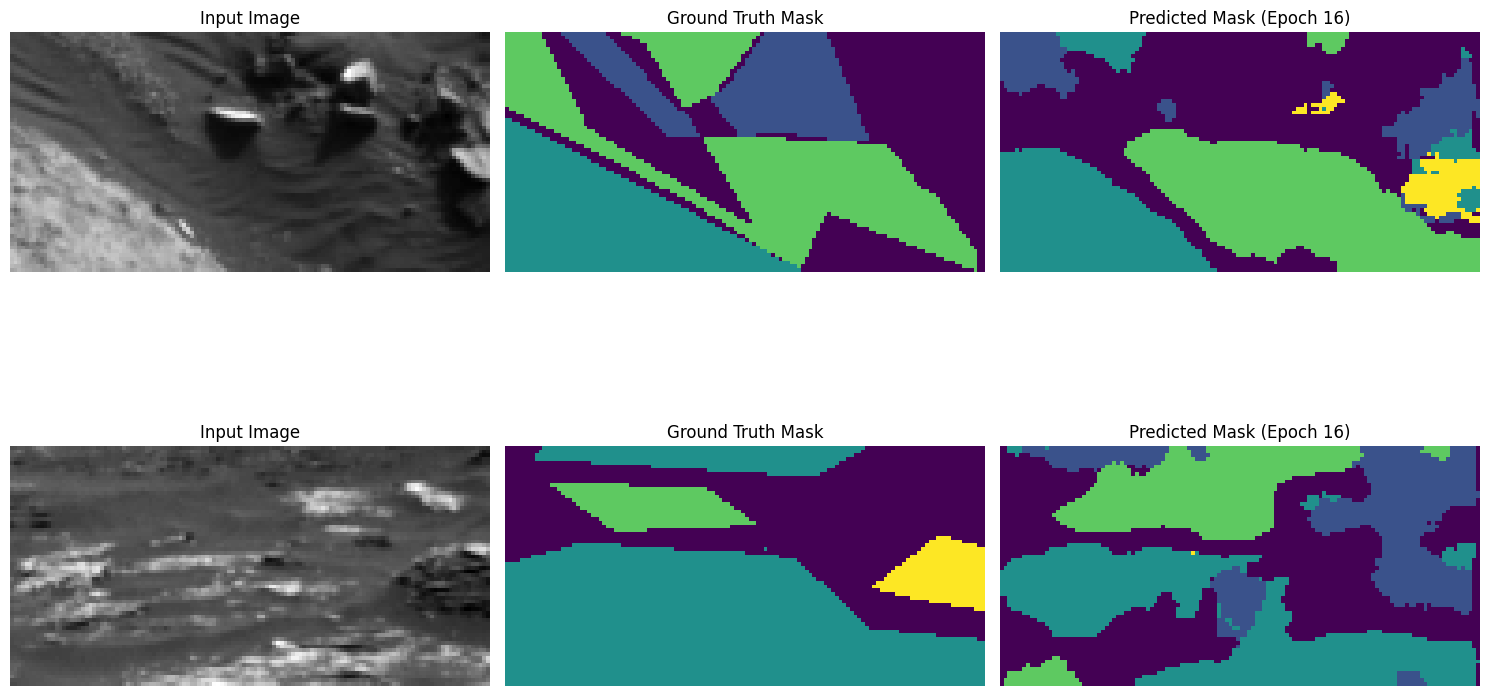

452/452 ━━━━━━━━━━━━━━━━━━━━ 94s 207ms/step - accuracy: 0.7662 - loss: 0.7178 - mean_iou: 0.5681 - val_accuracy: 0.7385 - val_loss: 0.7509 - val_mean_iou: 0.4684 - learning_rate: 0.0010
Epoch 17/1000
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.7717 - loss: 0.7141 - mean_iou: 0.5928Available log keys: dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou'])

Epoch 17: val_loss did not improve from 0.74738
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


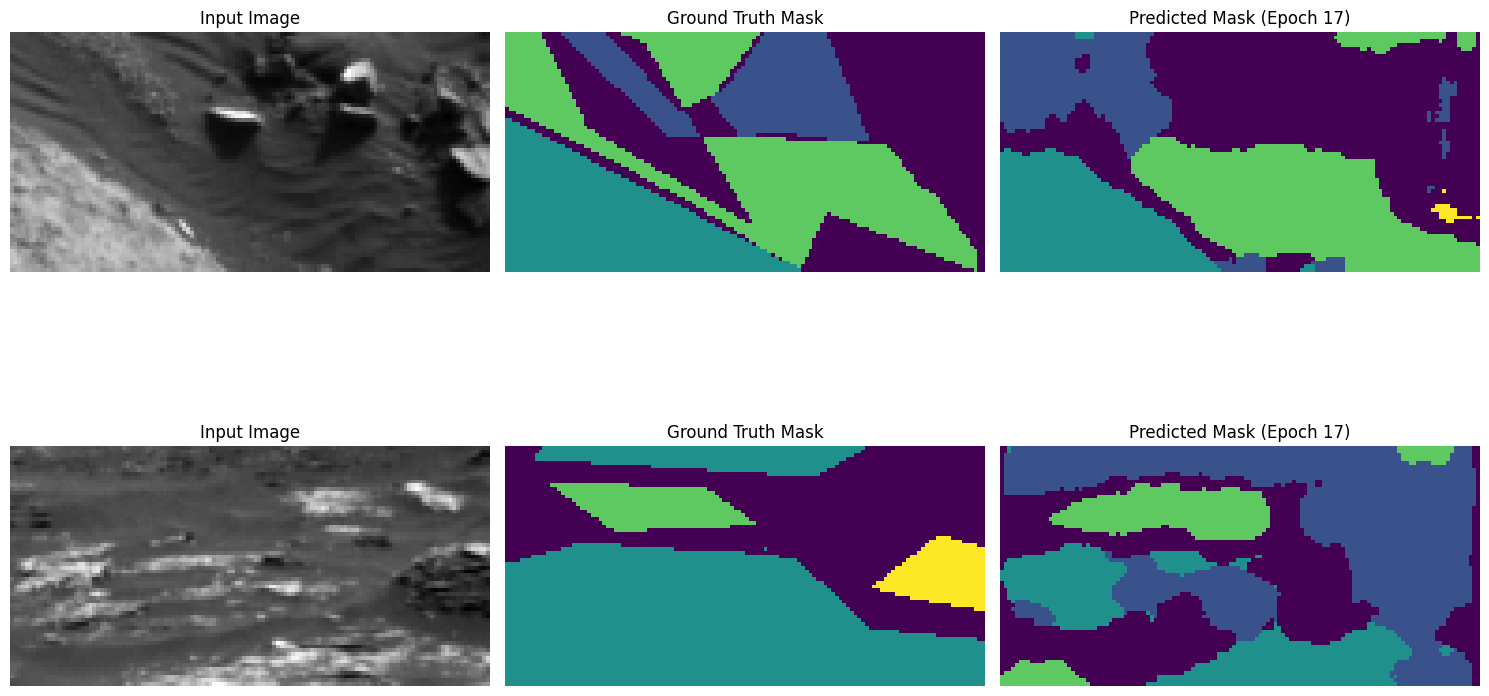

452/452 ━━━━━━━━━━━━━━━━━━━━ 93s 207ms/step - accuracy: 0.7717 - loss: 0.7141 - mean_iou: 0.5927 - val_accuracy: 0.7375 - val_loss: 0.7527 - val_mean_iou: 0.4588 - learning_rate: 0.0010
Epoch 18/1000
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.7769 - loss: 0.7116 - mean_iou: 0.5997Available log keys: dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou'])

Epoch 18: val_loss did not improve from 0.74738
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


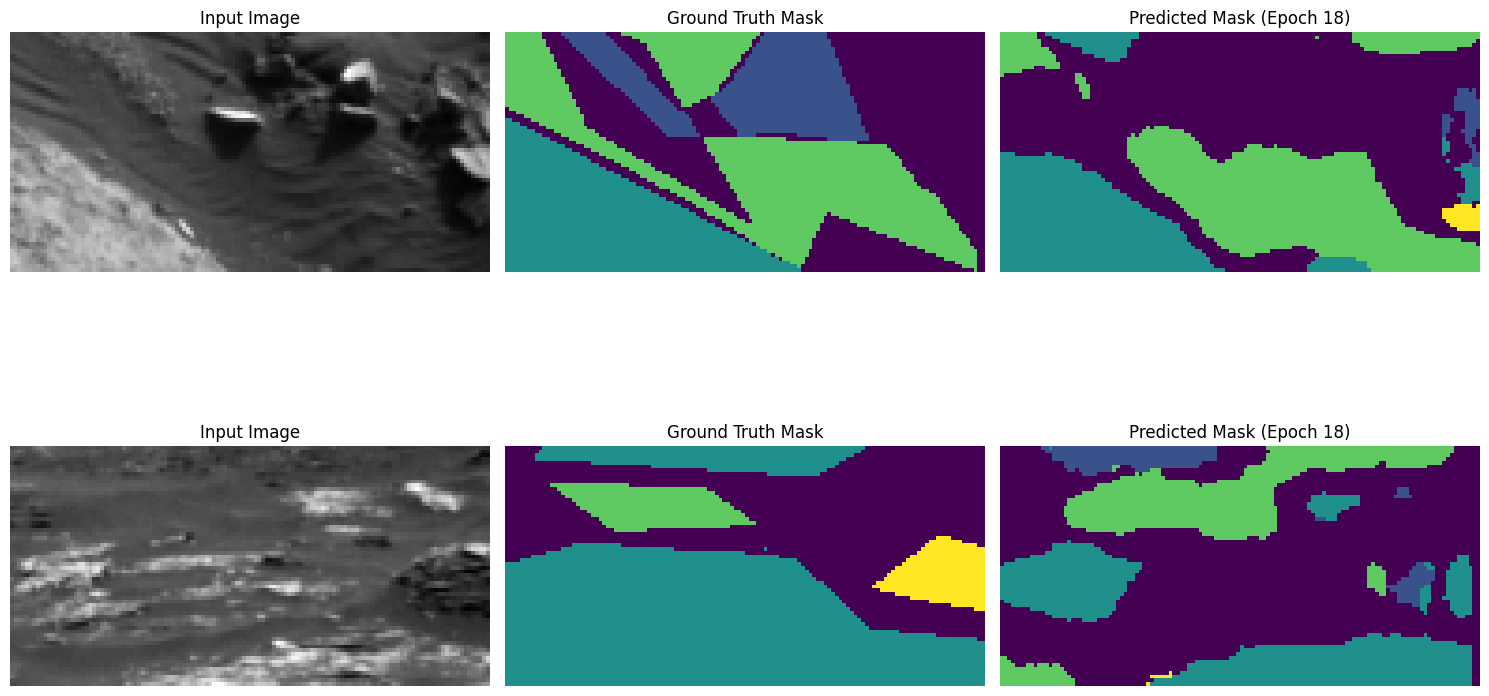

452/452 ━━━━━━━━━━━━━━━━━━━━ 93s 206ms/step - accuracy: 0.7769 - loss: 0.7116 - mean_iou: 0.5996 - val_accuracy: 0.7552 - val_loss: 0.7480 - val_mean_iou: 0.4606 - learning_rate: 0.0010
Epoch 19/1000
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.7837 - loss: 0.7075 - mean_iou: 0.5982Available log keys: dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou'])

Epoch 19: val_loss did not improve from 0.74738
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


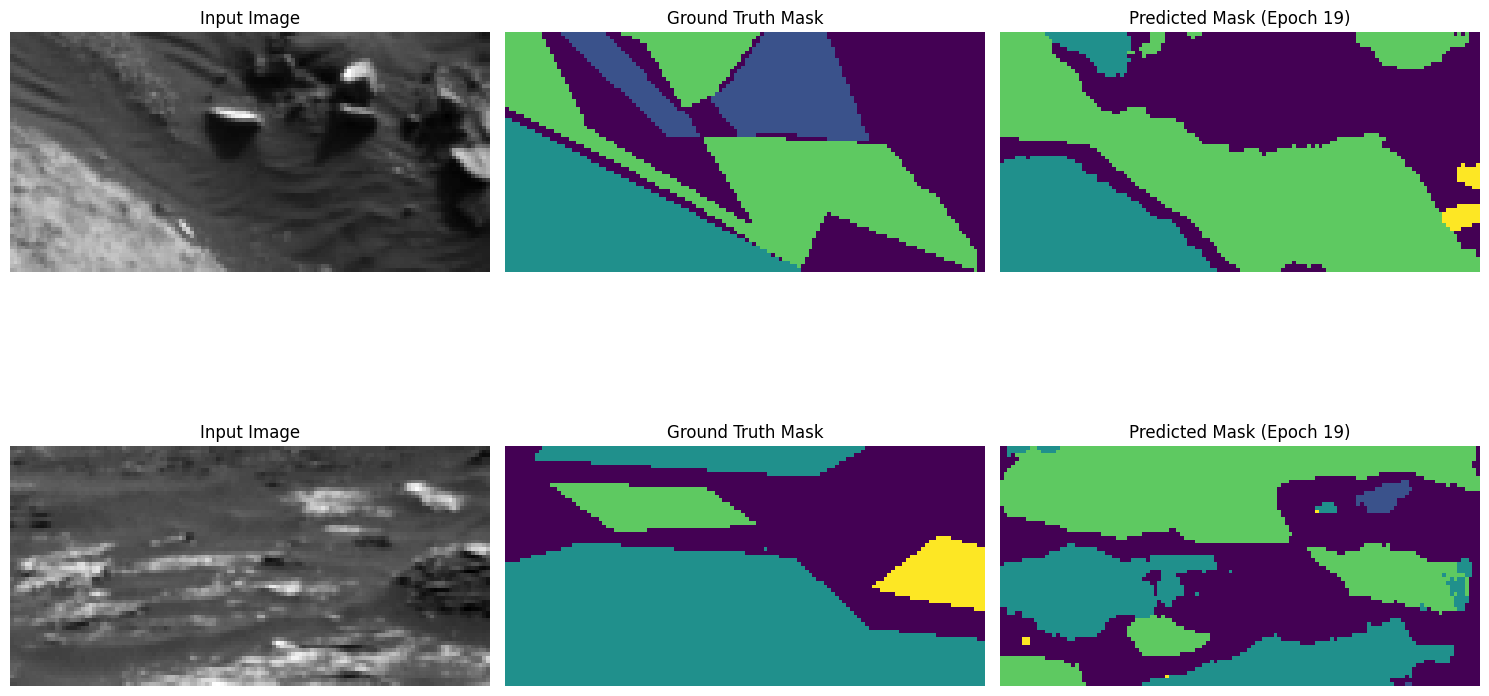

452/452 ━━━━━━━━━━━━━━━━━━━━ 93s 206ms/step - accuracy: 0.7837 - loss: 0.7075 - mean_iou: 0.5981 - val_accuracy: 0.7455 - val_loss: 0.7520 - val_mean_iou: 0.4430 - learning_rate: 0.0010
Epoch 20/1000
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.7894 - loss: 0.7037 - mean_iou: 0.6094Available log keys: dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou'])

Epoch 20: val_loss did not improve from 0.74738

Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


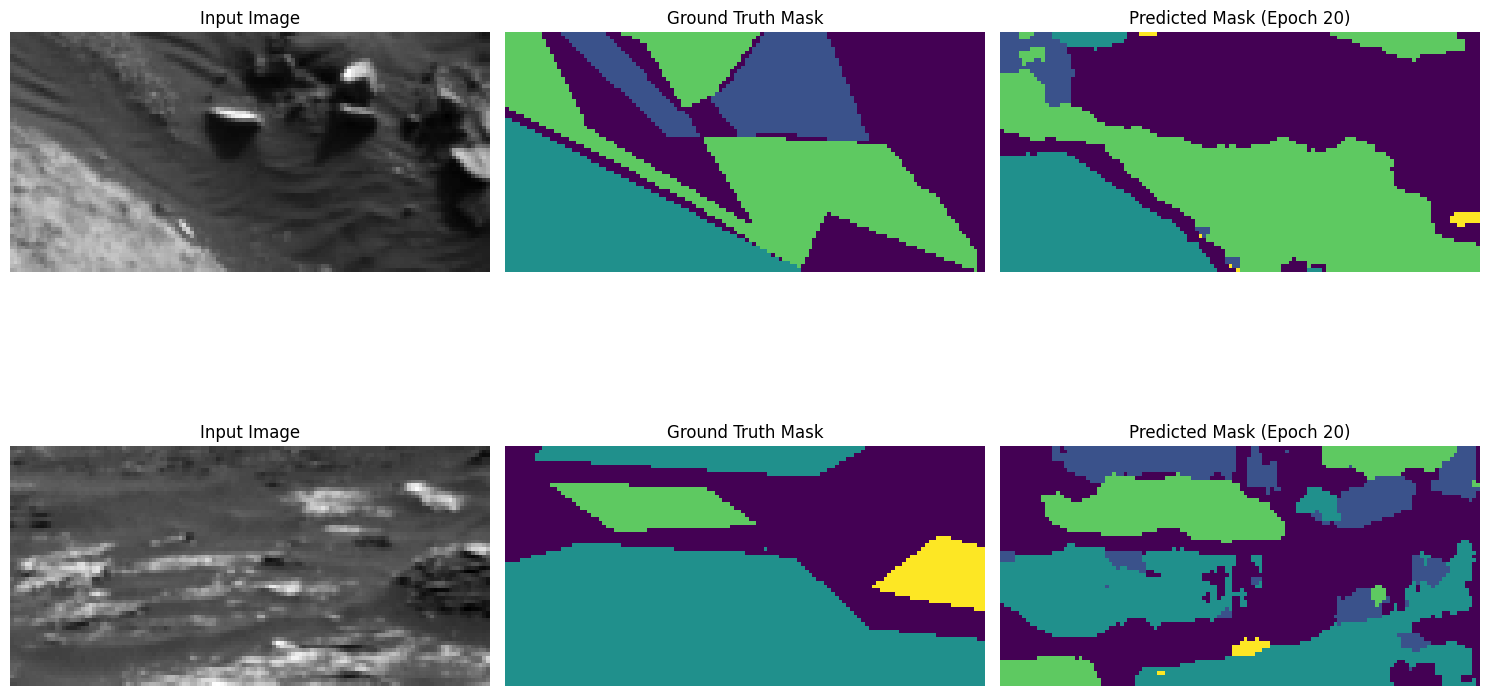

452/452 ━━━━━━━━━━━━━━━━━━━━ 93s 206ms/step - accuracy: 0.7895 - loss: 0.7037 - mean_iou: 0.6094 - val_accuracy: 0.7418 - val_loss: 0.7527 - val_mean_iou: 0.4540 - learning_rate: 0.0010
Epoch 21/1000
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.8112 - loss: 0.6918 - mean_iou: 0.6444Available log keys: dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou'])

Epoch 21: val_loss did not improve from 0.74738
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


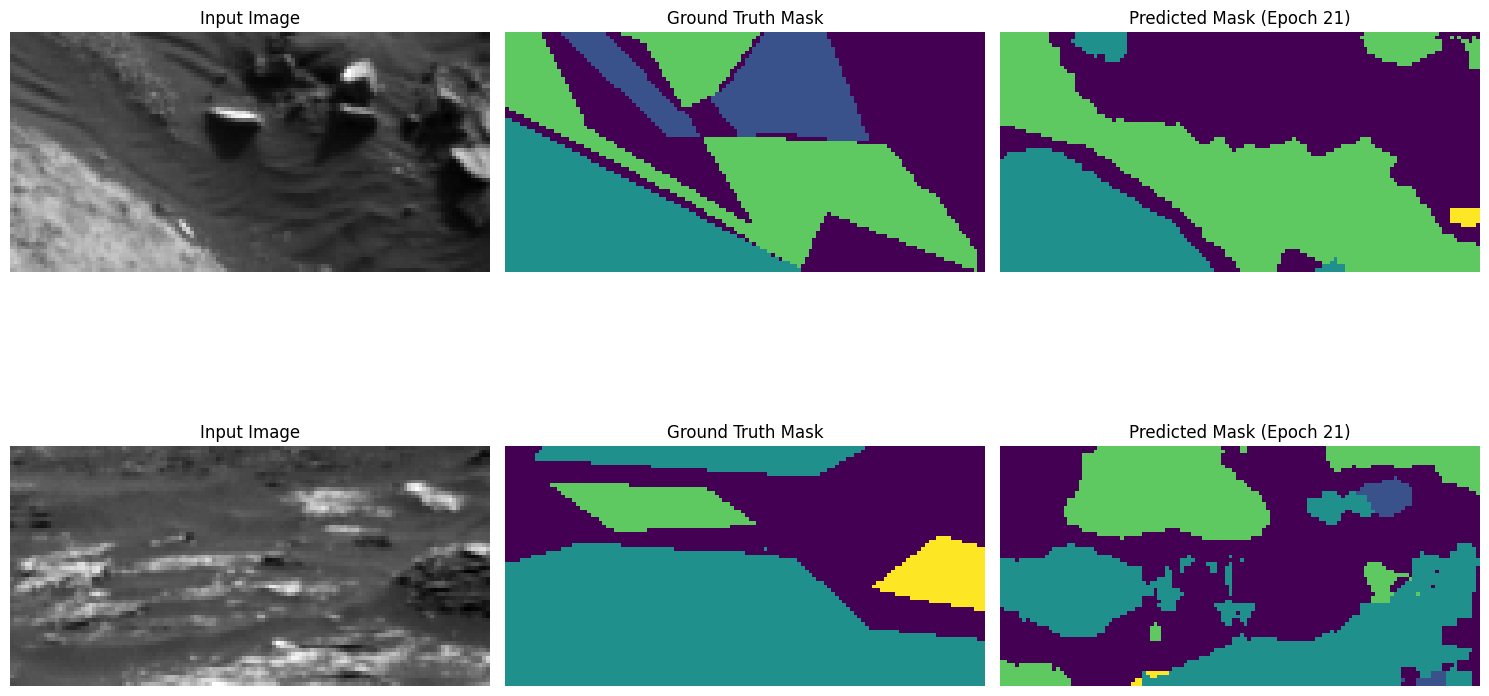

452/452 ━━━━━━━━━━━━━━━━━━━━ 93s 205ms/step - accuracy: 0.8112 - loss: 0.6918 - mean_iou: 0.6444 - val_accuracy: 0.7634 - val_loss: 0.7488 - val_mean_iou: 0.4629 - learning_rate: 5.0000e-04
Epoch 22/1000
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.8295 - loss: 0.6809 - mean_iou: 0.6669Available log keys: dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou'])
Epoch 22: val_mean_iou improved to 0.4739, saving model.

Epoch 22: val_loss did not improve from 0.74738
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


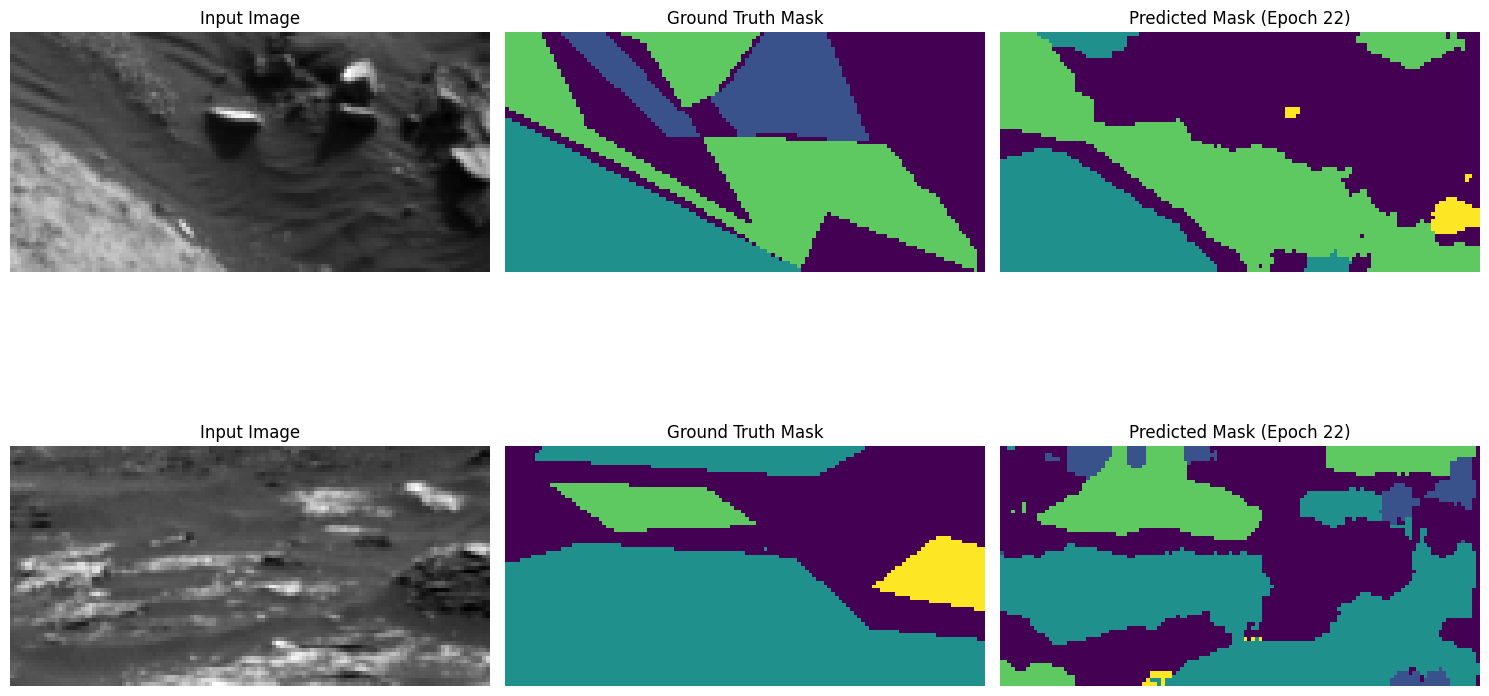

452/452 ━━━━━━━━━━━━━━━━━━━━ 93s 207ms/step - accuracy: 0.8295 - loss: 0.6809 - mean_iou: 0.6669 - val_accuracy: 0.7645 - val_loss: 0.7489 - val_mean_iou: 0.4739 - learning_rate: 5.0000e-04
Epoch 23/1000
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.8367 - loss: 0.6756 - mean_iou: 0.6732Available log keys: dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou'])

Epoch 23: val_loss did not improve from 0.74738
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


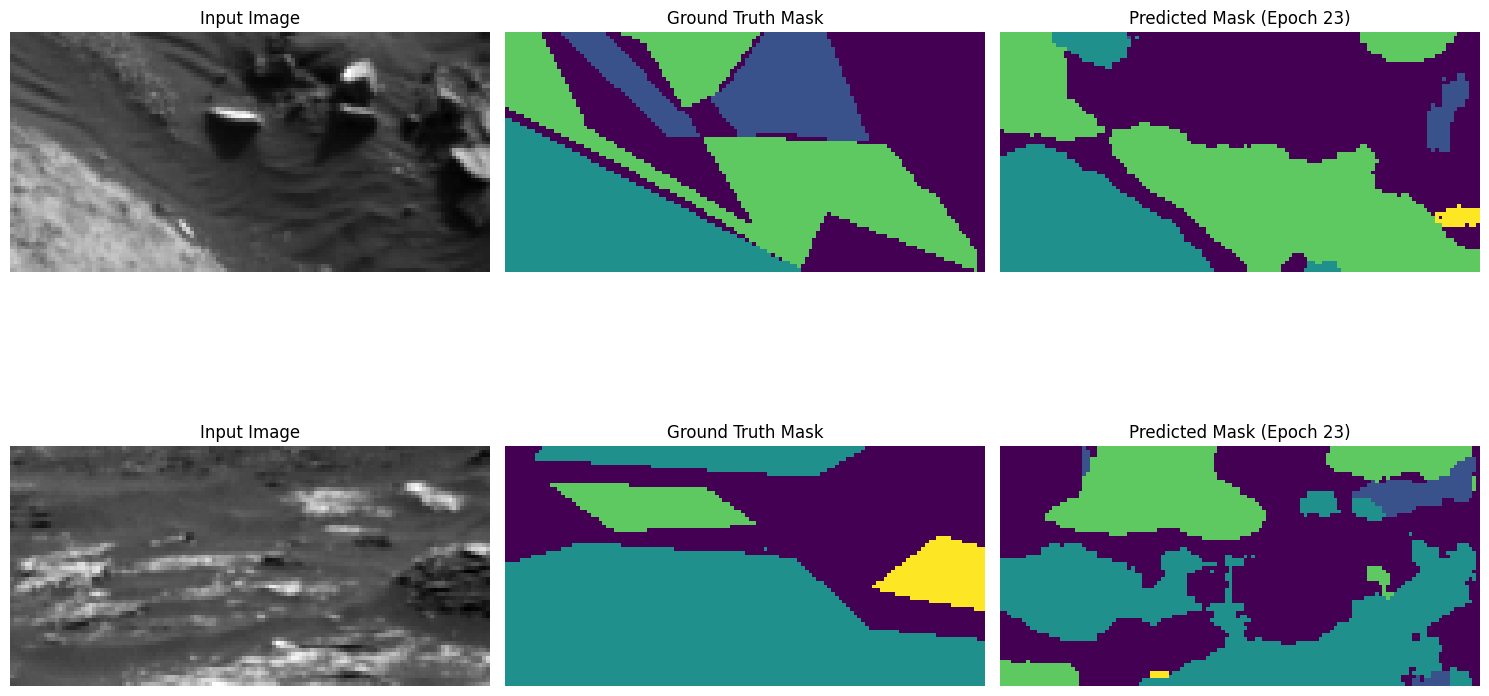

452/452 ━━━━━━━━━━━━━━━━━━━━ 93s 206ms/step - accuracy: 0.8367 - loss: 0.6755 - mean_iou: 0.6731 - val_accuracy: 0.7636 - val_loss: 0.7507 - val_mean_iou: 0.4625 - learning_rate: 5.0000e-04
Epoch 24/1000
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.8439 - loss: 0.6709 - mean_iou: 0.6783Available log keys: dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou'])
Epoch 24: val_mean_iou improved to 0.4743, saving model.

Epoch 24: val_loss did not improve from 0.74738
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


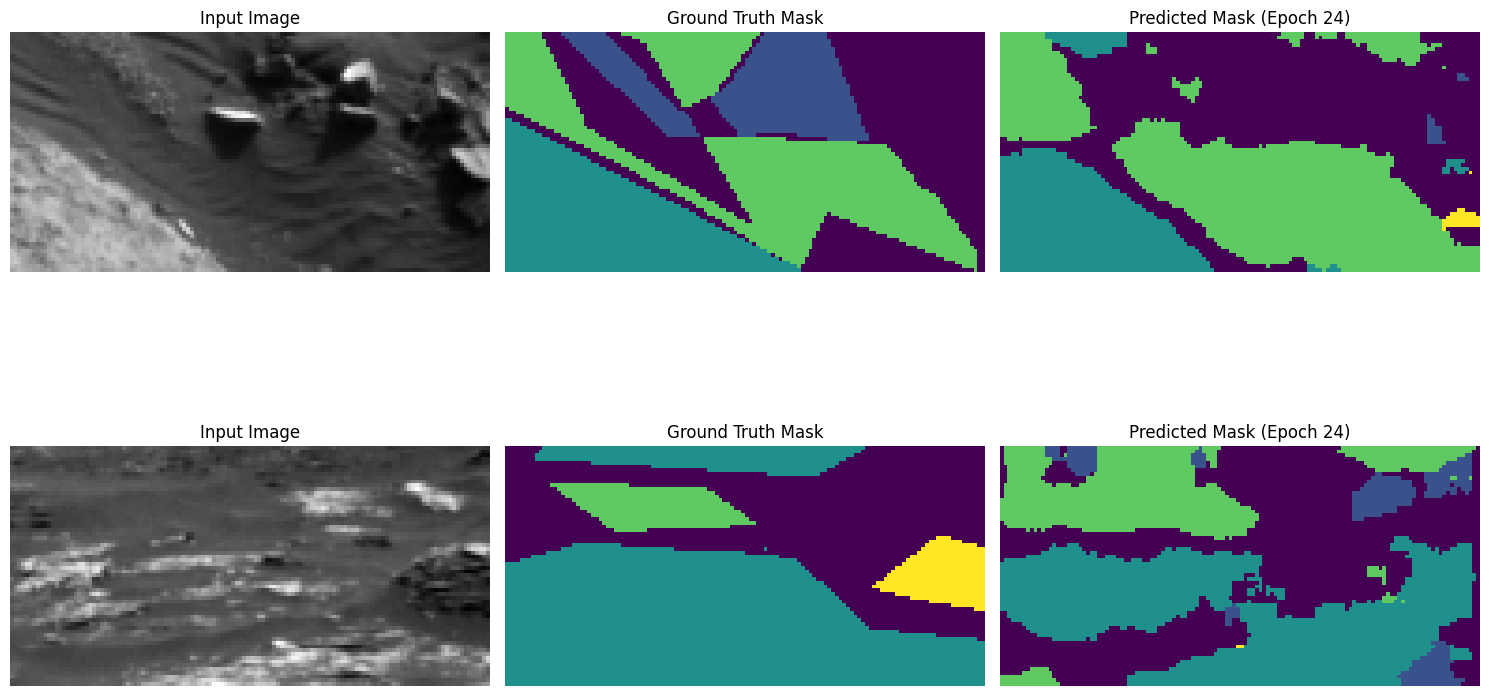

452/452 ━━━━━━━━━━━━━━━━━━━━ 93s 207ms/step - accuracy: 0.8439 - loss: 0.6709 - mean_iou: 0.6783 - val_accuracy: 0.7635 - val_loss: 0.7483 - val_mean_iou: 0.4743 - learning_rate: 5.0000e-04
Epoch 25/1000
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.8510 - loss: 0.6664 - mean_iou: 0.6866Available log keys: dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou'])
Epoch 25: val_mean_iou improved to 0.4756, saving model.

Epoch 25: val_loss did not improve from 0.74738

Epoch 25: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


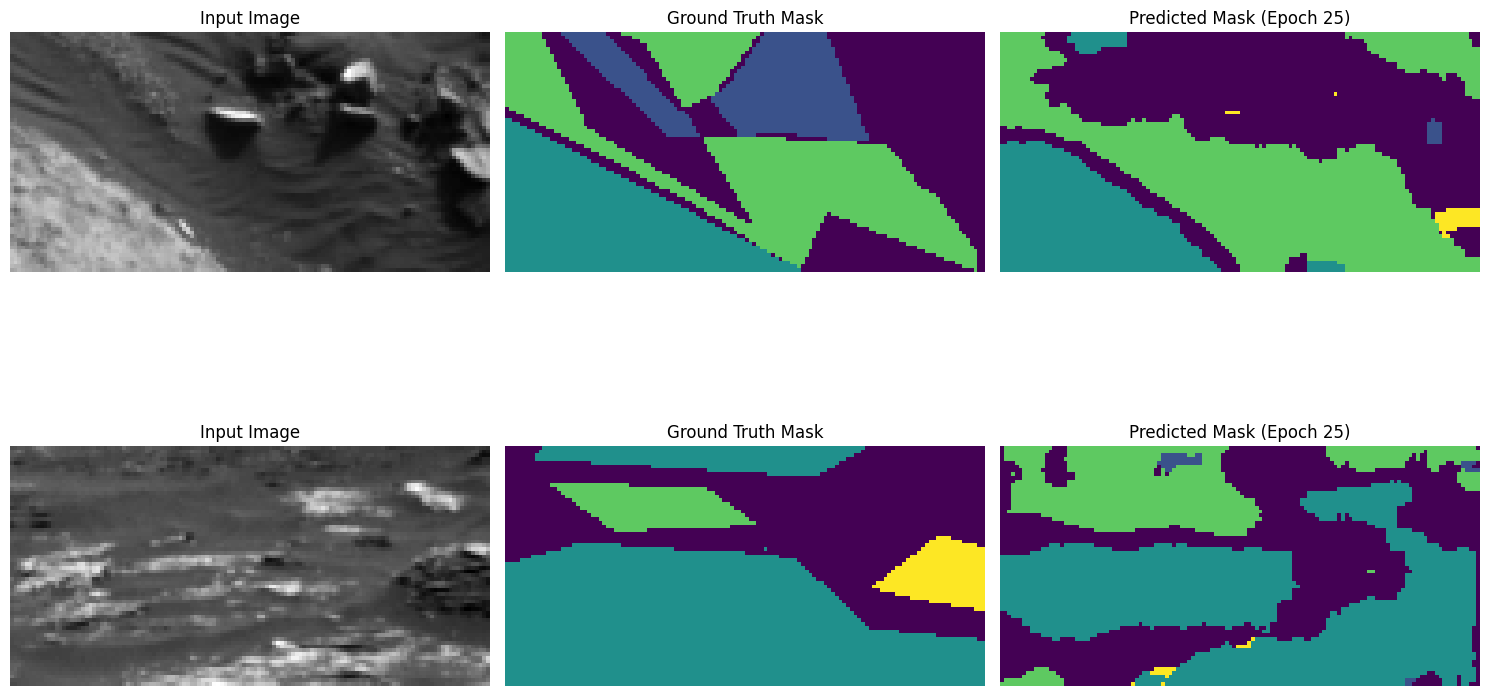

452/452 ━━━━━━━━━━━━━━━━━━━━ 93s 206ms/step - accuracy: 0.8511 - loss: 0.6664 - mean_iou: 0.6866 - val_accuracy: 0.7639 - val_loss: 0.7528 - val_mean_iou: 0.4756 - learning_rate: 5.0000e-04
Epoch 26/1000
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.8583 - loss: 0.6609 - mean_iou: 0.6959Available log keys: dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou'])

Epoch 26: val_loss did not improve from 0.74738
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


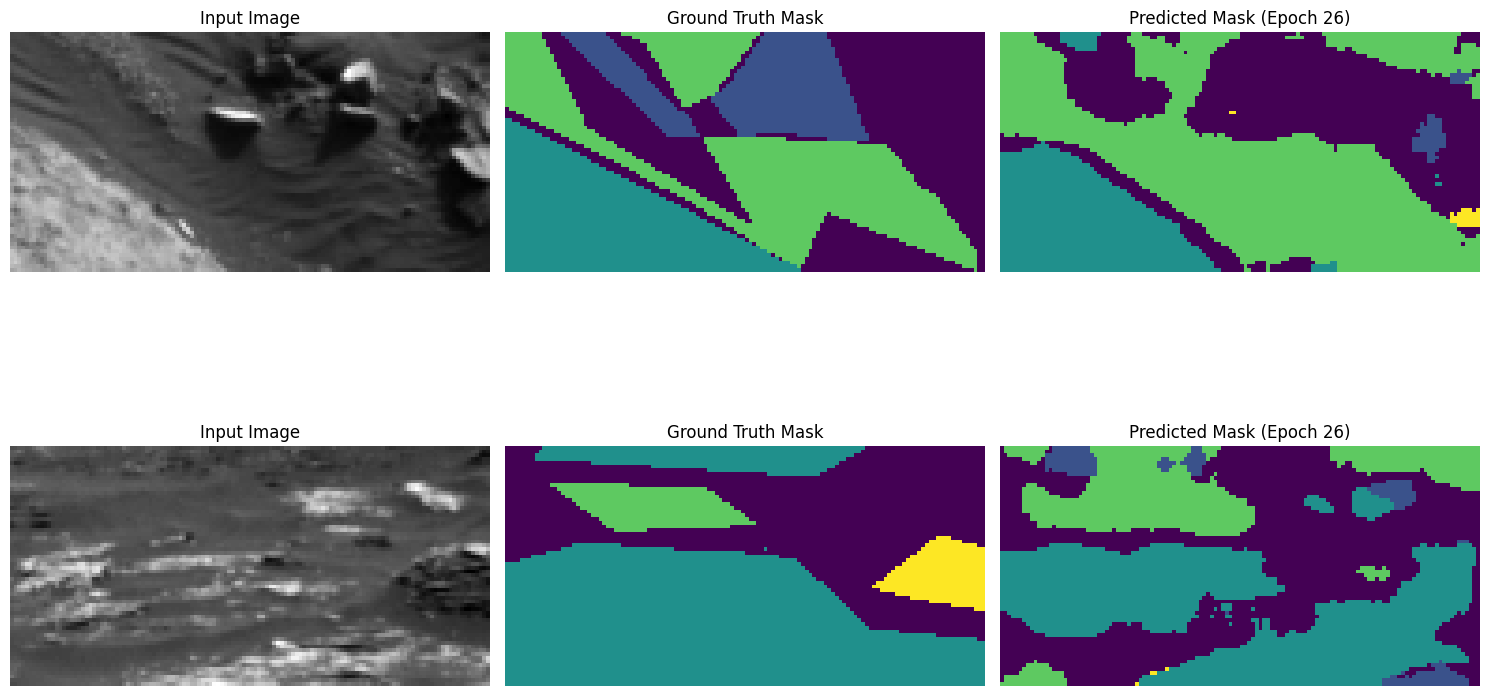

452/452 ━━━━━━━━━━━━━━━━━━━━ 93s 206ms/step - accuracy: 0.8583 - loss: 0.6609 - mean_iou: 0.6959 - val_accuracy: 0.7693 - val_loss: 0.7488 - val_mean_iou: 0.4704 - learning_rate: 2.5000e-04
Epoch 27/1000
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.8689 - loss: 0.6533 - mean_iou: 0.7065Available log keys: dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou'])

Epoch 27: val_loss did not improve from 0.74738
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


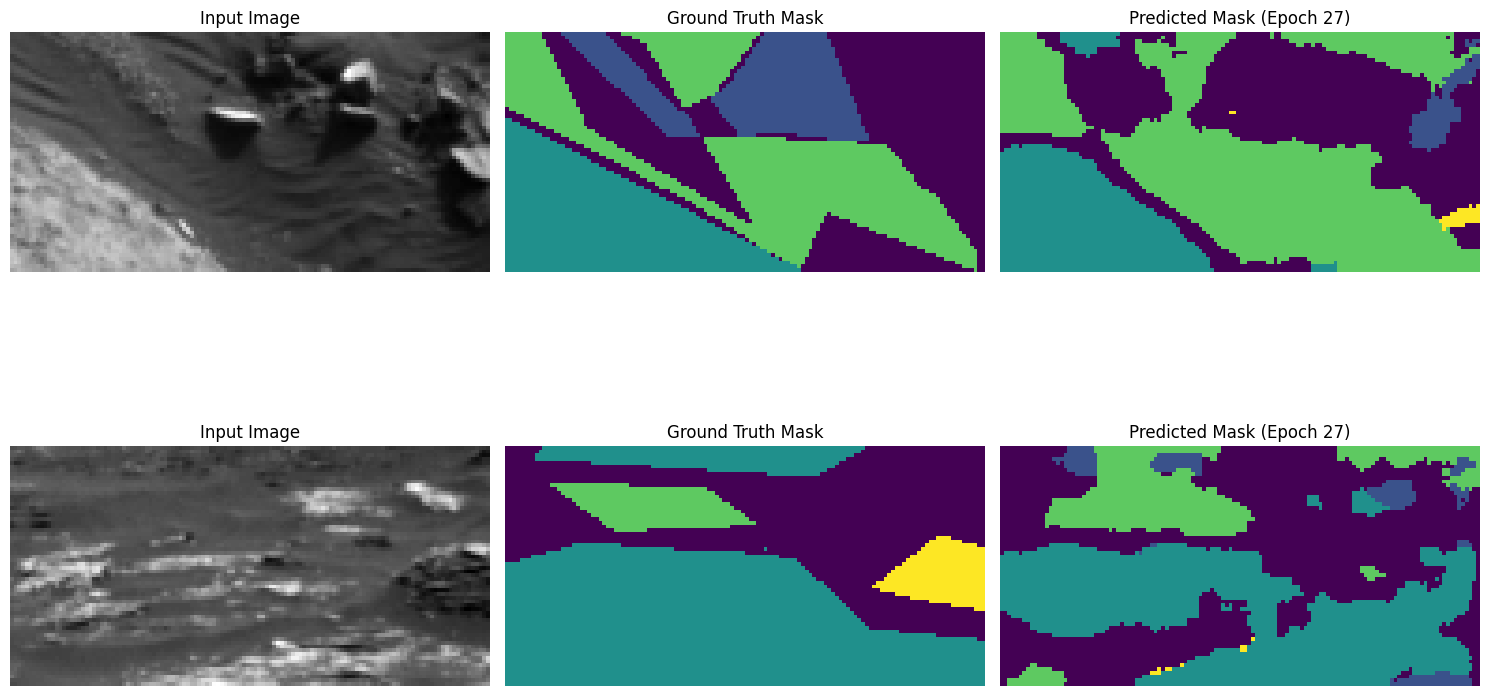

452/452 ━━━━━━━━━━━━━━━━━━━━ 93s 205ms/step - accuracy: 0.8689 - loss: 0.6533 - mean_iou: 0.7065 - val_accuracy: 0.7699 - val_loss: 0.7489 - val_mean_iou: 0.4674 - learning_rate: 2.5000e-04
Epoch 28/1000
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.8759 - loss: 0.6471 - mean_iou: 0.7135Available log keys: dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou'])

Epoch 28: val_loss did not improve from 0.74738
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


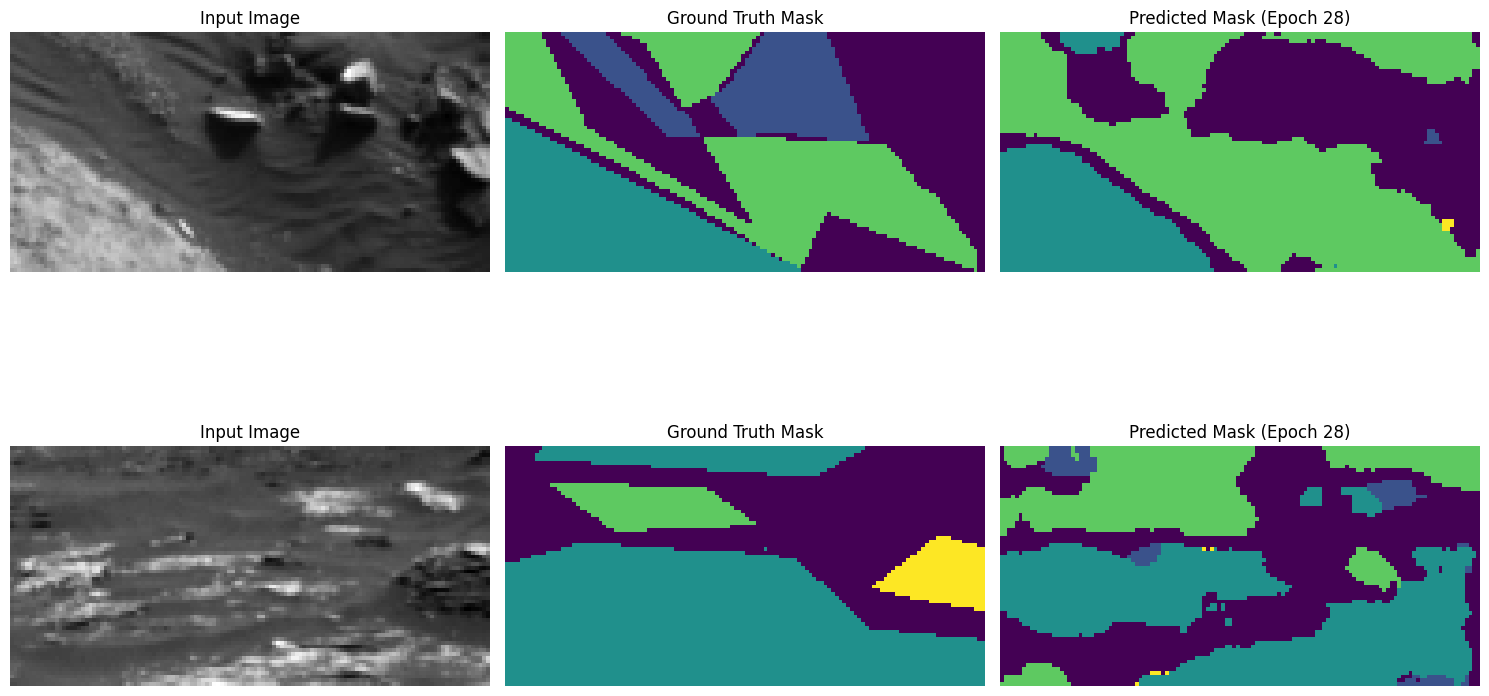

452/452 ━━━━━━━━━━━━━━━━━━━━ 93s 207ms/step - accuracy: 0.8759 - loss: 0.6471 - mean_iou: 0.7134 - val_accuracy: 0.7653 - val_loss: 0.7505 - val_mean_iou: 0.4690 - learning_rate: 2.5000e-04
Epoch 29/1000
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.8808 - loss: 0.6434 - mean_iou: 0.7183Available log keys: dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou'])

Epoch 29: val_loss did not improve from 0.74738
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


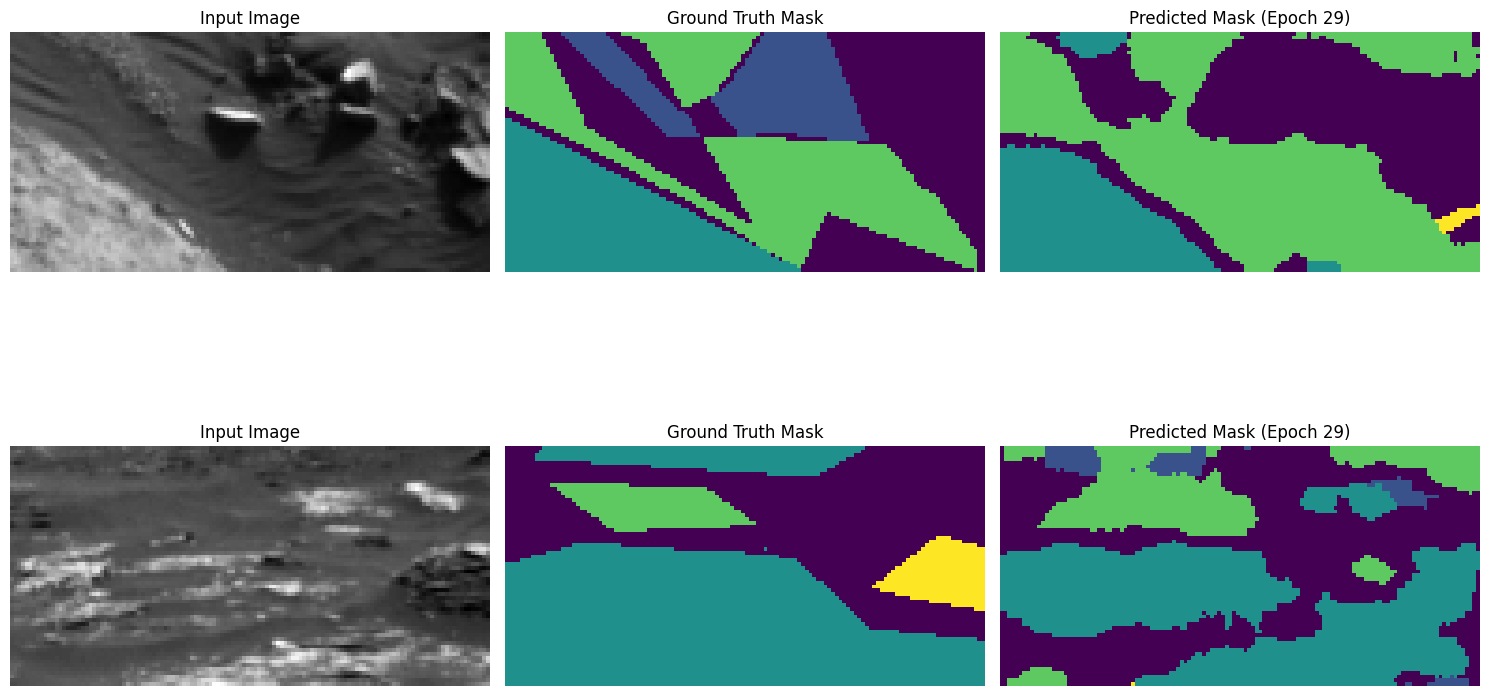

452/452 ━━━━━━━━━━━━━━━━━━━━ 93s 206ms/step - accuracy: 0.8808 - loss: 0.6434 - mean_iou: 0.7182 - val_accuracy: 0.7715 - val_loss: 0.7490 - val_mean_iou: 0.4726 - learning_rate: 2.5000e-04
Epoch 30/1000
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.8829 - loss: 0.6414 - mean_iou: 0.7204Available log keys: dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou'])

Epoch 30: val_loss did not improve from 0.74738

Epoch 30: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


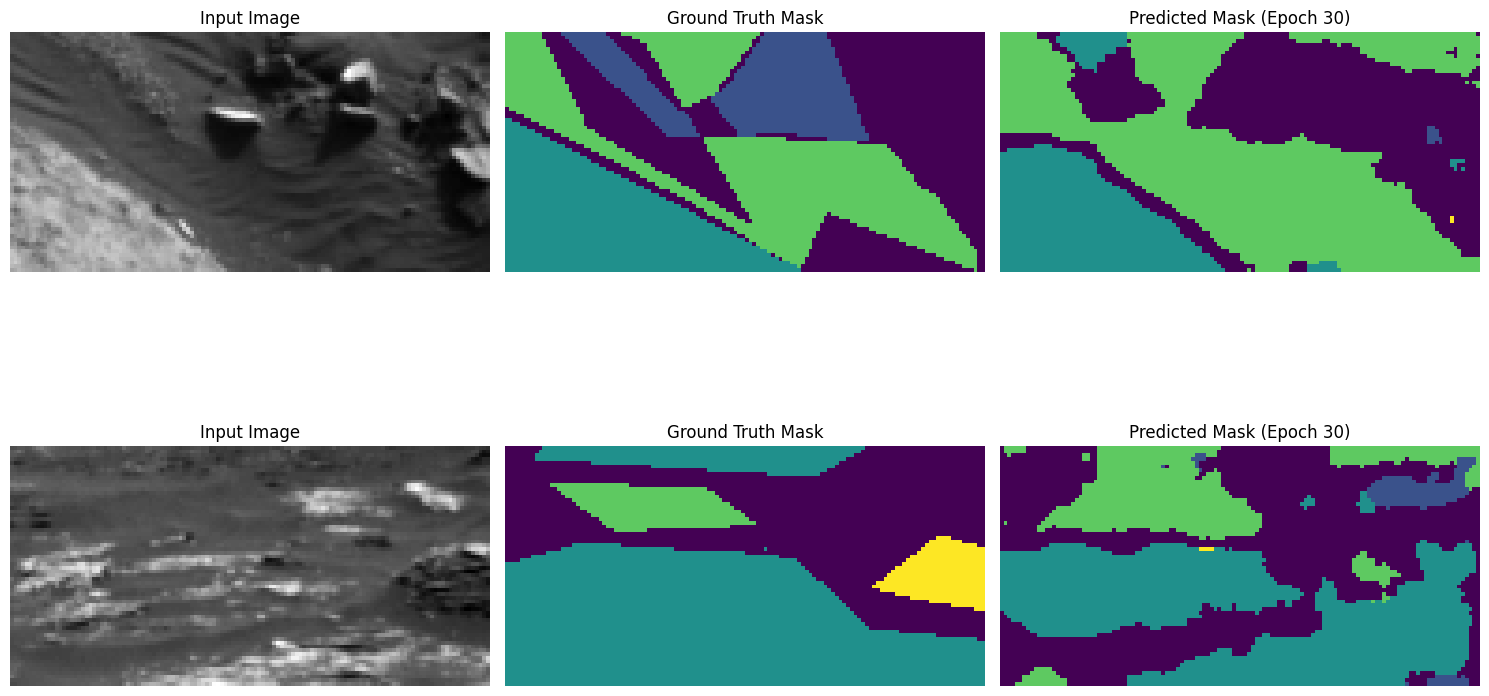

452/452 ━━━━━━━━━━━━━━━━━━━━ 93s 206ms/step - accuracy: 0.8829 - loss: 0.6414 - mean_iou: 0.7203 - val_accuracy: 0.7718 - val_loss: 0.7492 - val_mean_iou: 0.4713 - learning_rate: 2.5000e-04
Epoch 31/1000
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.8879 - loss: 0.6380 - mean_iou: 0.7257Available log keys: dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou'])

Epoch 31: val_loss did not improve from 0.74738
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


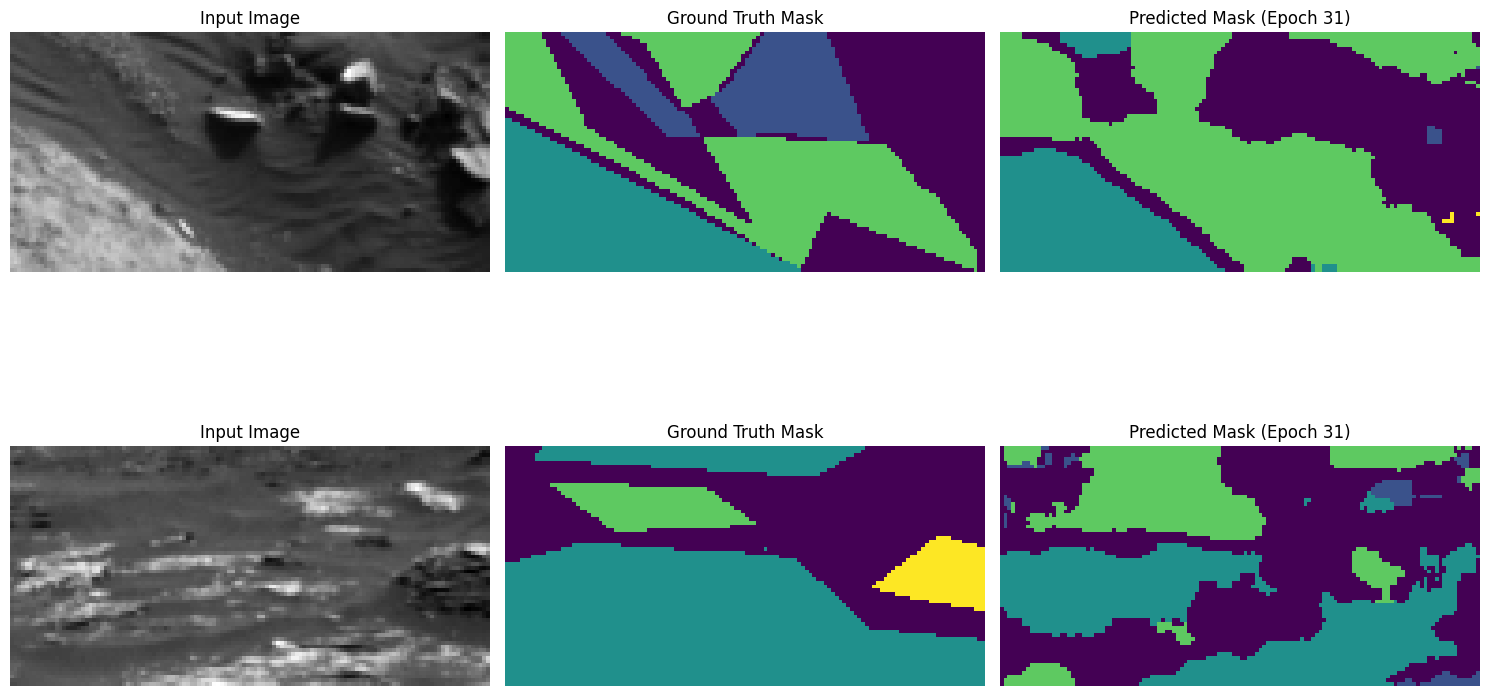

452/452 ━━━━━━━━━━━━━━━━━━━━ 93s 205ms/step - accuracy: 0.8879 - loss: 0.6380 - mean_iou: 0.7256 - val_accuracy: 0.7670 - val_loss: 0.7512 - val_mean_iou: 0.4614 - learning_rate: 1.2500e-04
Epoch 32/1000
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.8927 - loss: 0.6326 - mean_iou: 0.7296Available log keys: dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou'])

Epoch 32: val_loss did not improve from 0.74738
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


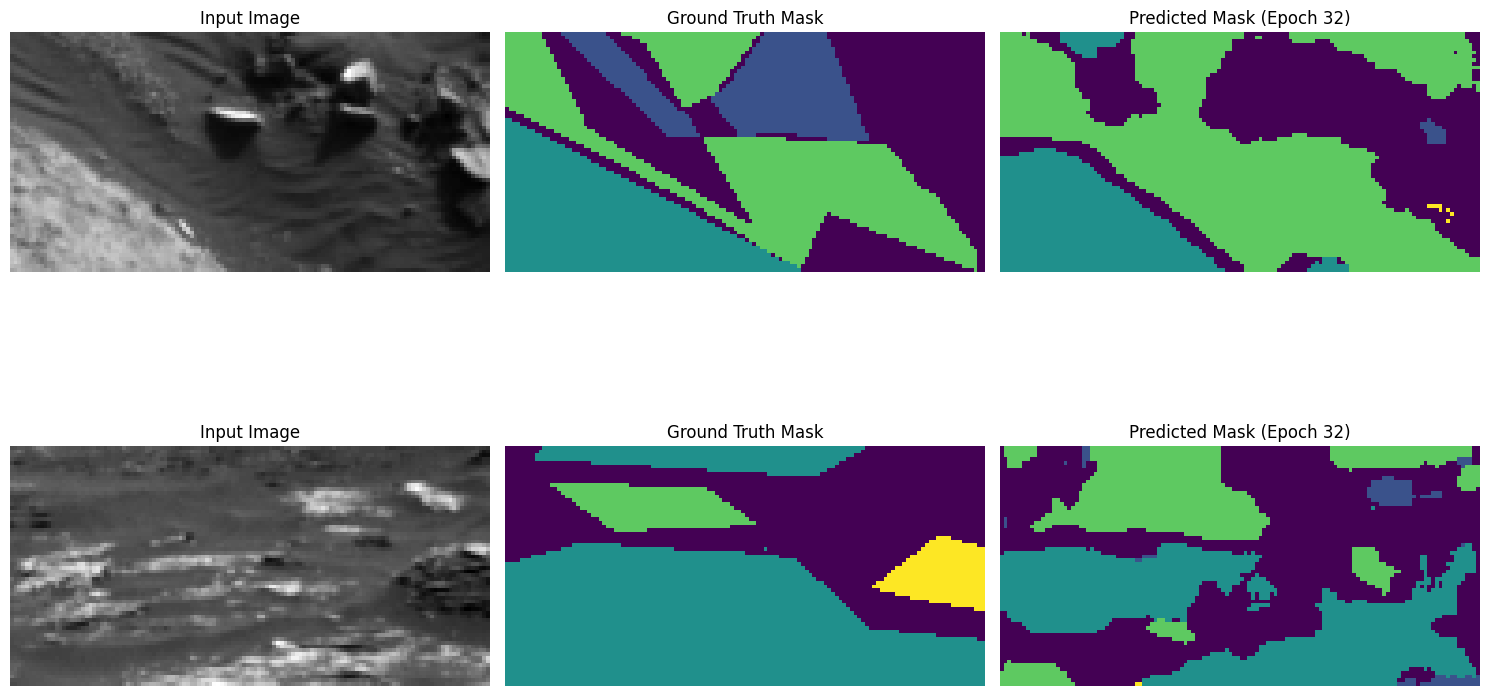

452/452 ━━━━━━━━━━━━━━━━━━━━ 93s 206ms/step - accuracy: 0.8927 - loss: 0.6326 - mean_iou: 0.7295 - val_accuracy: 0.7676 - val_loss: 0.7503 - val_mean_iou: 0.4616 - learning_rate: 1.2500e-04
Epoch 33/1000
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.8969 - loss: 0.6279 - mean_iou: 0.7332Available log keys: dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou'])

Epoch 33: val_loss did not improve from 0.74738
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


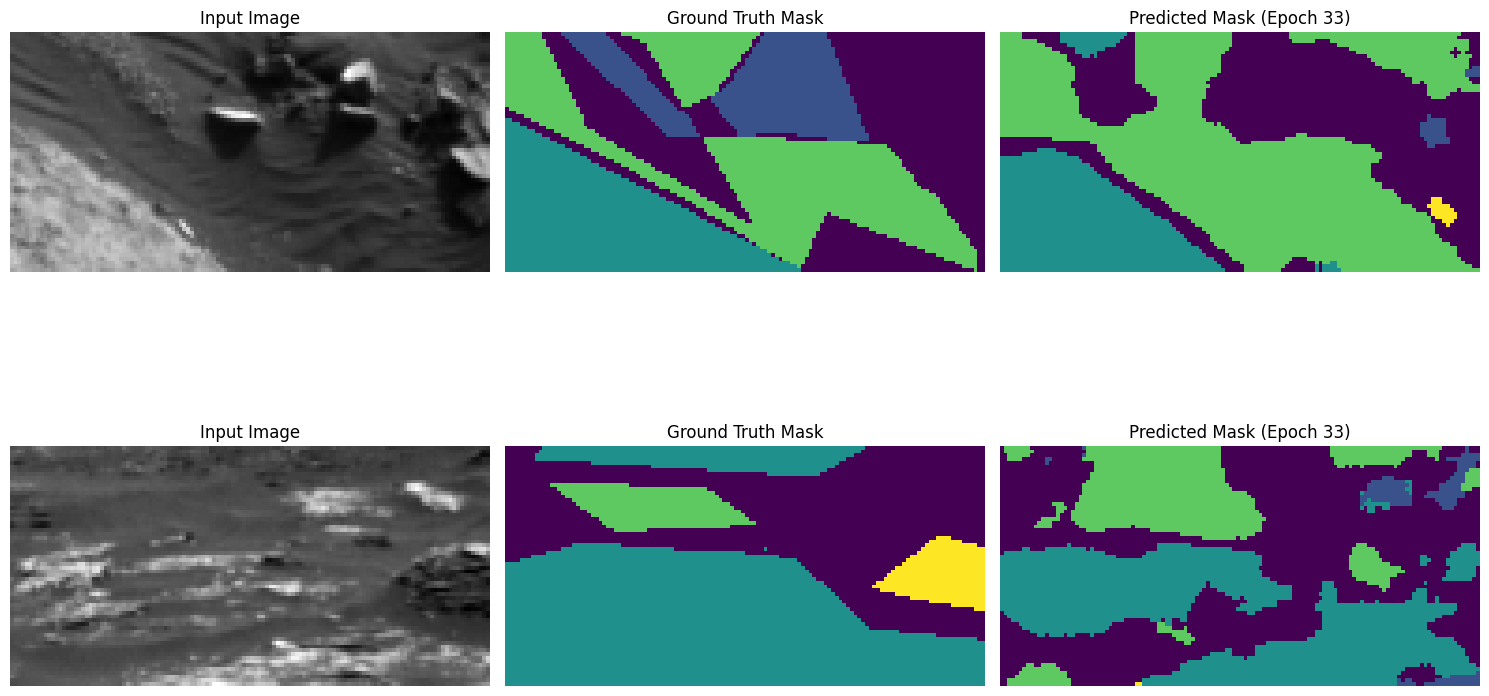

452/452 ━━━━━━━━━━━━━━━━━━━━ 93s 206ms/step - accuracy: 0.8969 - loss: 0.6279 - mean_iou: 0.7331 - val_accuracy: 0.7674 - val_loss: 0.7510 - val_mean_iou: 0.4625 - learning_rate: 1.2500e-04
Epoch 34/1000
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.8997 - loss: 0.6256 - mean_iou: 0.7357Available log keys: dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou'])

Epoch 34: val_loss did not improve from 0.74738
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


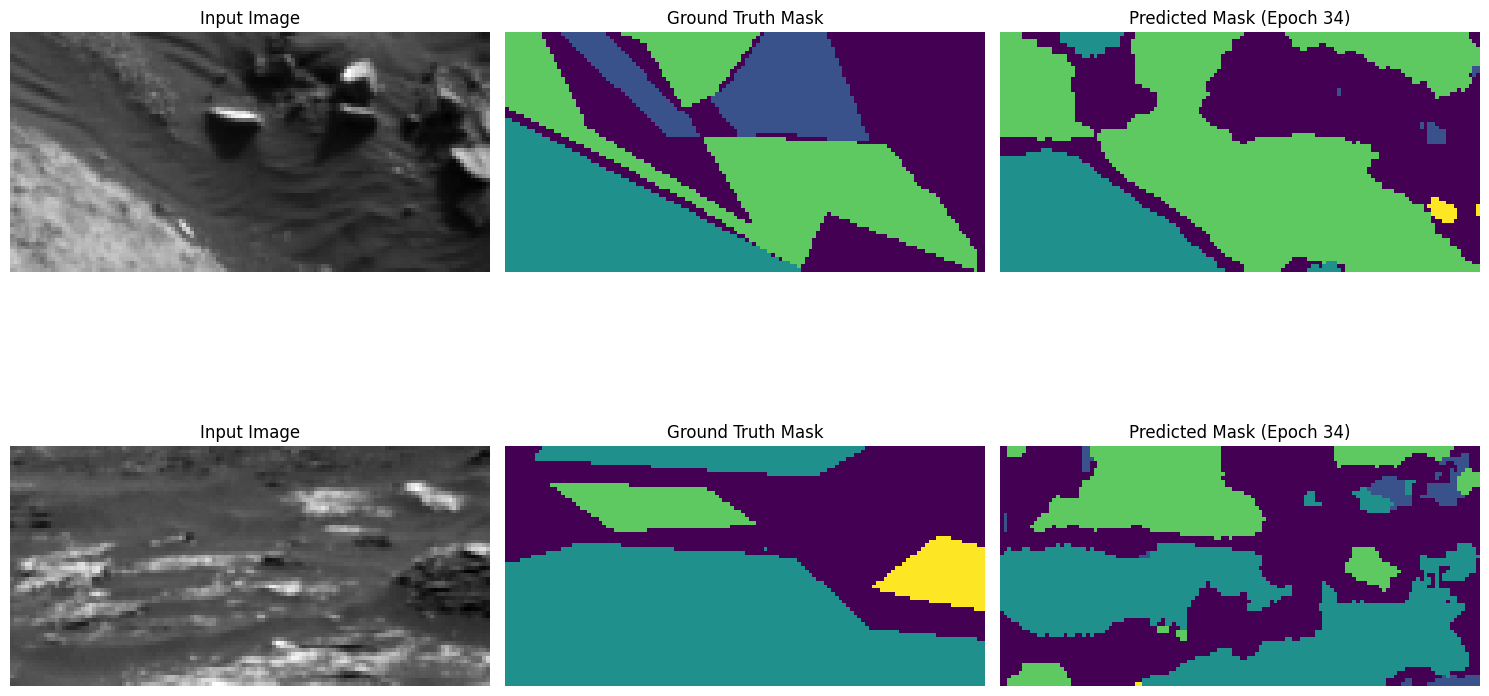

452/452 ━━━━━━━━━━━━━━━━━━━━ 93s 206ms/step - accuracy: 0.8997 - loss: 0.6255 - mean_iou: 0.7357 - val_accuracy: 0.7683 - val_loss: 0.7514 - val_mean_iou: 0.4620 - learning_rate: 1.2500e-04
Epoch 35/1000
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.9027 - loss: 0.6227 - mean_iou: 0.7374Available log keys: dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou'])

Epoch 35: val_loss did not improve from 0.74738

Epoch 35: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


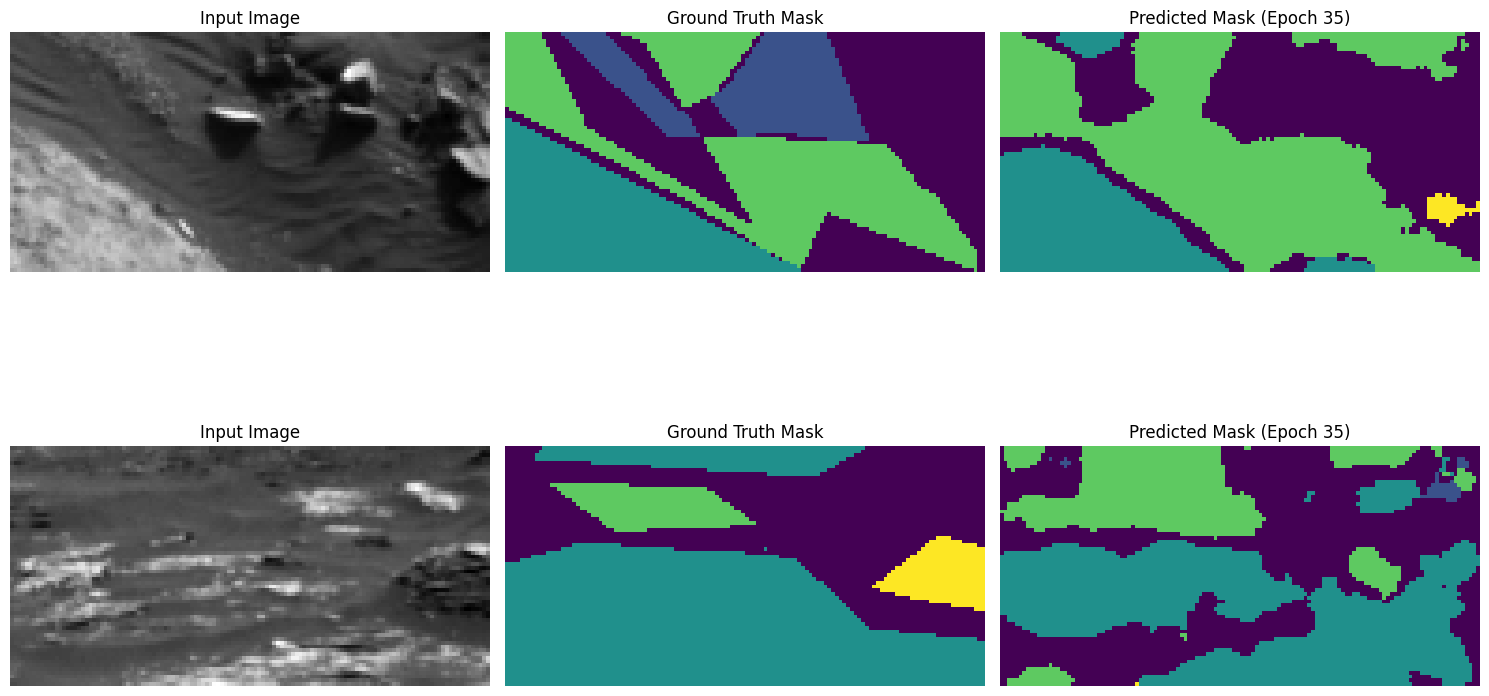

452/452 ━━━━━━━━━━━━━━━━━━━━ 93s 205ms/step - accuracy: 0.9027 - loss: 0.6227 - mean_iou: 0.7374 - val_accuracy: 0.7670 - val_loss: 0.7505 - val_mean_iou: 0.4636 - learning_rate: 1.2500e-04
Epoch 36/1000
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.9038 - loss: 0.6190 - mean_iou: 0.7384Available log keys: dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou'])

Epoch 36: val_loss did not improve from 0.74738
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


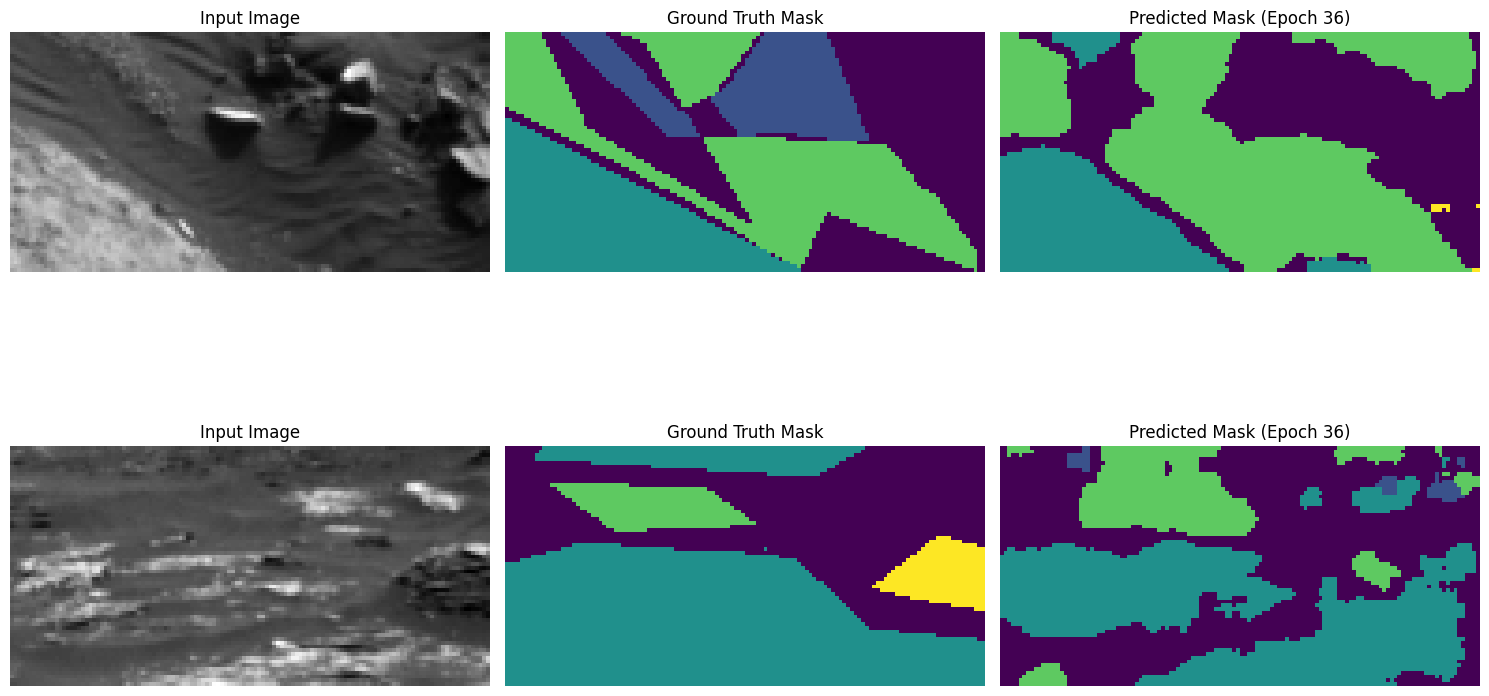

452/452 ━━━━━━━━━━━━━━━━━━━━ 93s 206ms/step - accuracy: 0.9038 - loss: 0.6190 - mean_iou: 0.7384 - val_accuracy: 0.7739 - val_loss: 0.7483 - val_mean_iou: 0.4675 - learning_rate: 6.2500e-05
Epoch 37/1000
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.9058 - loss: 0.6169 - mean_iou: 0.7401Available log keys: dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou'])

Epoch 37: val_loss did not improve from 0.74738
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


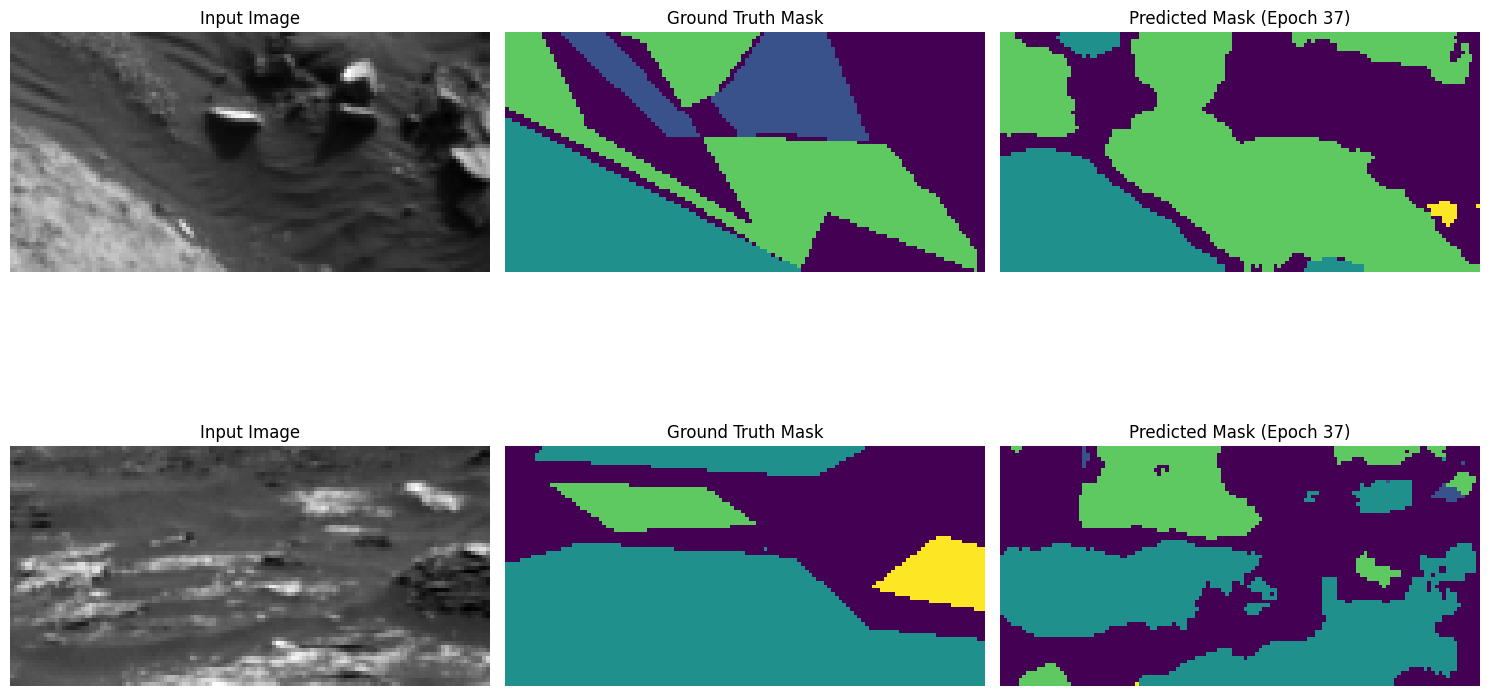

452/452 ━━━━━━━━━━━━━━━━━━━━ 93s 206ms/step - accuracy: 0.9058 - loss: 0.6169 - mean_iou: 0.7401 - val_accuracy: 0.7712 - val_loss: 0.7489 - val_mean_iou: 0.4620 - learning_rate: 6.2500e-05
Epoch 38/1000
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.9081 - loss: 0.6148 - mean_iou: 0.7421Available log keys: dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou'])

Epoch 38: val_loss did not improve from 0.74738
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


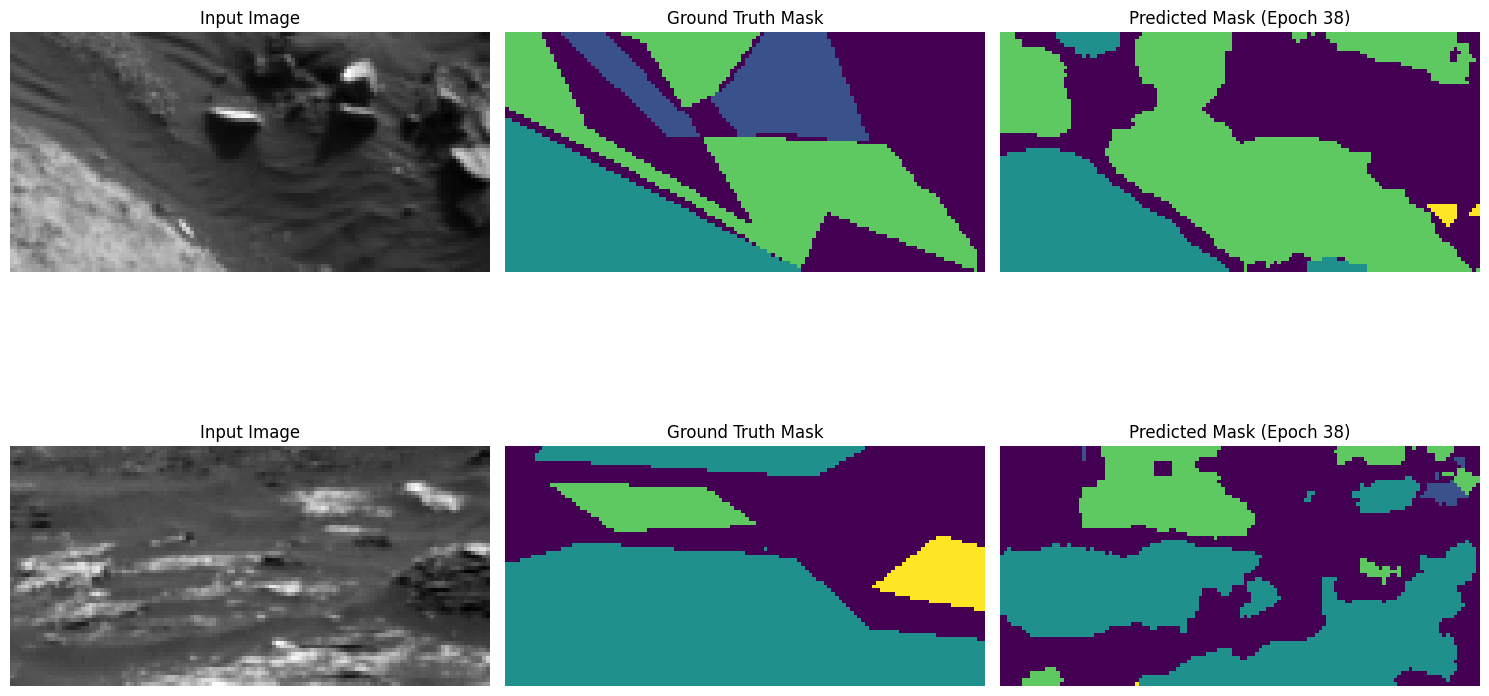

452/452 ━━━━━━━━━━━━━━━━━━━━ 93s 206ms/step - accuracy: 0.9082 - loss: 0.6148 - mean_iou: 0.7421 - val_accuracy: 0.7728 - val_loss: 0.7490 - val_mean_iou: 0.4635 - learning_rate: 6.2500e-05
Epoch 39/1000
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.9101 - loss: 0.6131 - mean_iou: 0.7437Available log keys: dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou'])

Epoch 39: val_loss did not improve from 0.74738
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


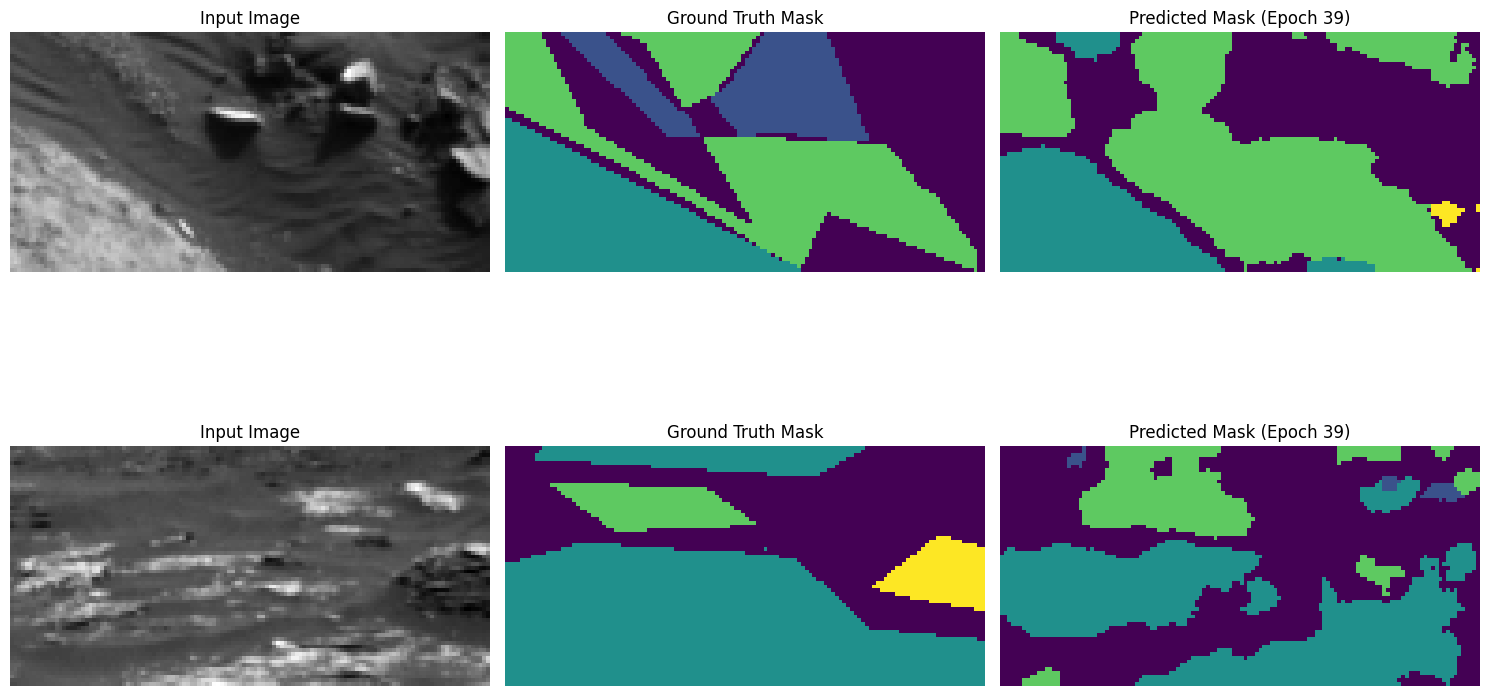

452/452 ━━━━━━━━━━━━━━━━━━━━ 93s 206ms/step - accuracy: 0.9101 - loss: 0.6131 - mean_iou: 0.7436 - val_accuracy: 0.7730 - val_loss: 0.7493 - val_mean_iou: 0.4637 - learning_rate: 6.2500e-05
Epoch 40/1000
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.9117 - loss: 0.6116 - mean_iou: 0.7449Available log keys: dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou'])

Epoch 40: val_loss did not improve from 0.74738

Epoch 40: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


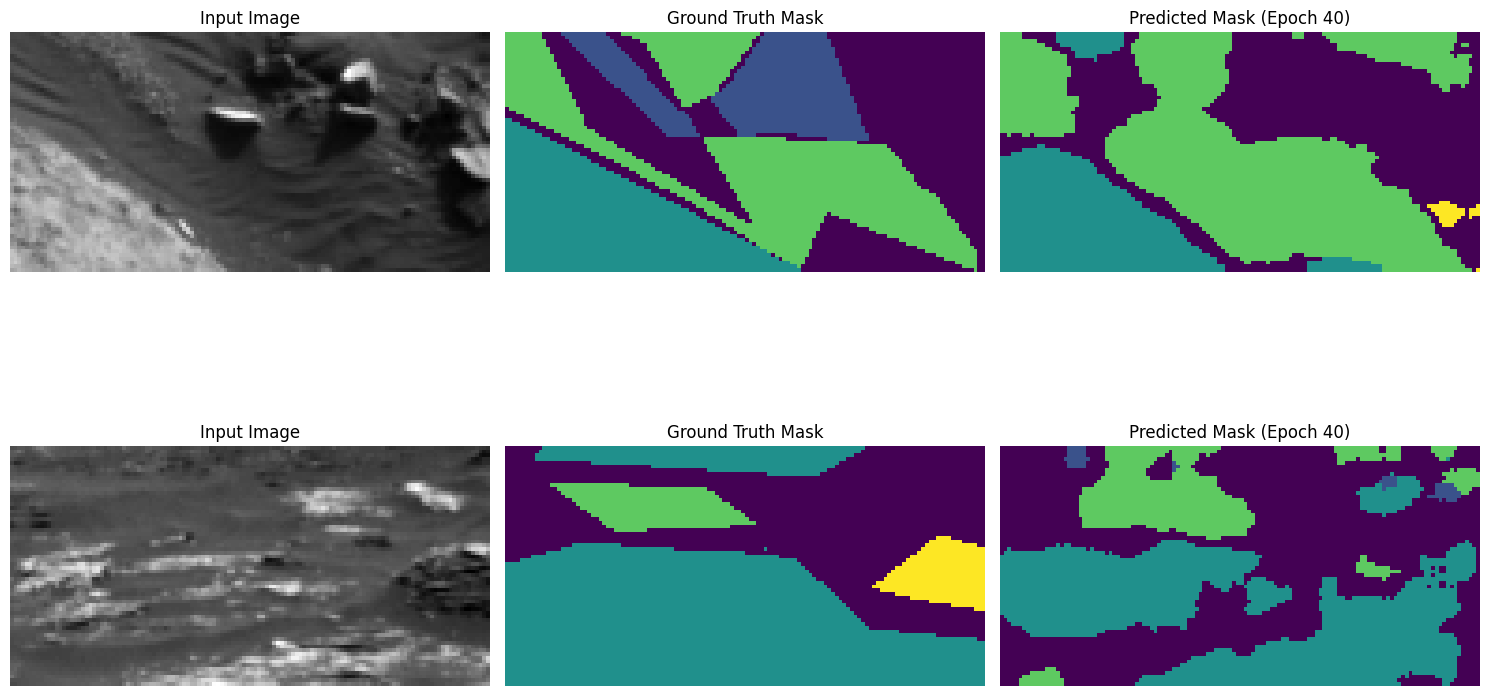

452/452 ━━━━━━━━━━━━━━━━━━━━ 93s 206ms/step - accuracy: 0.9117 - loss: 0.6116 - mean_iou: 0.7449 - val_accuracy: 0.7730 - val_loss: 0.7494 - val_mean_iou: 0.4646 - learning_rate: 6.2500e-05
Epoch 41/1000
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.9134 - loss: 0.6103 - mean_iou: 0.7467Available log keys: dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou'])

Epoch 41: val_loss did not improve from 0.74738
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


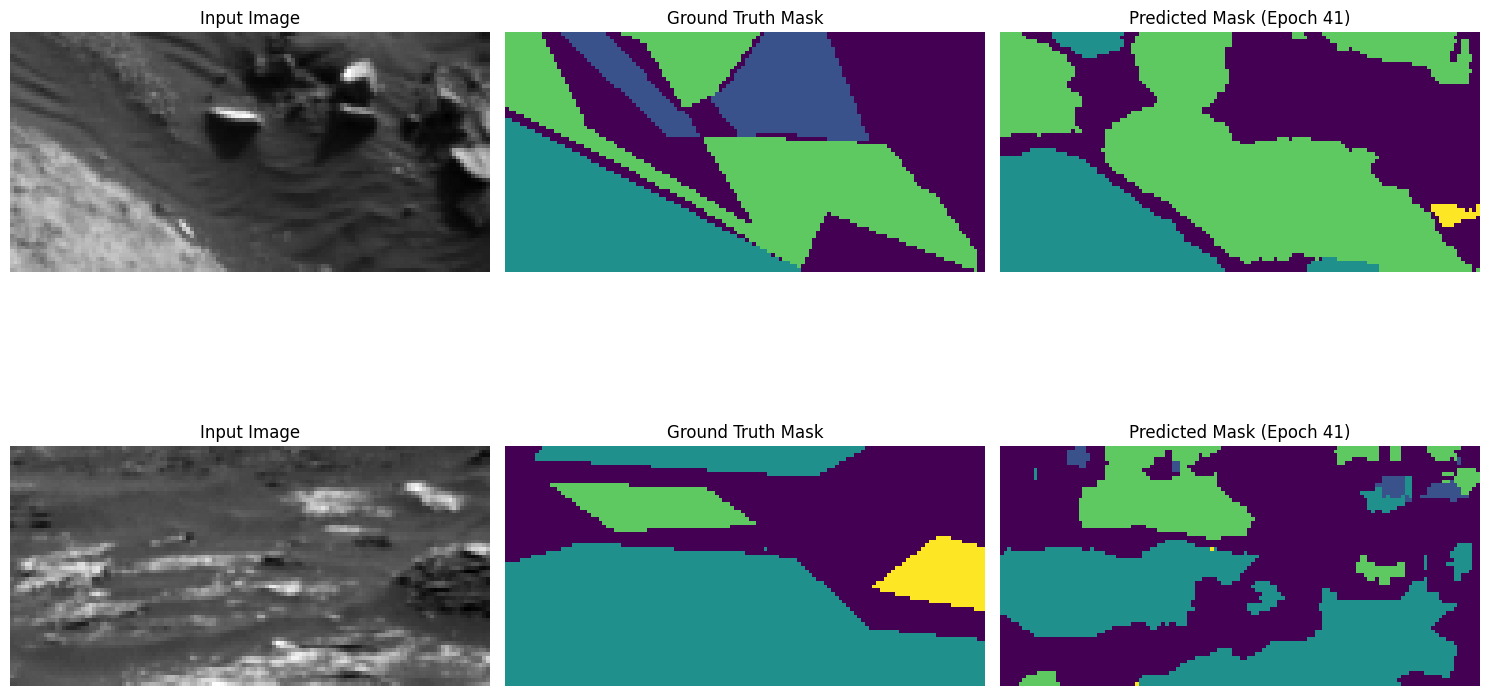

452/452 ━━━━━━━━━━━━━━━━━━━━ 93s 206ms/step - accuracy: 0.9134 - loss: 0.6103 - mean_iou: 0.7466 - val_accuracy: 0.7730 - val_loss: 0.7496 - val_mean_iou: 0.4625 - learning_rate: 3.1250e-05
Epoch 42/1000
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.9145 - loss: 0.6091 - mean_iou: 0.7473Available log keys: dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou'])

Epoch 42: val_loss did not improve from 0.74738
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


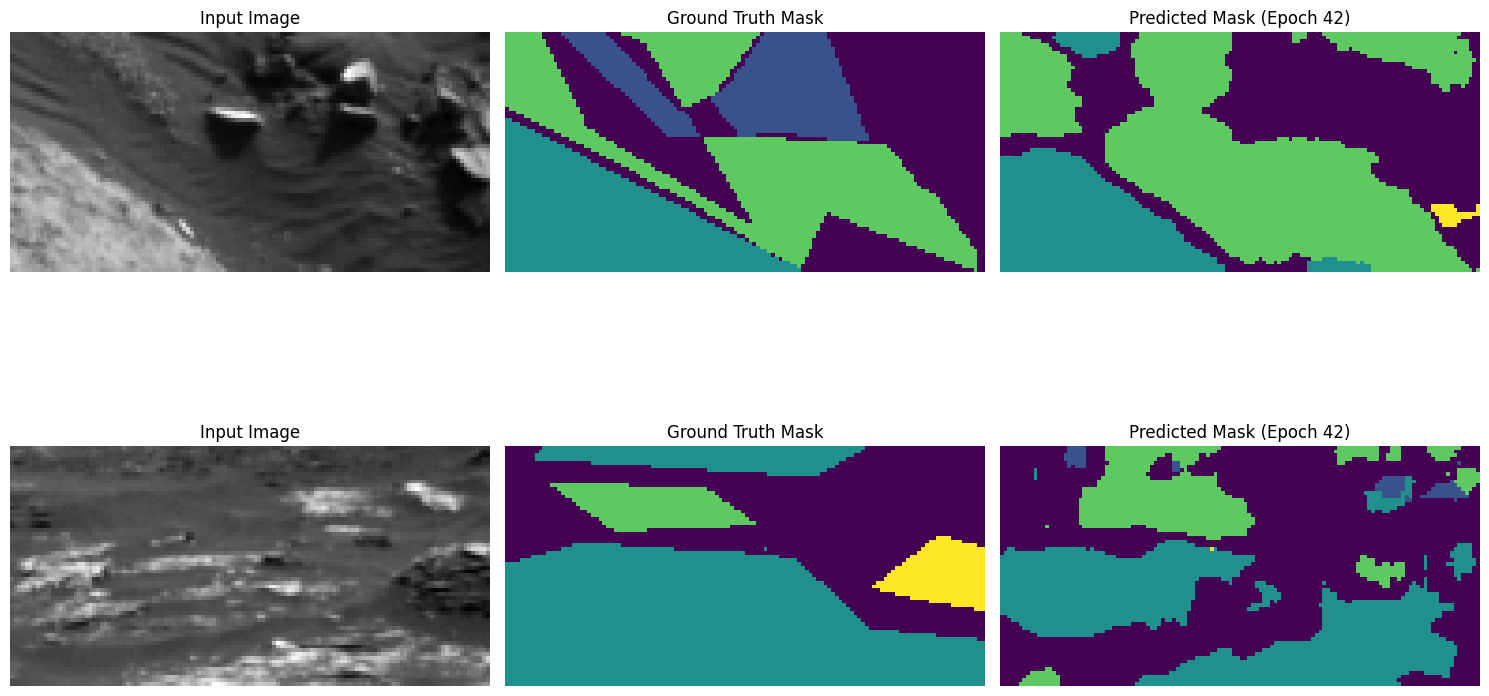

452/452 ━━━━━━━━━━━━━━━━━━━━ 93s 206ms/step - accuracy: 0.9145 - loss: 0.6091 - mean_iou: 0.7472 - val_accuracy: 0.7719 - val_loss: 0.7501 - val_mean_iou: 0.4617 - learning_rate: 3.1250e-05
Epoch 43/1000
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.9155 - loss: 0.6082 - mean_iou: 0.7479Available log keys: dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou'])

Epoch 43: val_loss did not improve from 0.74738
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


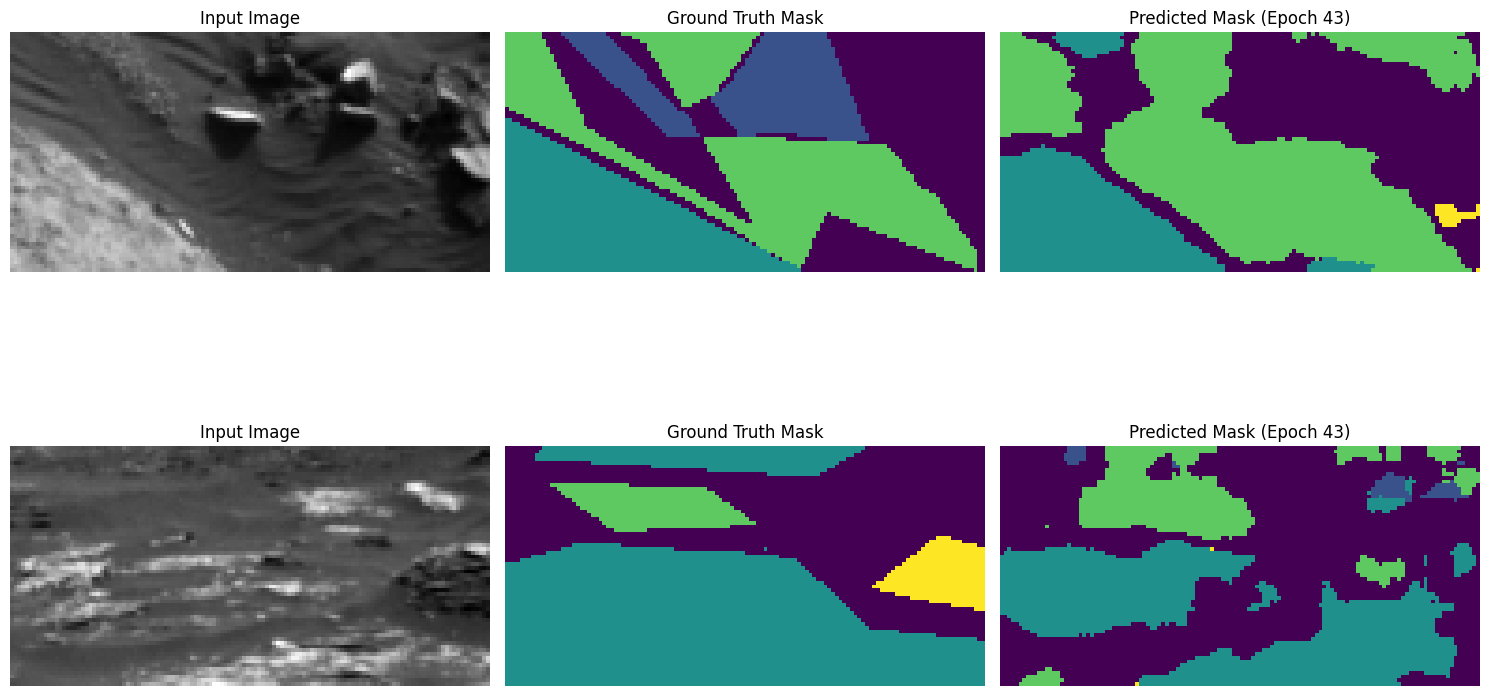

452/452 ━━━━━━━━━━━━━━━━━━━━ 93s 205ms/step - accuracy: 0.9155 - loss: 0.6082 - mean_iou: 0.7479 - val_accuracy: 0.7717 - val_loss: 0.7505 - val_mean_iou: 0.4615 - learning_rate: 3.1250e-05
Epoch 44/1000
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.9165 - loss: 0.6073 - mean_iou: 0.7488Available log keys: dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou'])

Epoch 44: val_loss did not improve from 0.74738
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


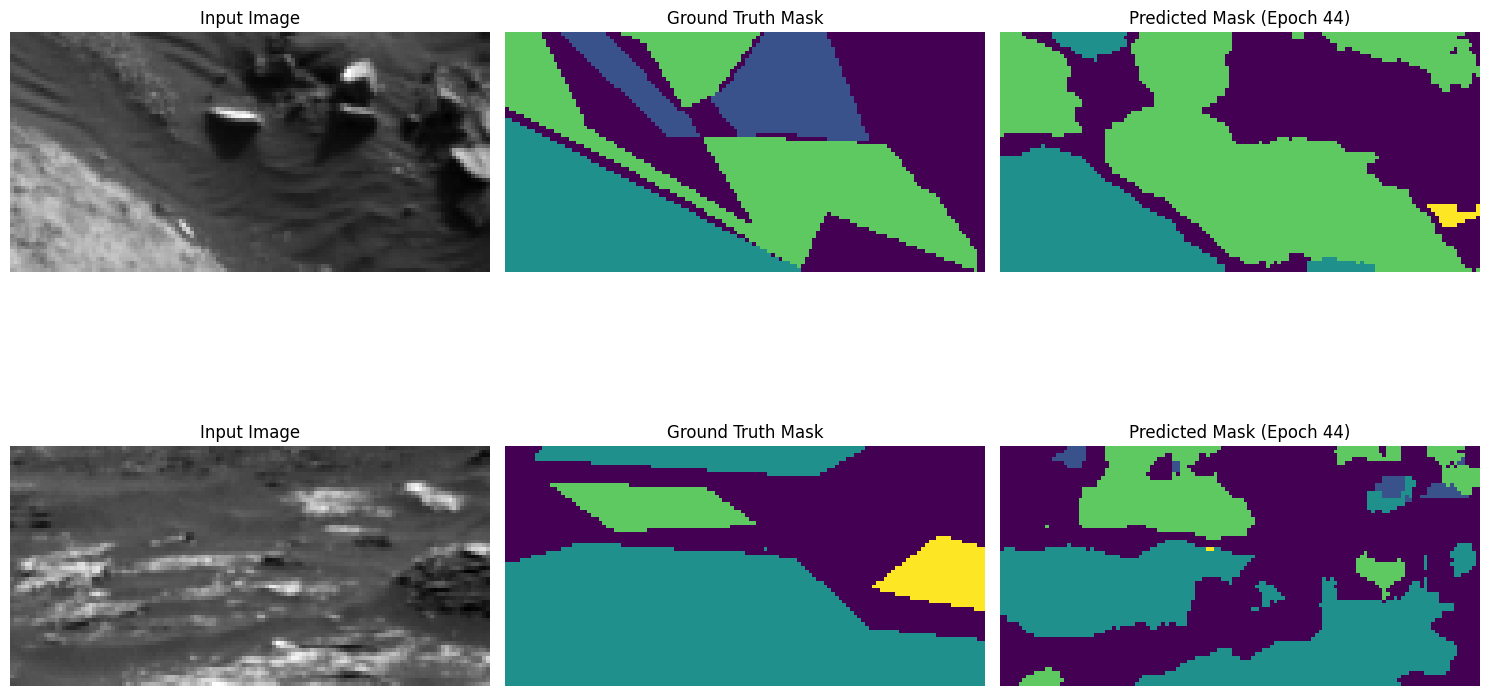

452/452 ━━━━━━━━━━━━━━━━━━━━ 93s 205ms/step - accuracy: 0.9165 - loss: 0.6073 - mean_iou: 0.7488 - val_accuracy: 0.7718 - val_loss: 0.7508 - val_mean_iou: 0.4621 - learning_rate: 3.1250e-05
Epoch 45/1000
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.9176 - loss: 0.6065 - mean_iou: 0.7495Available log keys: dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou'])

Epoch 45: val_loss did not improve from 0.74738

Epoch 45: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


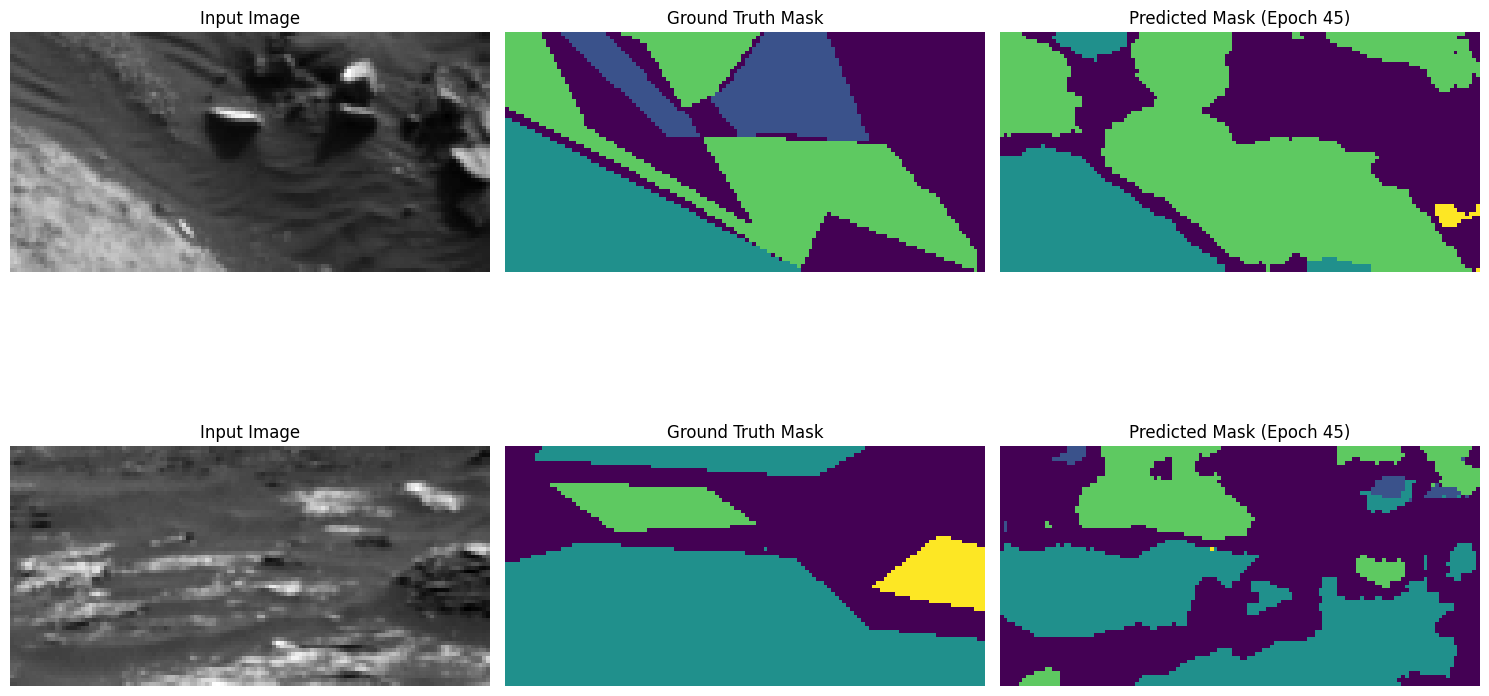

452/452 ━━━━━━━━━━━━━━━━━━━━ 93s 206ms/step - accuracy: 0.9176 - loss: 0.6065 - mean_iou: 0.7495 - val_accuracy: 0.7721 - val_loss: 0.7506 - val_mean_iou: 0.4628 - learning_rate: 3.1250e-05


In [36]:
import tensorflow as tf
from tensorflow.keras import layers as tfkl

import tensorflow as tf
from tensorflow.keras import layers as tfkl
from tensorflow.keras.utils import register_keras_serializable

@register_keras_serializable(package="Custom")
def residual_block(x, filters, norm_type='layer'):
    shortcut = x
    x = tfkl.Conv2D(filters, (3, 3), padding='same')(x)
    x = apply_normalization(x, norm_type)
    x = tfkl.Activation('relu')(x)
    x = tfkl.Conv2D(filters, (3, 3), padding='same')(x)
    x = apply_normalization(x, norm_type)
    x = tfkl.Activation('relu')(x)
    shortcut = tfkl.Conv2D(filters, (1, 1), padding='same')(shortcut)
    return tfkl.add([x, shortcut])

@register_keras_serializable(package="Custom")
def learnable_skip_connection(encoder_features, decoder_features, filters):
    concat_features = tfkl.Concatenate()([encoder_features, decoder_features])
    fusion_gate = tfkl.Conv2D(filters, (1, 1), activation='sigmoid')(concat_features)
    weighted_features = fusion_gate * encoder_features + (1 - fusion_gate) * decoder_features
    return weighted_features

@register_keras_serializable(package="Custom")
def focal_dice_loss(class_weights, gamma=2.0, alpha=0.25, smooth=1e-6):
    def loss(y_true, y_pred):
        y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=len(class_weights))
        y_true_one_hot = tf.squeeze(y_true_one_hot, axis=-2) if len(y_true_one_hot.shape) > len(y_pred.shape) else y_true_one_hot
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        ce_loss = -y_true_one_hot * tf.math.log(y_pred)
        focal_loss = alpha * tf.pow(1 - y_pred, gamma) * ce_loss
        focal_loss = tf.reduce_mean(tf.reduce_sum(class_weights * focal_loss, axis=-1))
        intersection = tf.reduce_sum(y_true_one_hot * y_pred, axis=(1, 2))
        denominator = tf.reduce_sum(y_true_one_hot + y_pred, axis=(1, 2))
        dice_loss = 1 - (2 * intersection * class_weights + smooth) / (denominator * class_weights + smooth)
        dice_loss = tf.reduce_mean(dice_loss)
        return focal_loss + dice_loss
    return loss

@register_keras_serializable(package="Custom")
def apply_normalization(x, norm_type):
    if norm_type == 'layer':
        return tfkl.LayerNormalization()(x)
    elif norm_type == 'instance':
        return tf.keras.layers.LayerNormalization()(x)
    elif norm_type == 'group':
        from tensorflow_addons.layers import GroupNormalization
        return GroupNormalization(groups=8, axis=-1)(x)
    else:
        raise ValueError(f"Unsupported normalization type: {norm_type}")

# U-Net with Residual Connections, Adaptive Normalization, and Learnable Fusion
def enhanced_unet(input_shape, num_classes, norm_type='layer'):
    inputs = tfkl.Input(input_shape)

    # Encoder
    c1 = residual_block(inputs, 64, norm_type=norm_type)
    p1 = tfkl.MaxPooling2D((2, 2))(c1)

    c2 = residual_block(p1, 128, norm_type=norm_type)
    p2 = tfkl.MaxPooling2D((2, 2))(c2)

    c3 = residual_block(p2, 256, norm_type=norm_type)
    p3 = tfkl.MaxPooling2D((2, 2))(c3)

    c4 = residual_block(p3, 512, norm_type=norm_type)

    # Decoder
    u1 = tfkl.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c4)
    u1 = learnable_skip_connection(c3, u1, 256)
    d1 = residual_block(u1, 256, norm_type=norm_type)

    u2 = tfkl.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(d1)
    u2 = learnable_skip_connection(c2, u2, 128)
    d2 = residual_block(u2, 128, norm_type=norm_type)

    u3 = tfkl.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(d2)
    u3 = learnable_skip_connection(c1, u3, 64)
    d3 = residual_block(u3, 64, norm_type=norm_type)

    outputs = tfkl.Conv2D(num_classes, (1, 1), activation='softmax')(d3)

    return tf.keras.Model(inputs, outputs)

# Initialize the enhanced U-Net
input_shape = X_train.shape[1:]  # e.g., (64, 128, 1)
num_classes = 5

model = enhanced_unet(input_shape, num_classes, norm_type='layer')
# Calculate class weights based on pixel proportions
class_pixel_counts = np.bincount(y_train_int.flatten(), minlength=num_classes)  # Count pixels for each class
total_pixels = np.sum(class_pixel_counts)  # Total number of pixels
class_weights = total_pixels / (class_pixel_counts + 1e-6)  # Inverse frequency
class_weights /= np.sum(class_weights)  # Normalize to sum to 1
# Compile the model with the new loss function
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=focal_dice_loss(class_weights),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0])]
)

model.summary()

# Training
save_best_miou = SaveBestMeanIoU(filepath="best_model_mean_iou.h5", monitor="val_mean_iou", mode="max", verbose=1)
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=1000,
    callbacks=[save_best_miou, early_stopping, model_checkpoint, reduce_lr, visualize_callback]
)


In [37]:

print(f"X_train_finetune shape: {X_train.shape}")
print(f"y_train_finetune shape: {y_train.shape}")
print(f"X_val_top_20_percent shape: {X_val.shape}")
print(f"y_val_top_20_percent shape: {y_val.shape}")

X_train_finetune shape: (14462, 64, 128, 1)
y_train_finetune shape: (14462, 64, 128)
X_val_top_20_percent shape: (501, 64, 128, 1)
y_val_top_20_percent shape: (501, 64, 128, 1)


In [38]:
# Load the saved model
best_model = tf.keras.models.load_model("best_model.keras",compile=False)



In [39]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
X_train_finetune=X_train[top_20_percent_indices]
y_train_finetune=y_train[top_20_percent_indices]
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Veri artırma argümanları
data_gen_args = dict(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Hem görüntü hem maske için veri artırma
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

X_train_aug = []
y_train_aug = []

for x, y in zip(X_train_finetune, y_train_finetune):
    x = np.expand_dims(x, axis=-1) if x.ndim == 2 else x  # Kanal boyutunu ekle
    y = np.expand_dims(y, axis=-1) if y.ndim == 2 else y  # Kanal boyutunu ekle

    # Her görüntü ve maske çifti için aynı random seed kullanılır
    seed = np.random.randint(0, 10000)
    
    # Görüntüyü artır
    image_generator = image_datagen.flow(
        x[np.newaxis, ...],  # Batch boyutu ekle
        batch_size=1,
        seed=seed
    )
    
    # Maskeyi artır
    mask_generator = mask_datagen.flow(
        y[np.newaxis, ...],  # Batch boyutu ekle
        batch_size=1,
        seed=seed
    )

    # Örnekler oluştur
    for _ in range(5):  # Her görüntü için 5 artırılmış örnek oluştur
        augmented_x = next(image_generator)[0]  # İlk örneği al
        augmented_y = next(mask_generator)[0]  # İlk örneği al
        
        # Maskeyi bir kez daha yuvarlayarak tam sayı yap
        augmented_y = np.round(augmented_y).astype(int)

        X_train_aug.append(augmented_x)
        y_train_aug.append(augmented_y)

# Ensure y_train_finetune has the correct dimensions
if y_train_finetune.ndim == 3:  # Check if channel dimension is missing
    y_train_finetune = np.expand_dims(y_train_finetune, axis=-1)

# Veri artırmayı orijinal veriyle birleştir
X_train_finetune = np.concatenate([X_train_finetune, X_train_aug], axis=0)
y_train_finetune = np.concatenate([y_train_finetune, y_train_aug], axis=0)

print(f"Fine-tuning dataset size: {X_train_finetune.shape}, {y_train_finetune.shape}")




Fine-tuning dataset size: (984, 64, 128, 1), (984, 64, 128, 1)


In [40]:
model.load_weights("best_model_mean_iou.h5")

In [ ]:
additional_epochs = 20 # Adjust if initial training stopped earlier


X_train_finetune=X_train[top_20_percent_indices]
y_train_finetune=y_train[top_20_percent_indices]


y_train_finetune = tf.keras.utils.to_categorical(y_train_finetune, num_classes)
y_val_top_20_percent= tf.keras.utils.to_categorical(y_val_top_20_percent, num_classes)

In [46]:
# Add a new dimension to the end
X_val_top_20_percent = np.expand_dims(X_val_top_20_percent, axis=-1)

print(f"Updated shape: {X_val_top_20_percent.shape}")


Updated shape: (2, 64, 128, 1)


In [51]:
X_train_finetune = X_train_finetune.astype('float32')
X_val_top_20_percent = X_val_top_20_percent.astype('float32')
y_train_finetune = y_train_finetune.astype('int32')
y_val_top_20_percent = y_val_top_20_percent.astype('int32')


In [57]:
y_train_finetune = np.argmax(y_train_finetune, axis=-1)  # Convert one-hot to single-class
y_val_top_20_percent = np.argmax(y_val_top_20_percent, axis=-1)  # Same for validation


In [59]:
# Ensure y_train_finetune has the correct dimensions
if y_val_top_20_percent.ndim == 3:  # Check if channel dimension is missing
    y_val_top_20_percent = np.expand_dims(y_val_top_20_percent, axis=-1)

In [60]:


print("X_train_finetune shape:", X_train_finetune.shape)
print("y_train_finetune shape:", y_train_finetune.shape)
print("X_val_top_20_percent shape:", X_val_top_20_percent.shape)
print("y_val_top_20_percent shape:", y_val_top_20_percent.shape)
print("Model input shape:", model.input_shape)
print("Model output shape:", model.output_shape)


X_train_finetune shape: (164, 64, 128, 1)
y_train_finetune shape: (164, 64, 128)
X_val_top_20_percent shape: (2, 64, 128, 1)
y_val_top_20_percent shape: (2, 64, 128, 1)
Model input shape: (None, 64, 128, 1)
Model output shape: (None, 64, 128, 5)


In [61]:
# Example for expanding dimensions if required
if len(y_train_finetune.shape) == 3:  # Missing one-hot encoding or channel dimension
    y_train_finetune = np.expand_dims(y_train_finetune, axis=-1)
    print("Expanded y_train_finetune shape:", y_train_finetune.shape)


Expanded y_train_finetune shape: (164, 64, 128, 1)


In [62]:
print("Model input shape:", model.input_shape)
print("Model output shape:", model.output_shape)


Model input shape: (None, 64, 128, 1)
Model output shape: (None, 64, 128, 5)


In [63]:


# Fine-tuning
history_finetune = model.fit(
    X_train_finetune,
    y_train_finetune,
    validation_data=(X_val_top_20_percent, y_val_top_20_percent),  # Use top 20% validation data
    initial_epoch=94,  # Start from the epoch where training stopped
    epochs=additional_epochs + 94,  # Extend by additional epochs
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)


Epoch 95/114
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8676 - loss: 0.6769 - mean_iou: 0.6103   
Epoch 95: val_loss did not improve from 0.74738
6/6 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.8673 - loss: 0.6769 - mean_iou: 0.6168 - val_accuracy: 0.2129 - val_loss: 1.4415 - val_mean_iou: 0.0574 - learning_rate: 1.5625e-05
Epoch 96/114
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.8698 - loss: 0.6747 - mean_iou: 0.6022
Epoch 96: val_loss did not improve from 0.74738
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - accuracy: 0.8691 - loss: 0.6746 - mean_iou: 0.6177 - val_accuracy: 0.2122 - val_loss: 1.4427 - val_mean_iou: 0.0572 - learning_rate: 1.5625e-05
Epoch 97/114
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.8721 - loss: 0.6721 - mean_iou: 0.6035
Epoch 97: val_loss did not improve from 0.74738
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - accuracy: 0.8714 - loss: 0.6722 - mean_iou: 0.6191 - val_accuracy: 0.2126 - val_loss: 1.4443 - val_mean_iou: 0.0571 - learning_rate:

In [64]:
rare_class_eval = model.evaluate(X_val_top_20_percent, y_val_top_20_percent)
print(f"Rare Class Validation Evaluation: {rare_class_eval}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2129 - loss: 1.4415 - mean_iou: 0.0574
Rare Class Validation Evaluation: [1.4415276050567627, 0.212890625, 0.05737212300300598]


In [65]:
# Load the saved model
import numpy as np
from sklearn.metrics import confusion_matrix

# Load the saved best model
#best_model = tf.keras.models.load_model("best_model_mean_iou.h5", custom_objects={"MeanIoU": tf.keras.metrics.MeanIoU})

# Predict on validation data
y_val_pred = model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=-1)  # Convert to class predictions

# Reshape the true labels to match the predictions
y_val_true = y_val.squeeze()  # Remove channel dimension if present

# Initialize variables to store IoU per class
num_classes = 5
ious = []

# Compute IoU for each class
for class_id in range(1,num_classes):
    true_class = (y_val_true == class_id).astype(int)
    pred_class = (y_val_pred_classes == class_id).astype(int)
    intersection = np.sum(true_class * pred_class)
    union = np.sum(true_class + pred_class) - intersection
    iou = intersection / union if union > 0 else 0.0
    ious.append(iou)
    print(f"Class {class_id} IoU: {iou:.4f}")

# Display mean IoU
mean_iou = np.mean([iou for iou in ious])  # Exclude zero IoUs
print(f"Mean IoU (excluding zero IoUs): {mean_iou:.4f}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step
Class 1 IoU: 0.7235
Class 2 IoU: 0.5921
Class 3 IoU: 0.6924
Class 4 IoU: 0.0720
Mean IoU (excluding zero IoUs): 0.5200


In [66]:
import numpy as np

def mean_iou(y_true, y_pred, num_classes):
    """
    Calculate Mean Intersection over Union (IoU)
    :param y_true: Ground truth masks (H, W)
    :param y_pred: Predicted masks (H, W)
    :param num_classes: Number of classes
    :return: Mean IoU for all classes
    """
    iou_per_class = []
    for cls in range(num_classes):
        intersection = np.logical_and(y_true == cls, y_pred == cls).sum()
        union = np.logical_or(y_true == cls, y_pred == cls).sum()
        if union == 0:  # Avoid division by zero
            iou_per_class.append(np.nan)  # Mark as NaN if the class is not present
        else:
            iou_per_class.append(intersection / union)
    mean_iou_value = np.nanmean(iou_per_class)  # Mean ignoring NaNs
    return mean_iou_value, iou_per_class


In [67]:
# Full validation dataset predictions
y_val_pred_full = model.predict(X_val)
y_val_pred_full = np.argmax(y_val_pred_full, axis=-1)  # Convert to class indices

# Top 20% rare class validation dataset predictions
y_val_pred_rare = model.predict(X_val_top_20_percent)
y_val_pred_rare = np.argmax(y_val_pred_rare, axis=-1)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step


In [69]:
# Full validation dataset
mean_iou_full, iou_per_class_full = mean_iou(y_val.flatten(), y_val_pred_full.flatten(), num_classes)
print("Full Validation Mean IoU:", mean_iou_full)
for cls, iou in enumerate(iou_per_class_full):
    print(f"Class {cls} IoU: {iou:.4f}")

"""# Top 20% rare class validation dataset
mean_iou_rare, iou_per_class_rare = mean_iou(y_val_top_20_percent.flatten(), y_val_pred_rare.flatten(), num_classes)
print("\nTop 20% Rare Class Validation Mean IoU:", mean_iou_rare)
for cls, iou in enumerate(iou_per_class_rare):
    print(f"Class {cls} IoU: {iou:.4f}")"""


Full Validation Mean IoU: 0.5059796375550184
Class 0 IoU: 0.4499
Class 1 IoU: 0.7235
Class 2 IoU: 0.5921
Class 3 IoU: 0.6924
Class 4 IoU: 0.0720


'# Top 20% rare class validation dataset\nmean_iou_rare, iou_per_class_rare = mean_iou(y_val_top_20_percent.flatten(), y_val_pred_rare.flatten(), num_classes)\nprint("\nTop 20% Rare Class Validation Mean IoU:", mean_iou_rare)\nfor cls, iou in enumerate(iou_per_class_rare):\n    print(f"Class {cls} IoU: {iou:.4f}")'

In [70]:
#model=best_model

In [81]:
model_filename = f"model_best_normalized_augmented_hvr_best_invert_noise.keras"
model.save(model_filename)

print(f"Model saved to {model_filename}")

Model saved to model_best_normalized_augmented_hvr_best_invert_noise.keras


## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.



In [82]:
import os
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [83]:
print(f"X_test shape before reshaping: {X_test.shape}")

X_test shape before reshaping: (10022, 64, 128, 1)


In [91]:
# Generate predictions
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)  # Convert probabilities to class labels
print(f"Predictions shape: {preds.shape}")
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)  # Convert probabilities to class labels

# Replace predicted class 0 with class 4
preds[preds == 0] = 4
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 23s 74ms/step
Predictions shape: (10022, 64, 128)
314/314 ━━━━━━━━━━━━━━━━━━━━ 23s 74ms/step
Predictions shape: (10022, 64, 128)


Randomly selected indices for prediction (seed=42): [3543 5731 4801  416 5125 9915  293 5020 1765 4192 2288 1188  107 7583
  856 5090 9784 5192 6935  850]


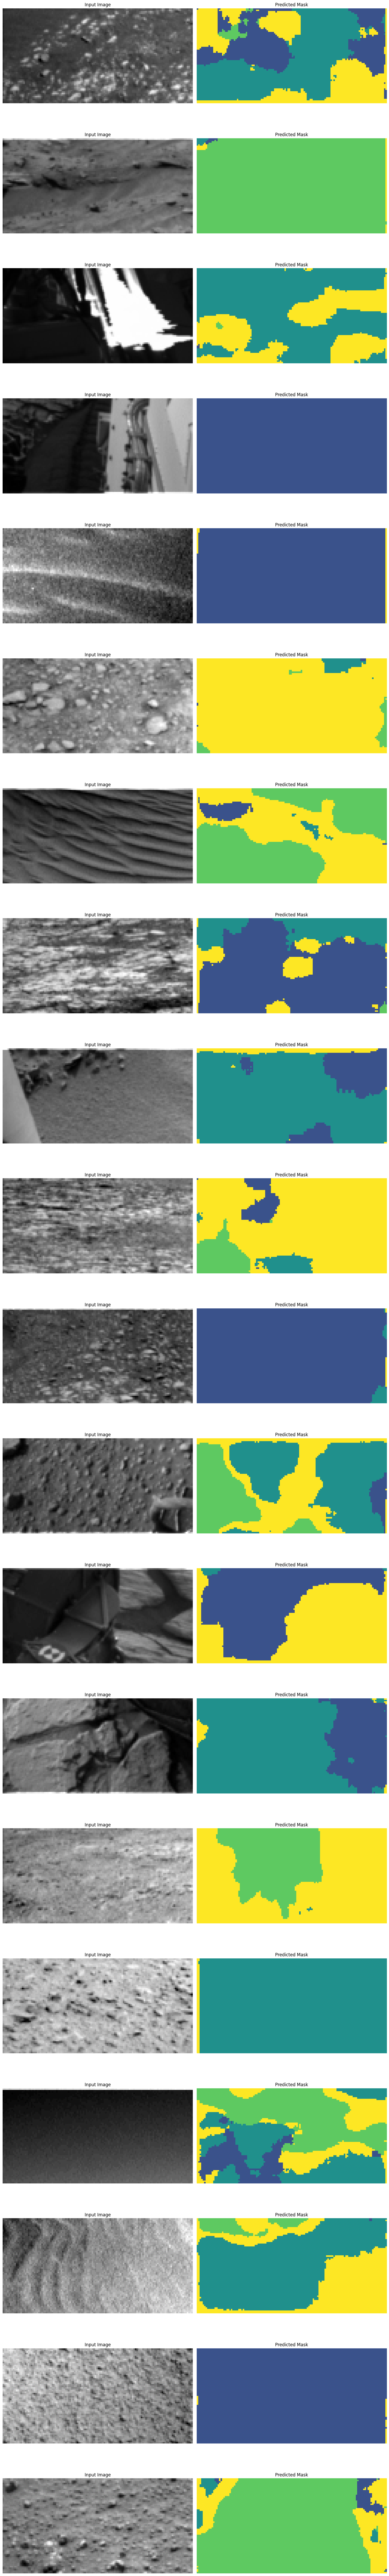

In [92]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)
# Randomly select 20 indices for prediction
random_indices = np.random.choice(X_test.shape[0], size=20, replace=False)
print(f"Randomly selected indices for prediction (seed=42): {random_indices}")

# Select 20 random samples and their corresponding masks
X_sample = X_test[random_indices]



predicted_masks = preds

# Visualize the predictions
num_images = len(X_sample)  # Number of images to visualize
fig, axes = plt.subplots(num_images, 2, figsize=(15, num_images * 5))

for i in range(num_images):
    # Original Image
    ax_img = axes[i, 0]
    ax_img.imshow(X_sample[i].squeeze(), cmap="gray")
    ax_img.set_title("Input Image")
    ax_img.axis("off")

    # Predicted Mask
    ax_pred = axes[i, 1]
    ax_pred.imshow(predicted_masks[i], cmap="viridis",vmin=0,vmax=4)
    ax_pred.set_title("Predicted Mask")
    ax_pred.axis("off")

plt.tight_layout()
plt.show()

In [93]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [94]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)



In [95]:
len(submission_df.columns)

8193

In [96]:
len(submission_df)

10022